# Homework Assigment 

## Input

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from tqdm import tqdm

# Load the dataset
df = pd.read_csv('../Input/Senior Data Analyst Task Transactions.csv')
# df.head()

## 1. Data Cleaning

### 1.0 General Check

In [2]:
print("=== MISSING VALUES ===")
missing = df.isnull().sum()
print(missing[missing > 0], "\n")

# Check for negative values
print("=== NEGATIVE VALUES CHECK ===")
for col in ['Amount', 'Price_Per_Unit', 'Transaction_Fee']:
    negative_rows = df[df[col] < 0]
    if not negative_rows.empty:
        print(f"\nNegative values in '{col}':")
        print(negative_rows[['Transaction_ID', col]])
    else:
        print(f"No negative values in '{col}'")

print("\n=== ZERO VALUES CHECK ===")
for col in ['Amount', 'Price_Per_Unit', 'Transaction_Fee']:
    zero_rows = df[df[col] == 0]
    if not zero_rows.empty:
        print(f"\Zero values in '{col}':")
        print(zero_rows[['Transaction_ID', col]])
    else:
        print(f"No zero values in '{col}'")

# Check for Total_Value mismatch
print("\n=== TOTAL VALUE MISMATCHES ===")
calc_total = df['Amount'] * df['Price_Per_Unit']
mismatch_mask = np.abs(df['Total_Value'] - calc_total) > 0.005  # tolerance for rounding errors
if mismatch_mask.any():
    print(df.loc[mismatch_mask, ['Transaction_ID', 'Amount', 'Price_Per_Unit', 'Total_Value']])
else:
    print("All Total_Value entries match Amount × Price_Per_Unit")

# Check for inconsistent category values
def check_category_column(col):
    print(f"\n=== UNIQUE VALUES in '{col}' ===")
    print(sorted(df[col].dropna().unique()))

category_columns = ['Transaction_Type', 'Wallet_Type', 'Status', 'Platform', 'Crypto']
for col in category_columns:
    check_category_column(col)

# Preview Transaction_Date formatting issues
print("\n=== Transaction_Date PARSING CHECK ===")
try:
    parsed_Transaction_Dates = pd.to_datetime(df['Transaction_Date'], errors='coerce')
    invalid_Transaction_Dates = df[parsed_Transaction_Dates.isnull()]
    if not invalid_Transaction_Dates.empty:
        print("Rows with invalid Transaction_Date format:")
        print(invalid_Transaction_Dates[['Transaction_ID', 'Transaction_Date']])
    else:
        print("All Transaction_Date values parsed correctly.")
except Exception as e:
    print("Error while parsing Transaction_Date:", e)


=== MISSING VALUES ===
Series([], dtype: int64) 

=== NEGATIVE VALUES CHECK ===
No negative values in 'Amount'
No negative values in 'Price_Per_Unit'
No negative values in 'Transaction_Fee'

=== ZERO VALUES CHECK ===
No zero values in 'Amount'
No zero values in 'Price_Per_Unit'
No zero values in 'Transaction_Fee'

=== TOTAL VALUE MISMATCHES ===
All Total_Value entries match Amount × Price_Per_Unit

=== UNIQUE VALUES in 'Transaction_Type' ===
['Buy', 'Sell', 'Stake', 'Transfer', 'Withdraw']

=== UNIQUE VALUES in 'Wallet_Type' ===
['Cold Wallet', 'Exchange Wallet', 'Hot Wallet', 'Ledger', 'Trezor']

=== UNIQUE VALUES in 'Status' ===
['Completed', 'Failed', 'Pending']

=== UNIQUE VALUES in 'Platform' ===
['Binance', 'Coinbase', 'FTX', 'Huobi', 'Kraken', 'KuCoin', 'OKX']

=== UNIQUE VALUES in 'Crypto' ===
['Avalanche', 'BNB', 'Bitcoin', 'Cardano', 'Dogecoin', 'Ethereum', 'Litecoin', 'Polkadot', 'Solana', 'XRP']

=== Transaction_Date PARSING CHECK ===
All Transaction_Date values parsed corr

### 1.1 Unique Transactions

In [3]:
# 1. How many transactions do we have? Are all Transaction_IDs unique?
total_transactions = df.shape[0]
unique_transaction_ids = df['Transaction_ID'].nunique()
print(f"Total transactions: {total_transactions}")
print(f"Unique Transaction_IDs: {unique_transaction_ids}")
print(f"All Transaction_IDs unique? {total_transactions == unique_transaction_ids}")

# 2. How many unique users? How many did more than one transaction?
unique_users = df['User_ID'].nunique()
user_transaction_counts = df['User_ID'].value_counts()
users_more_than_one = (user_transaction_counts > 1).sum()
print(f"Unique users: {unique_users}")
print(f"Users with more than one transaction: {users_more_than_one}")
print(f"Max transactions by a single user: {user_transaction_counts.max()}")

Total transactions: 10000
Unique Transaction_IDs: 9946
All Transaction_IDs unique? False
Unique users: 9418
Users with more than one transaction: 561
Max transactions by a single user: 4


In [4]:
# --- Show duplicated Transaction_IDs ---
dups = df[df['Transaction_ID'].duplicated(keep=False)]
print(f"Found {len(dups)} duplicated Transaction_ID rows:")
print(dups.sort_values(by='Transaction_ID')[['Transaction_ID', 'User_ID', 'Crypto', 'Transaction_Type', 'Status']])

# --- Remove duplicates (keep first occurrence) ---
df = df[~df['Transaction_ID'].duplicated(keep=False)]
print(f"\nRemoved {len(dups)} duplicate rows. New total rows: {len(df)}")

Found 107 duplicated Transaction_ID rows:
      Transaction_ID  User_ID     Crypto Transaction_Type     Status
1547          139159    80154     Solana              Buy     Failed
7103          139159    14269        XRP             Sell    Pending
6287          144679    94559   Ethereum            Stake  Completed
9363          144679    51348   Polkadot         Withdraw    Pending
9849          148659    26015   Litecoin              Buy    Pending
...              ...      ...        ...              ...        ...
5227          976697    86891        BNB             Sell     Failed
4743          986417    61795  Avalanche             Sell     Failed
8386          986417    40156     Solana              Buy  Completed
5957          995287    48207        BNB             Sell  Completed
8760          995287    92546    Cardano              Buy     Failed

[107 rows x 5 columns]

Removed 107 duplicate rows. New total rows: 9893


### 1.3 Platform, Transaction Type, Wallet Type Splits

In [5]:
# 3. How many unique cryptos and platforms were used?
unique_cryptos = df['Crypto'].nunique()
unique_platforms = df['Platform'].nunique()
print(f"Unique cryptos: {unique_cryptos}")
print(f"Unique platforms: {unique_platforms}")
print("Cryptos used:", df['Crypto'].unique())
print("Platforms used:", df['Platform'].unique())

Unique cryptos: 10
Unique platforms: 7
Cryptos used: ['Bitcoin' 'Solana' 'Cardano' 'XRP' 'Dogecoin' 'BNB' 'Polkadot' 'Litecoin'
 'Avalanche' 'Ethereum']
Platforms used: ['KuCoin' 'Binance' 'OKX' 'FTX' 'Kraken' 'Coinbase' 'Huobi']


In [6]:
# 4. Transaction status and type distribution
print("Transaction Status Counts:")
print(df['Status'].value_counts())
print("\nTransaction Type Counts:")
print(df['Transaction_Type'].value_counts())

Transaction Status Counts:
Status
Failed       3317
Completed    3288
Pending      3288
Name: count, dtype: int64

Transaction Type Counts:
Transaction_Type
Stake       2032
Sell        2003
Buy         1989
Transfer    1957
Withdraw    1912
Name: count, dtype: int64


In [7]:
# 5. Grouped stats by Wallet_Type and Transaction_Type
print("Transactions by Wallet Type:")
print(df.groupby('Wallet_Type').size())

print("\nTransactions by Transaction Type:")
print(df.groupby('Transaction_Type').size())

print("\nTransactions by Wallet Type and Transaction Type:")
print(df.groupby(['Wallet_Type', 'Transaction_Type']).size())

Transactions by Wallet Type:
Wallet_Type
Cold Wallet        1944
Exchange Wallet    1996
Hot Wallet         2046
Ledger             1953
Trezor             1954
dtype: int64

Transactions by Transaction Type:
Transaction_Type
Buy         1989
Sell        2003
Stake       2032
Transfer    1957
Withdraw    1912
dtype: int64

Transactions by Wallet Type and Transaction Type:
Wallet_Type      Transaction_Type
Cold Wallet      Buy                 423
                 Sell                377
                 Stake               396
                 Transfer            386
                 Withdraw            362
Exchange Wallet  Buy                 411
                 Sell                422
                 Stake               409
                 Transfer            384
                 Withdraw            370
Hot Wallet       Buy                 387
                 Sell                415
                 Stake               405
                 Transfer            433
                 

### 1.4 Transaction Volume & Fees

In [8]:
# 6. Total and average transaction volume and fee
print("Total transaction value:", df['Total_Value'].sum())
print("Average transaction value:", df['Total_Value'].mean())
print("Total transaction fee:", df['Transaction_Fee'].sum())
print("Average transaction fee:", df['Transaction_Fee'].mean())

# 8. Top 5 users by total transaction value
top_users = df.groupby('User_ID')['Total_Value'].sum().sort_values(ascending=False).head(5)
print("Top 5 users by total transaction value:")
print(top_users)

# 9. Most popular crypto by transaction count
print("Most popular crypto by transaction count:")
print(df['Crypto'].value_counts())

Total transaction value: 14891240156.23
Average transaction value: 1505229.9763701607
Total transaction fee: 371499146.41999996
Average transaction fee: 37551.718024866066
Top 5 users by total transaction value:
User_ID
52935    11040611.17
22053     9926363.54
21873     8632440.75
47619     8596250.92
26106     8592984.99
Name: Total_Value, dtype: float64
Most popular crypto by transaction count:
Crypto
Polkadot     1063
Ethereum     1030
Avalanche    1001
Dogecoin      990
Solana        988
Cardano       986
Bitcoin       978
BNB           965
XRP           954
Litecoin      938
Name: count, dtype: int64


### 1.5 Fees

In [9]:
print("\n=== FEE PERCENTAGE ANALYSIS ===")

# Add fee percentage
df['Fee_%'] = (df['Transaction_Fee'] / df['Total_Value'])

# View outliers: very high or very low fees
fee_outliers = df[(df['Fee_%'] > 3) | (df['Fee_%'] < 2)]  # adjust thresholds
if not fee_outliers.empty:
    print("Transactions with suspiciously high or low fees:")
    print(fee_outliers[['Transaction_ID', 'Platform', 'Crypto', 'Transaction_Type', 'Fee_%']])
else:
    print("No suspicious fee percentages detected.")

# Optional: mean fee % by Platform or Crypto
print("\nAverage fee percentage by Platform and Transaction_Type:")
print(df.groupby(['Platform', 'Transaction_Type'])['Fee_%'].mean().round(2))



=== FEE PERCENTAGE ANALYSIS ===
Transactions with suspiciously high or low fees:
      Transaction_ID  Platform    Crypto Transaction_Type     Fee_%
0             434465    KuCoin   Bitcoin         Withdraw  0.044047
1             905397   Binance    Solana            Stake  0.025819
2             451293       OKX   Cardano              Buy  0.010730
3             841249       FTX       XRP            Stake  0.001902
4             762686    Kraken  Dogecoin            Stake  0.006194
...              ...       ...       ...              ...       ...
9995          186998       FTX   Bitcoin            Stake  0.009031
9996          337144    Kraken   Cardano              Buy  0.020888
9997          946655  Coinbase       BNB         Withdraw  0.042853
9998          153921       OKX  Litecoin              Buy  0.043110
9999          760727  Coinbase  Litecoin         Transfer  0.038918

[9893 rows x 5 columns]

Average fee percentage by Platform and Transaction_Type:
Platform  Transacti

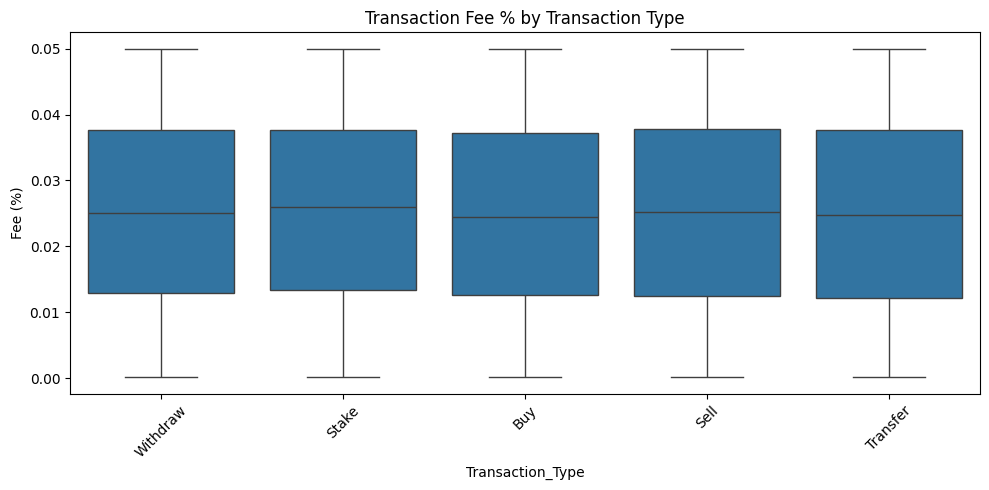

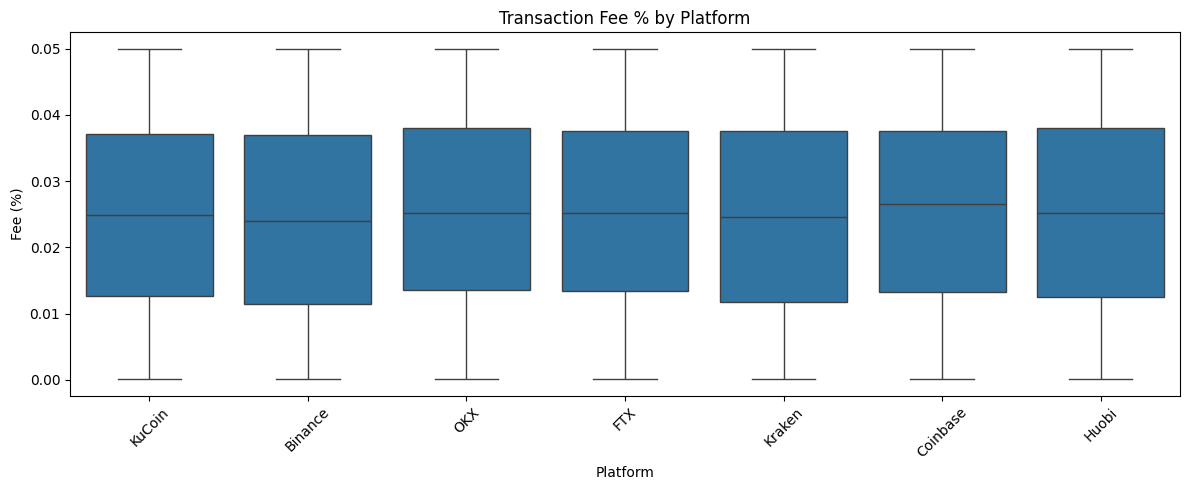

In [10]:
# --- Create Fee Percentage Column ---
df['Fee_%'] = (df['Transaction_Fee'] / df['Total_Value'])

# --- Distribution by Transaction_Type ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Transaction_Type', y='Fee_%')
plt.title("Transaction Fee % by Transaction Type")
plt.ylabel("Fee (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Distribution by Platform ---
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='Platform', y='Fee_%')
plt.title("Transaction Fee % by Platform")
plt.ylabel("Fee (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 1.6 Data Cleaning Summary

#### Dataset Overview
The dataset contains cryptocurrency transaction data with fields such as `Transaction_ID`, `User_ID`, `Crypto`, `Transaction_Type`, `Amount`, `Total_Value`, `Transaction_Fee`, and more.

#### ✔️ Data Cleaning Steps

##### 1. Missing Values
- ✅ No missing values were found in any column.

##### 2. Negative or Zero Values
- ✅ No negative or zero values were detected in `Amount`, `Price_Per_Unit`, `Total_Value`, or `Transaction_Fee`.

##### 3. Total Value Consistency
- ✅ All rows passed the check `Total_Value ≈ Amount × Price_Per_Unit` within a small tolerance for rounding errors.

##### 4. Duplicate Transactions
- ❌ **Found over 100 duplicate `Transaction_ID`s**, often differing by `Status`.
- ✅ These were removed.

##### 5. Fee Percentage Distribution
- A new column `Fee_%` was calculated as `Transaction_Fee / Total_Value × 100`.
- ❌ Boxplots showed **identical fee distributions across all transaction types and platforms**, suggesting that the data might be **synthetic or randomly generated**.

#### 🧪 Conclusion
The dataset is structurally clean and well-formatted but appears to be synthetic due to unusually uniform fee distributions and the presence of duplicate transaction IDs with conflicting statuses.


## 2. Data preparation for reporting

In [11]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['week'] = df['Transaction_Date'].dt.to_period('W').dt.start_time
df['month'] = df['Transaction_Date'].dt.to_period('M').dt.start_time

In [12]:
%%time

# Step 0: Create "month" and "quarter" columns if not already present
df['month'] = pd.to_datetime(df['Transaction_Date']).dt.to_period('M').astype(str)
df['quarter'] = pd.to_datetime(df['Transaction_Date']).dt.to_period('Q').astype(str)

# Step 1: Monthly aggregation by dimension
agg_monthly_t = (
    df
    .groupby(['month', 'Platform', 'Transaction_Type', 'Crypto', 'Wallet_Type', 'Status'])
    .agg(
        Transaction_Count=('Transaction_ID', 'count'),
        Total_Value=('Total_Value', 'sum'),
        Avg_Value=('Total_Value', 'mean'),
        Avg_Fee_Pct=('Fee_%', 'mean'),
        Total_Fees=('Transaction_Fee', 'sum'),
        Unique_Users=('User_ID', 'nunique'),
    )
    .reset_index()
)

# Step 2: Add "quarter" to aggregated table
agg_monthly_t['quarter'] = pd.to_datetime(agg_monthly_t['month']).dt.to_period('Q').astype(str)

# Step 3: Monthly total unique users
monthly_unique_users = (
    df.groupby('month')['User_ID']
    .nunique()
    .reset_index()
    .rename(columns={'User_ID': 'Total_Monthly_Unique_Users'})
)

# Step 4: Quarterly total unique users
quarterly_unique_users = (
    df.groupby('quarter')['User_ID']
    .nunique()
    .reset_index()
    .rename(columns={'User_ID': 'Total_Quarterly_Unique_Users'})
)

# Step 5: Merge both into the aggregated monthly table
agg_monthly_t = agg_monthly_t.merge(monthly_unique_users, on='month', how='left')
agg_monthly_t = agg_monthly_t.merge(quarterly_unique_users, on='quarter', how='left')

CPU times: user 69.9 ms, sys: 3.96 ms, total: 73.8 ms
Wall time: 73.1 ms


In [13]:
agg_monthly_t.to_csv('Output/agg_monthly_transctions.csv', index=False)

# Appendix

## Some notes about Appendix and why I kept it.

### Notes on Approach, Tools & Appendix

- **Most of the visualizations** below were created using **Claude.ai (Sonnet-4)**. I’ve found that using LLMs for quick data check and chart generation helps speed up the process and improve productivity, especially during early exploratory phases.

- **CoinGecko API** was used to fetch exchange-level data (e.g. called platforms in the given data set). I used this API a lot during my time at Revolut, so I knew it could be useful here too — it's free for light usage and very easy to integrate. I’ve kept the API request code in the appendix in case it’s useful for future reference or reuse.

- **Google Sheets** was used quite a bit throughout the analysis. In my experience, it’s a super practical way to deliver results to stakeholders — especially those who are less technical. It’s quick to share, easy to explore, and in many cases, stakeholders can even tweak or play with the data themselves. That kind of hands-on access often leads to better discussions and faster feedback loops.

- Since it's not realistic to load full ledger-level data into Google Sheets (too many rows, not efficient), I did all the **data cleaning and prep work in Jupyter**, then aggregated the output to a **monthly view** based on what was most relevant for the analysis. From there, I exported the data into Sheets for easy delivery and collaboration.

- The **appendix** includes the Python code used for pulling, cleaning, aggregating, and visualizing the data. I kept it in the notebook to show a bit more of the behind-the-scenes work and to highlight the versatility of tools used across the project.


## CoinGecko API for Platform Trading Volume data in USD

- Commended out in case the code would be run by accident. I added **60s** sleep between different exchanges to be able to use free api endpoint from CoinGecko. 

In [14]:
# %%time
# # -- CONFIG --
# selected_exchanges = ['binance', 'coinbase-exchange', 'ftx', 'huobi', 'kraken', 'kucoin', 'okx']
# exchange_name_map = {
#     'binance': 'Binance',
#     'coinbase-exchange': 'Coinbase',
#     'ftx': 'FTX',
#     'huobi': 'Huobi',
#     'kraken': 'Kraken',
#     'kucoin': 'KuCoin',
#     'okx': 'OKX',
# }

# # -- STEP 1: Get Daily BTC→USD Prices --
# print("Fetching daily BTC->USD exchange rates...")
# btc_market_chart_url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=365"
# btc_prices = requests.get(btc_market_chart_url).json()

# btc_df = pd.DataFrame(btc_prices['prices'], columns=['timestamp', 'btc_price_usd'])
# btc_df['date'] = pd.to_datetime(btc_df['timestamp'], unit='ms').dt.date
# btc_df = btc_df[['date', 'btc_price_usd']]
# btc_df = btc_df.groupby('date').mean().reset_index()

# # -- STEP 2: Fetch BTC Volume Per Exchange --
# print("Fetching BTC volumes for selected CEXs...")
# volume_data = pd.DataFrame()

# for ex_id in tqdm(selected_exchanges):
#     ex_name = exchange_name_map[ex_id]
#     try:
#         url = f"https://api.coingecko.com/api/v3/exchanges/{ex_id}/volume_chart?days=365"
#         response = requests.get(url)
#         response.raise_for_status()
#         data = response.json()

#         df = pd.DataFrame(data, columns=['timestamp', ex_name])
#         df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
#         df = df[['date', ex_name]]

#         if volume_data.empty:
#             volume_data = df
#         else:
#             volume_data = pd.merge(volume_data, df, on='date', how='outer')

#         time.sleep(60)
#     except Exception as e:
#         print(f"Failed for {ex_name}: {e}")

# volume_data.sort_values('date', inplace=True)
# volume_data.fillna(0, inplace=True)

# # -- STEP 3: Convert to USD Volume --
# volume_usd = volume_data.copy()
# volume_usd = pd.merge(volume_usd, btc_df, on='date', how='left')

# # Convert all exchange volume columns to numeric (in case some are strings)
# for ex_name in exchange_name_map.values():
#     volume_usd[ex_name] = pd.to_numeric(volume_usd[ex_name], errors='coerce')

# # Now multiply by BTC price to get USD volume
# for ex_name in exchange_name_map.values():
#     volume_usd[ex_name] = volume_usd[ex_name] * volume_usd['btc_price_usd']

# # Clean up
# volume_usd.drop(columns=['btc_price_usd'], inplace=True)

# # Save daily USD volume
# # volume_usd.to_csv("selected_cex_volume_daily_usd.csv", index=False)
# # print("✅ Daily volume saved to selected_cex_volume_daily_usd.csv")

# # -- STEP 4: Monthly Aggregates --
# volume_usd['month'] = pd.to_datetime(volume_usd['date']).dt.to_period('M').astype(str)

# exchange_columns = list(exchange_name_map.values())

# monthly_total = volume_usd.groupby('month')[exchange_columns].sum().reset_index()
# monthly_avg = volume_usd.groupby('month')[exchange_columns].mean().reset_index()

# monthly_total = monthly_total.rename(columns={col: f"{col}_Total" for col in exchange_columns})
# monthly_avg = monthly_avg.rename(columns={col: f"{col}_Avg" for col in exchange_columns})

# monthly_combined = pd.merge(monthly_total, monthly_avg, on='month')

# monthly_combined.to_csv("Output/selected_cex_volume_monthly_usd.csv", index=False)

# print("✅ Monthly total and average volumes saved.")


## Get Familiar with the data - Explanatory data analysis - As many graphs as possible

### Attempt 1

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ============================================================================
# 1. TREND ANALYSIS WITH VISUALIZATIONS
# ============================================================================

def analyze_trends(df):
    """Analyze and visualize transaction trends"""
    
    # 1.1 Weekly Transaction Volume Trends
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Transaction count by week and type
    weekly_counts = df.groupby(['week', 'Transaction_Type']).size().unstack(fill_value=0)
    weekly_counts.plot(kind='area', ax=axes[0,0], alpha=0.7)
    axes[0,0].set_title('Weekly Transaction Count by Type', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Week')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend(title='Transaction Type')
    
    # USD Value trends
    weekly_values = df.groupby(['week', 'Transaction_Type'])['Total_Value'].sum().unstack(fill_value=0)
    weekly_values.plot(kind='line', ax=axes[0,1], marker='o', linewidth=2)
    axes[0,1].set_title('Weekly USD Value by Transaction Type', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Week')
    axes[0,1].set_ylabel('USD Value')
    axes[0,1].legend(title='Transaction Type')
    
    # Platform activity trends
    platform_trends = df.groupby(['week', 'Platform']).size().unstack(fill_value=0)
    platform_trends.plot(kind='line', ax=axes[1,0], marker='s', alpha=0.8)
    axes[1,0].set_title('Platform Activity Trends', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Week')
    axes[1,0].set_ylabel('Number of Transactions')
    axes[1,0].legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Crypto asset activity
    crypto_trends = df.groupby(['week', 'Crypto']).size().unstack(fill_value=0)
    top_cryptos = crypto_trends.sum().nlargest(5).index
    crypto_trends[top_cryptos].plot(kind='line', ax=axes[1,1], marker='o', linewidth=2)
    axes[1,1].set_title('Top 5 Crypto Assets Activity', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Week')
    axes[1,1].set_ylabel('Number of Transactions')
    axes[1,1].legend(title='Crypto', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return weekly_counts, weekly_values, platform_trends, crypto_trends

# ============================================================================
# 2. KEY PERFORMANCE INDICATORS (KPIs) WITH VISUALIZATIONS
# ============================================================================

def calculate_kpis(df):
    """Calculate and visualize key performance indicators"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    
    # 2.1 Transaction Success Rate
    success_rate = df.groupby('Platform')['Status'].apply(
        lambda x: (x == 'Completed').sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    success_rate.plot(kind='bar', ax=axes[0,0], color='green', alpha=0.7)
    axes[0,0].set_title('Transaction Success Rate by Platform', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(success_rate.values):
        axes[0,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    # 2.2 Average Transaction Size by Type
    avg_size = df.groupby('Transaction_Type')['Total_Value'].mean().sort_values(ascending=False)
    avg_size.plot(kind='bar', ax=axes[0,1], color='blue', alpha=0.7)
    axes[0,1].set_title('Average Transaction Size by Type', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Average USD Value')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 2.3 Transaction Volume Distribution
    transaction_dist = df['Transaction_Type'].value_counts()
    axes[0,2].pie(transaction_dist.values, labels=transaction_dist.index, autopct='%1.1f%%', startangle=90)
    axes[0,2].set_title('Transaction Type Distribution', fontsize=14, fontweight='bold')
    
    # 2.4 Platform Market Share
    platform_share = df['Platform'].value_counts()
    platform_share.plot(kind='barh', ax=axes[1,0], color='orange', alpha=0.7)
    axes[1,0].set_title('Platform Market Share', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Number of Transactions')
    
    # 2.5 Wallet Type Usage
    wallet_usage = df['Wallet_Type'].value_counts()
    axes[1,1].pie(wallet_usage.values, labels=wallet_usage.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Wallet Type Usage Distribution', fontsize=14, fontweight='bold')
    
    # 2.6 Failed Transactions Analysis
    failed_by_platform = df[df['Status'] == 'Failed'].groupby('Platform').size().sort_values(ascending=False)
    if len(failed_by_platform) > 0:
        failed_by_platform.plot(kind='bar', ax=axes[1,2], color='red', alpha=0.7)
        axes[1,2].set_title('Failed Transactions by Platform', fontsize=14, fontweight='bold')
        axes[1,2].set_ylabel('Number of Failed Transactions')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].text(0.5, 0.5, 'No Failed Transactions', ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Failed Transactions by Platform', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return success_rate, avg_size, transaction_dist, platform_share

# ============================================================================
# 3. OUTLIER DETECTION WITH VISUALIZATIONS
# ============================================================================

def detect_outliers(df):
    """Detect and visualize outliers in transaction data"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 3.1 Transaction Amount Distribution and Outliers
    df.boxplot(column='Total_Value', by='Transaction_Type', ax=axes[0,0])
    axes[0,0].set_title('USD Value Distribution by Transaction Type', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('USD Value')
    
    # 3.2 Outlier Detection using IQR
    Q1 = df['Total_Value'].quantile(0.25)
    Q3 = df['Total_Value'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['Total_Value'] < Q1 - 1.5*IQR) | (df['Total_Value'] > Q3 + 1.5*IQR)]
    
    # Scatter plot of outliers
    axes[0,1].scatter(df.index, df['Total_Value'], alpha=0.6, s=20, label='Normal')
    axes[0,1].scatter(outliers.index, outliers['Total_Value'], color='red', s=30, label='Outliers')
    axes[0,1].set_title(f'Transaction Value Outliers ({len(outliers)} outliers detected)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Transaction Index')
    axes[0,1].set_ylabel('USD Value')
    axes[0,1].legend()
    
    # 3.3 Daily Transaction Frequency
    daily_counts = df.groupby(df['Transaction_Date'].dt.date).size()
    daily_counts.plot(kind='line', ax=axes[1,0], marker='o', alpha=0.7)
    axes[1,0].set_title('Daily Transaction Frequency', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Transaction_Date')
    axes[1,0].set_ylabel('Number of Transactions')
    
    # Highlight unusual days
    unusual_threshold = daily_counts.quantile(0.95)
    unusual_days = daily_counts[daily_counts > unusual_threshold]
    axes[1,0].scatter(unusual_days.index, unusual_days.values, color='red', s=50, zorder=5, label='Unusual Activity')
    axes[1,0].legend()
    
    # 3.4 Large Transactions (Top 1%)
    large_transactions = df[df['Total_Value'] > df['Total_Value'].quantile(0.99)]
    large_tx_by_crypto = large_transactions.groupby('Crypto')['Total_Value'].sum().sort_values(ascending=False)
    
    large_tx_by_crypto.plot(kind='bar', ax=axes[1,1], color='gold', alpha=0.7)
    axes[1,1].set_title('Large Transactions (Top 1%) by Crypto', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Total USD Value')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return outliers, daily_counts, large_transactions

# ============================================================================
# 4. CORRELATION ANALYSIS WITH VISUALIZATIONS
# ============================================================================

def analyze_correlations(df):
    """Analyze and visualize correlations in the data"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 4.1 Platform-Crypto Preference Matrix
    platform_crypto_matrix = pd.crosstab(df['Platform'], df['Crypto'], normalize='index')
    sns.heatmap(platform_crypto_matrix, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Platform-Crypto Preference Matrix', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Crypto')
    axes[0,0].set_ylabel('Platform')
    
    # 4.2 Wallet Type vs Transaction Type
    wallet_transaction_matrix = pd.crosstab(df['Wallet_Type'], df['Transaction_Type'], normalize='index')
    sns.heatmap(wallet_transaction_matrix, annot=True, fmt='.2f', cmap='Blues', ax=axes[0,1])
    axes[0,1].set_title('Wallet Type vs Transaction Type', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Transaction Type')
    axes[0,1].set_ylabel('Wallet Type')
    
    # 4.3 Day of Week Patterns
    df['day_of_week'] = df['Transaction_Date'].dt.day_name()
    dow_patterns = df.groupby(['day_of_week', 'Transaction_Type']).size().unstack(fill_value=0)
    # Reorder days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_patterns = dow_patterns.reindex(day_order)
    
    dow_patterns.plot(kind='bar', ax=axes[1,0], width=0.8)
    axes[1,0].set_title('Transaction Patterns by Day of Week', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Day of Week')
    axes[1,0].set_ylabel('Number of Transactions')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend(title='Transaction Type')
    
    # 4.4 Hour of Day Patterns
    df['hour'] = df['Transaction_Date'].dt.hour
    hourly_patterns = df.groupby('hour').size()
    hourly_patterns.plot(kind='line', ax=axes[1,1], marker='o', linewidth=2, color='purple')
    axes[1,1].set_title('Transaction Activity by Hour of Day', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Number of Transactions')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return platform_crypto_matrix, wallet_transaction_matrix, dow_patterns, hourly_patterns

# ============================================================================
# 5. ADVANCED BUSINESS METRICS WITH VISUALIZATIONS
# ============================================================================

def advanced_metrics(df):
    """Calculate and visualize advanced business metrics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    
    # 5.1 Net Position by Crypto (Buy - Sell)
    buy_data = df[df['Transaction_Type'] == 'Buy'].groupby('Crypto')['Amount'].sum()
    sell_data = df[df['Transaction_Type'] == 'Sell'].groupby('Crypto')['Amount'].sum()
    net_positions = buy_data.subtract(sell_data, fill_value=0)
    
    colors = ['green' if x > 0 else 'red' for x in net_positions.values]
    net_positions.plot(kind='bar', ax=axes[0,0], color=colors, alpha=0.7)
    axes[0,0].set_title('Net Position by Crypto (Buy - Sell)', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Net Amount')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 5.2 Transaction Volume by Platform (USD)
    platform_volume = df.groupby('Platform')['Total_Value'].sum().sort_values(ascending=False)
    platform_volume.plot(kind='bar', ax=axes[0,1], color='teal', alpha=0.7)
    axes[0,1].set_title('Total Transaction Volume by Platform', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Total USD Value')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 5.3 Success Rate by Wallet Type
    wallet_success = df.groupby('Wallet_Type')['Status'].apply(
        lambda x: (x == 'Completed').sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    wallet_success.plot(kind='bar', ax=axes[0,2], color='lightgreen', alpha=0.7)
    axes[0,2].set_title('Success Rate by Wallet Type', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Success Rate (%)')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 5.4 Weekly Portfolio Value Change
    weekly_buy = df[df['Transaction_Type'] == 'Buy'].groupby('week')['Total_Value'].sum()
    weekly_sell = df[df['Transaction_Type'] == 'Sell'].groupby('week')['Total_Value'].sum()
    weekly_net = weekly_buy.subtract(weekly_sell, fill_value=0)
    
    weekly_net.plot(kind='bar', ax=axes[1,0], color=['green' if x > 0 else 'red' for x in weekly_net.values], alpha=0.7)
    axes[1,0].set_title('Weekly Net Portfolio Change (Buy - Sell)', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Net USD Value')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 5.5 Transaction Size Distribution
    axes[1,1].hist(df['Total_Value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].set_title('Transaction Size Distribution', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('USD Value')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_yscale('log')  # Log scale for better visualization
    
    # 5.6 Crypto Diversity Index (Number of different cryptos traded per week)
    crypto_diversity = df.groupby('week')['Crypto'].nunique()
    crypto_diversity.plot(kind='line', ax=axes[1,2], marker='o', linewidth=2, color='orange')
    axes[1,2].set_title('Crypto Diversity Index by Week', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Week')
    axes[1,2].set_ylabel('Number of Different Cryptos')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return net_positions, platform_volume, wallet_success, weekly_net, crypto_diversity

# ============================================================================
# 6. SUMMARY STATISTICS TABLE
# ============================================================================

def generate_summary_stats(df):
    """Generate comprehensive summary statistics"""
    
    print("=" * 80)
    print("COMPREHENSIVE CRYPTO TRANSACTIONS ANALYSIS SUMMARY")
    print("=" * 80)
    
    # Basic Statistics
    print(f"\n📊 BASIC STATISTICS:")
    print(f"Total Transactions: {len(df):,}")
    print(f"Total USD Value: ${df['Total_Value'].sum():,.2f}")
    print(f"Average Transaction Size: ${df['Total_Value'].mean():,.2f}")
    print(f"Transaction_Date Range: {df['Transaction_Date'].min().strftime('%Y-%m-%d')} to {df['Transaction_Date'].max().strftime('%Y-%m-%d')}")
    
    # Success Metrics
    success_rate = (df['Status'] == 'Completed').sum() / len(df) * 100
    print(f"\n✅ SUCCESS METRICS:")
    print(f"Overall Success Rate: {success_rate:.1f}%")
    print(f"Failed Transactions: {(df['Status'] == 'Failed').sum()}")
    print(f"Pending Transactions: {(df['Status'] == 'Pending').sum()}")
    
    # Top Performers
    print(f"\n🏆 TOP PERFORMERS:")
    print(f"Most Active Platform: {df['Platform'].mode().iloc[0]} ({df['Platform'].value_counts().iloc[0]} transactions)")
    print(f"Most Traded Crypto: {df['Crypto'].mode().iloc[0]} ({df['Crypto'].value_counts().iloc[0]} transactions)")
    print(f"Most Used Wallet: {df['Wallet_Type'].mode().iloc[0]} ({df['Wallet_Type'].value_counts().iloc[0]} transactions)")
    
    # Risk Metrics
    outlier_threshold = df['Total_Value'].quantile(0.99)
    high_value_count = (df['Total_Value'] > outlier_threshold).sum()
    print(f"\n⚠️  RISK METRICS:")
    print(f"High-Value Transactions (>99th percentile): {high_value_count}")
    print(f"Largest Transaction: ${df['Total_Value'].max():,.2f}")
    print(f"Standard Deviation of Transaction Size: ${df['Total_Value'].std():,.2f}")

# ============================================================================
# 7. MAIN EXECUTION FUNCTION
# ============================================================================

def run_complete_analysis(df):
    """Run the complete analysis suite"""
    
    print("🚀 Starting Comprehensive Crypto Transactions Analysis...")
    print("\n" + "="*50)
    
    # Run all analyses
    print("1️⃣ Analyzing Trends...")
    trends_data = analyze_trends(df)
    
    print("2️⃣ Calculating KPIs...")
    kpi_data = calculate_kpis(df)
    
    print("3️⃣ Detecting Outliers...")
    outlier_data = detect_outliers(df)
    
    print("4️⃣ Analyzing Correlations...")
    correlation_data = analyze_correlations(df)
    
    print("5️⃣ Computing Advanced Metrics...")
    advanced_data = advanced_metrics(df)
    
    print("6️⃣ Generating Summary...")
    generate_summary_stats(df)
    
    print("\n✅ Analysis Complete! All visualizations have been generated.")
    
    return {
        'trends': trends_data,
        'kpis': kpi_data,
        'outliers': outlier_data,
        'correlations': correlation_data,
        'advanced': advanced_data
    }


🚀 Starting Comprehensive Crypto Transactions Analysis...

1️⃣ Analyzing Trends...


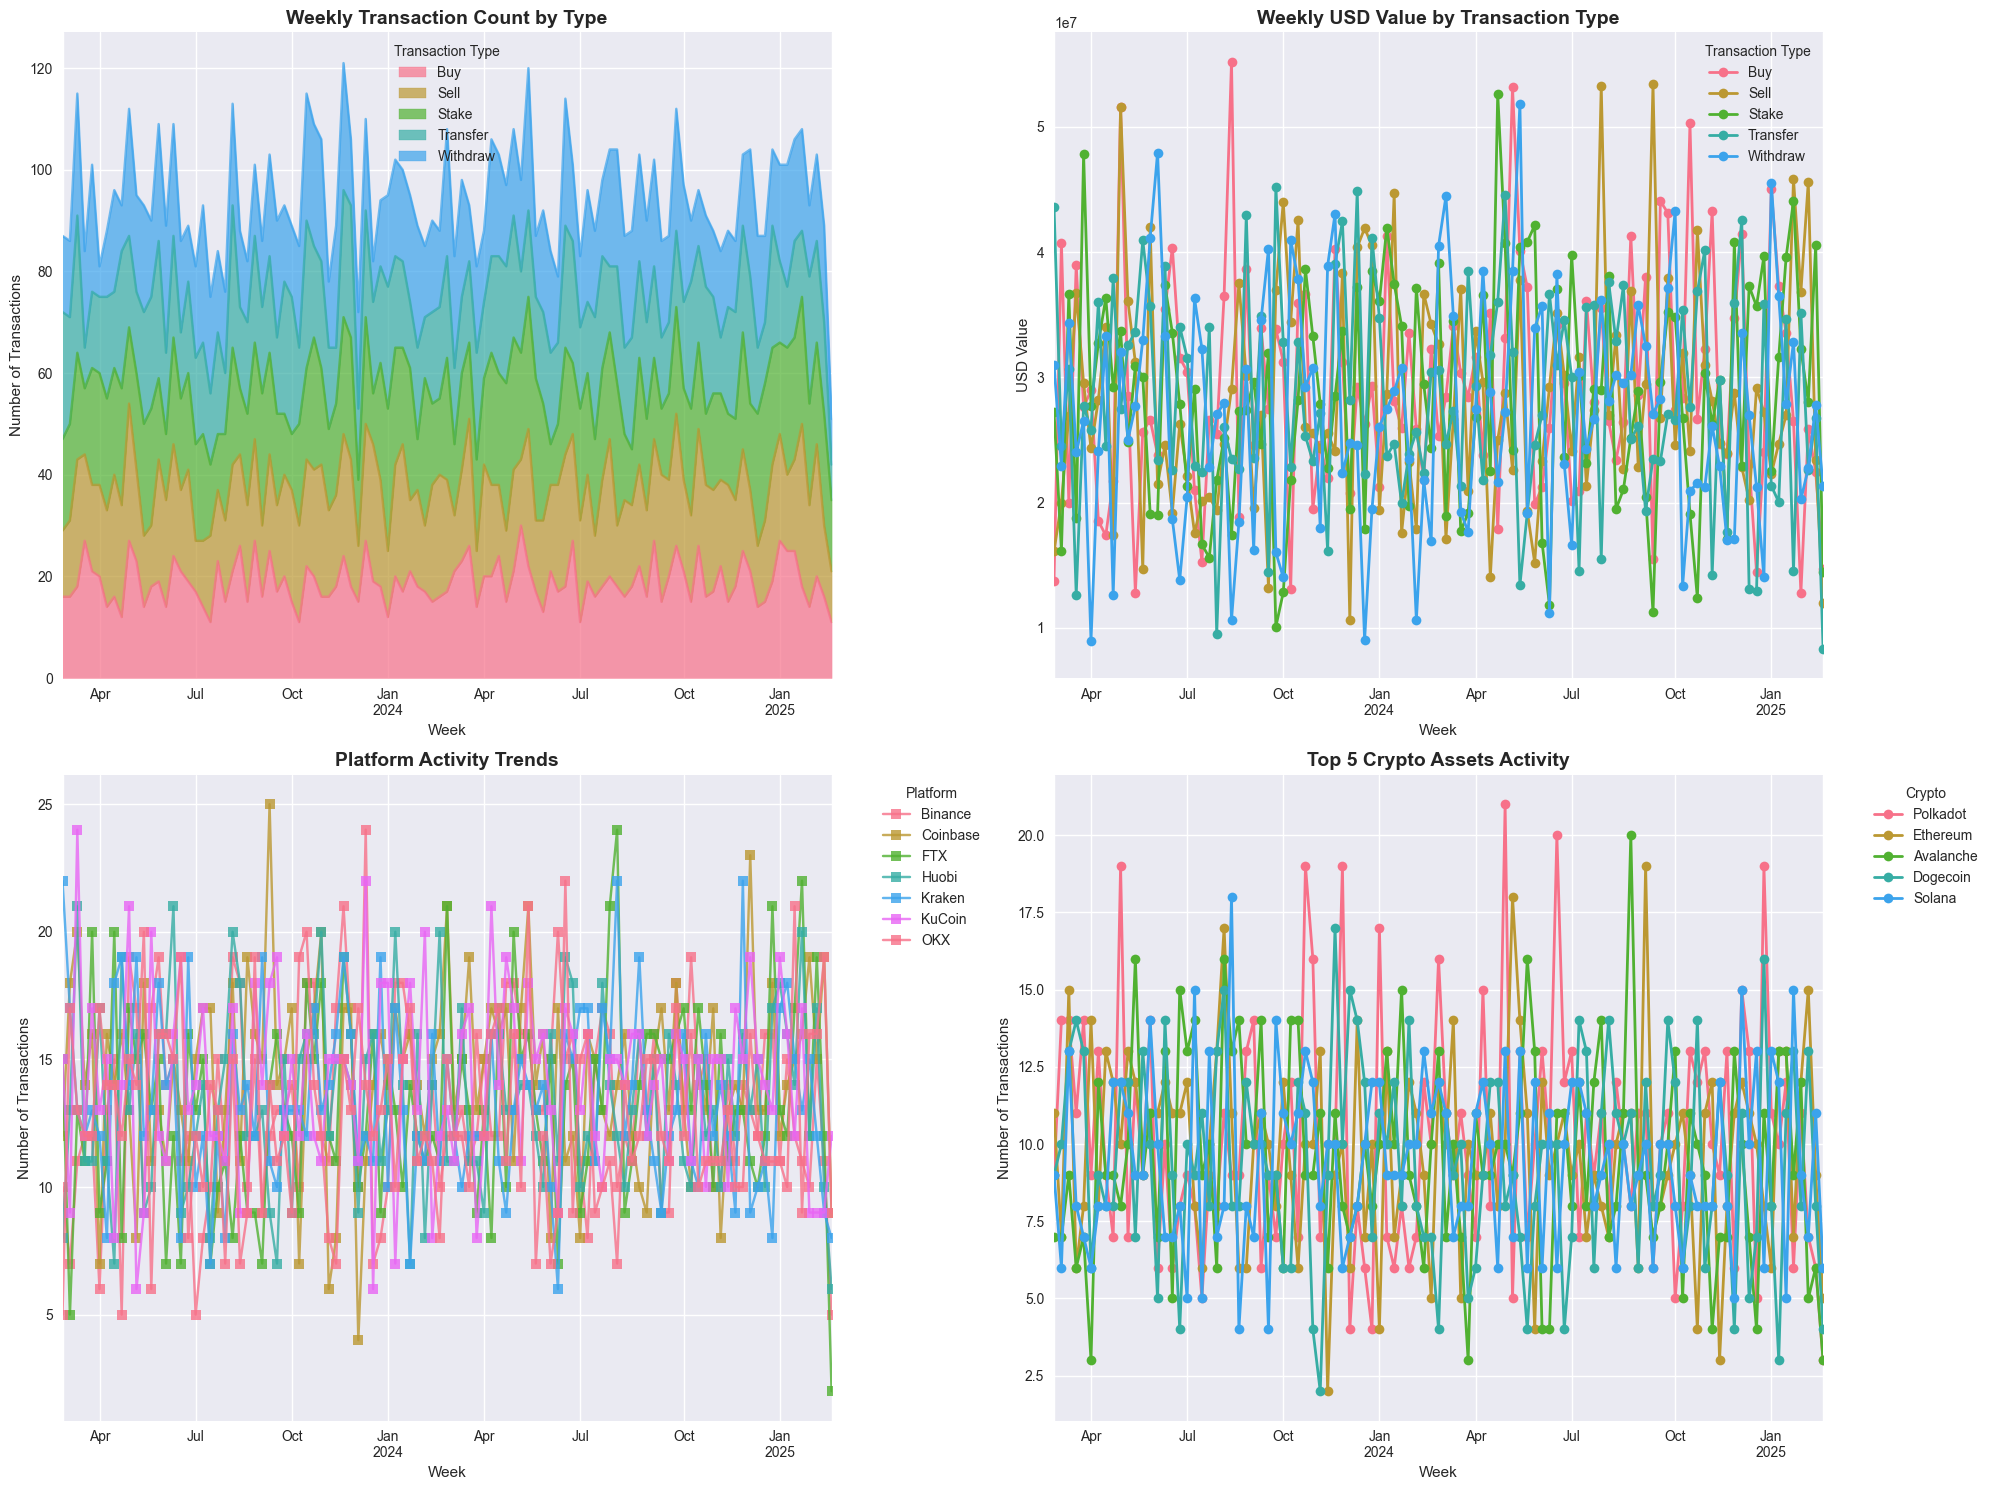

2️⃣ Calculating KPIs...


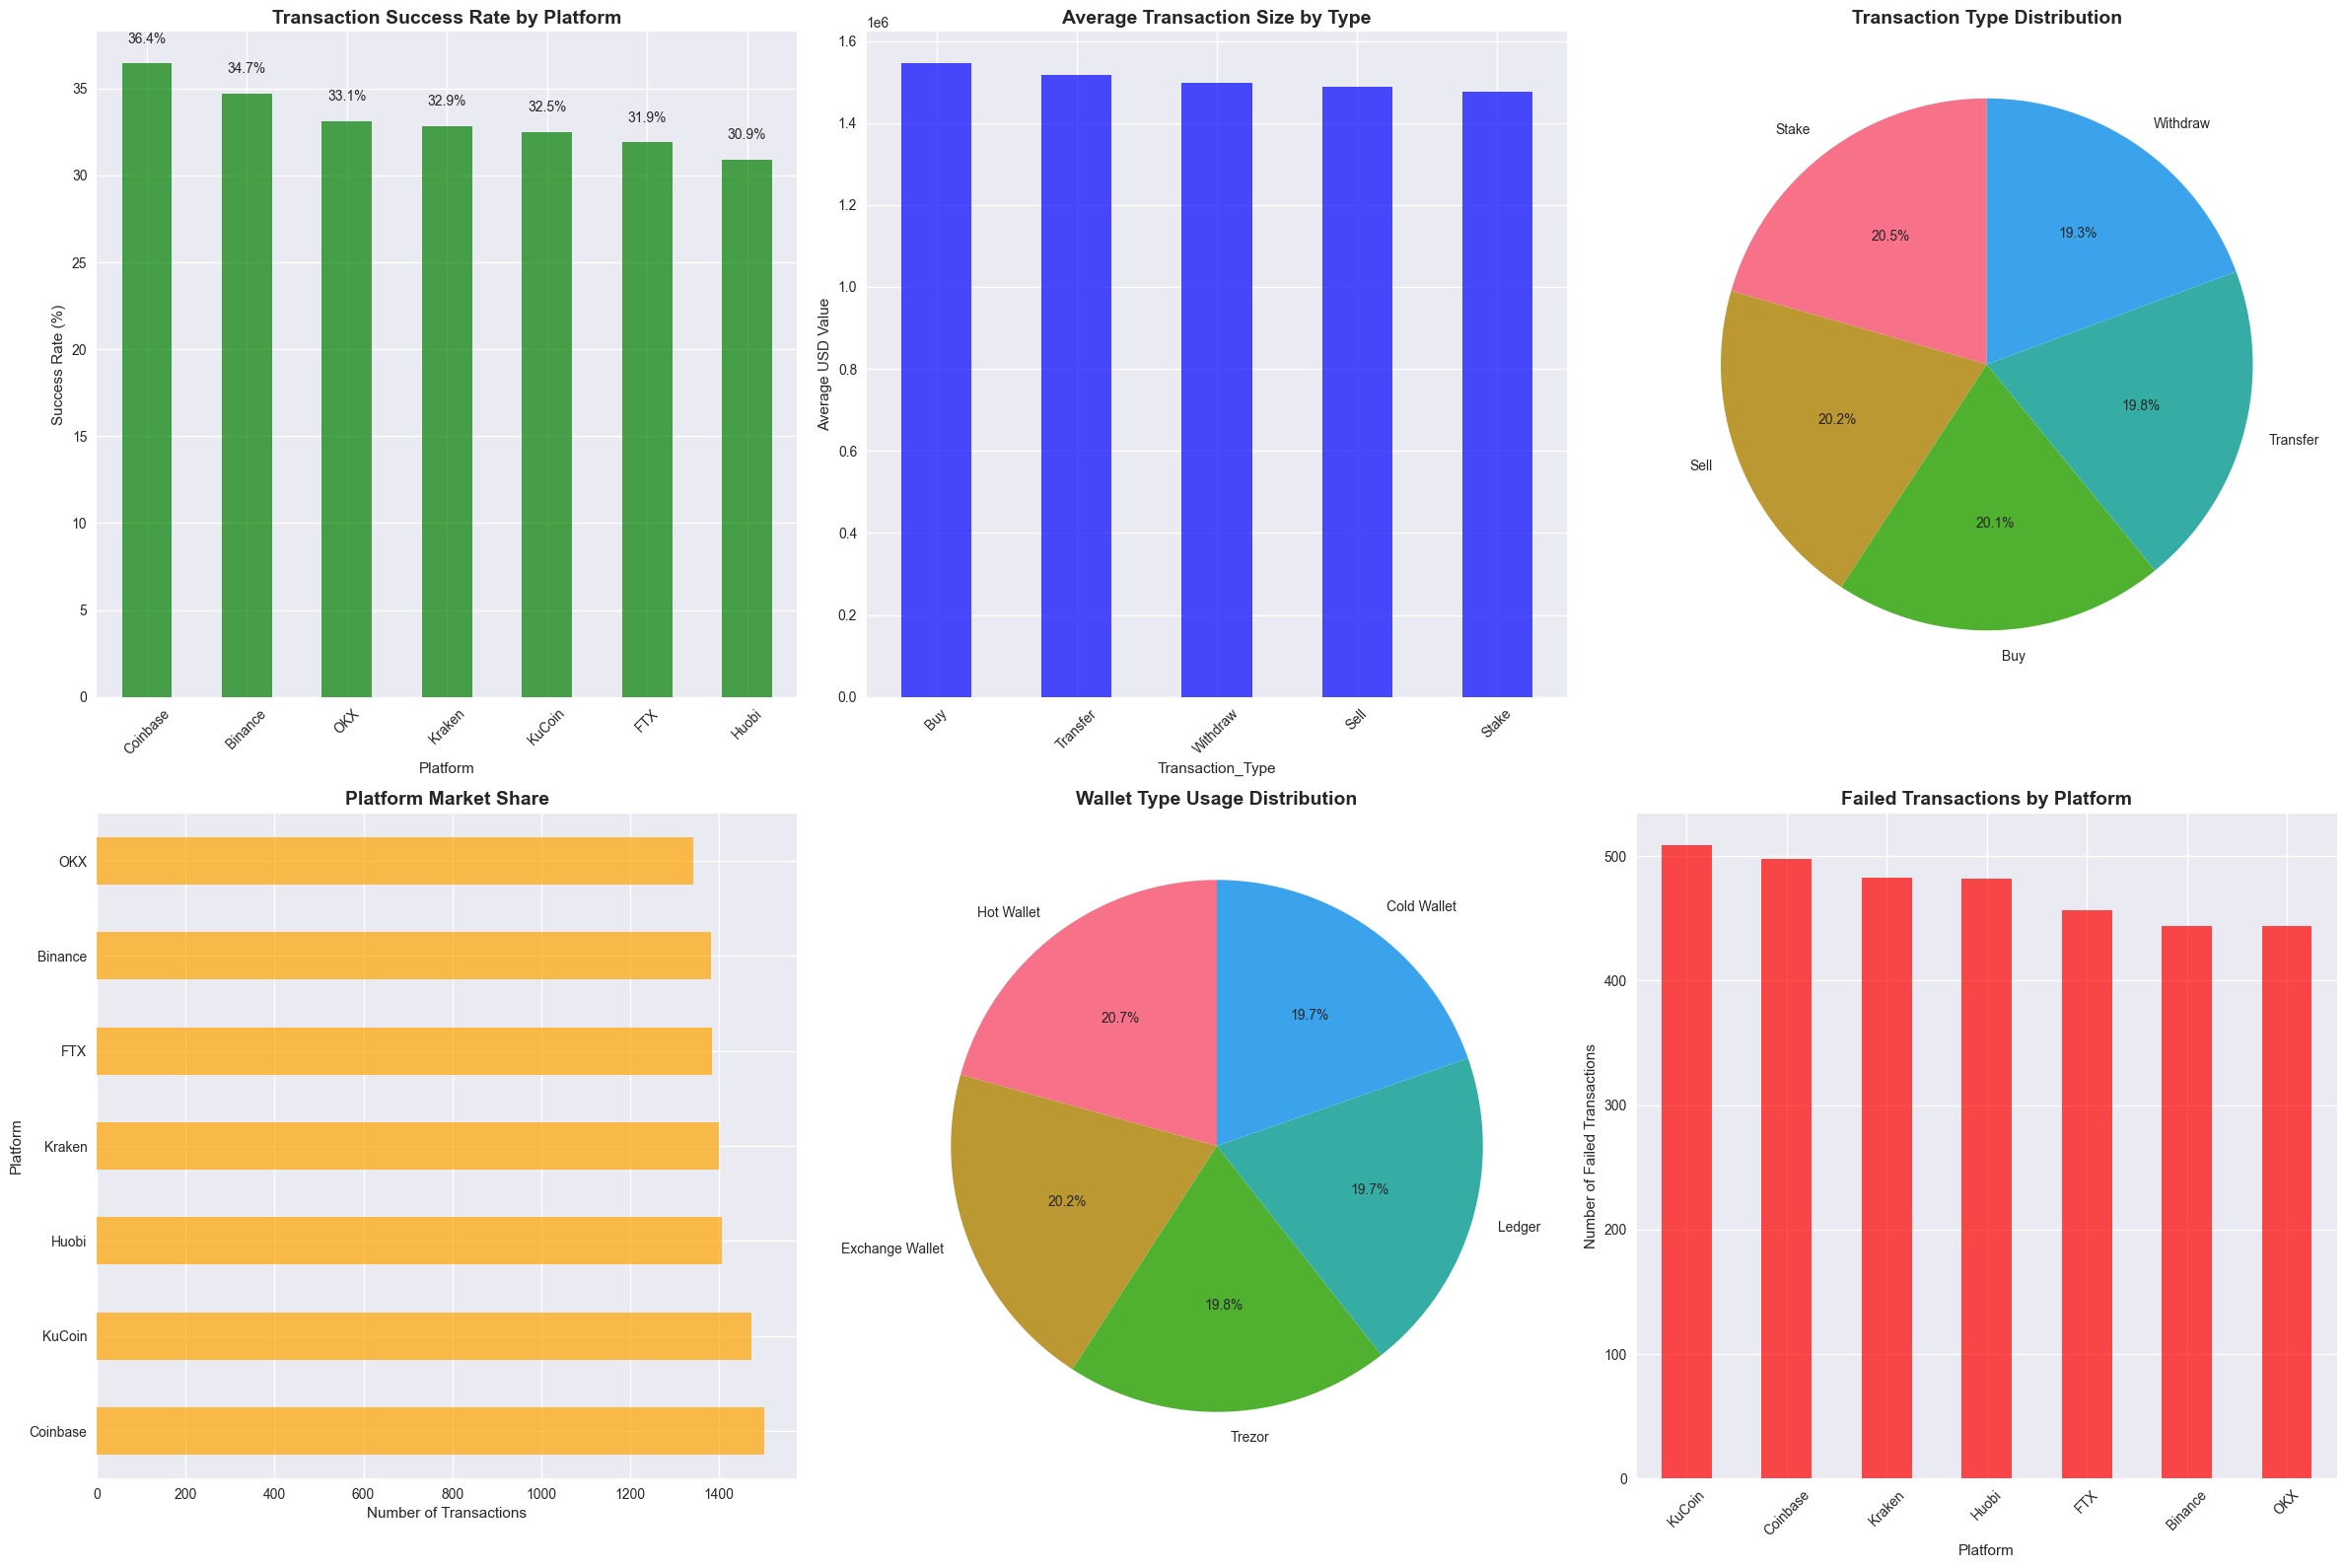

3️⃣ Detecting Outliers...


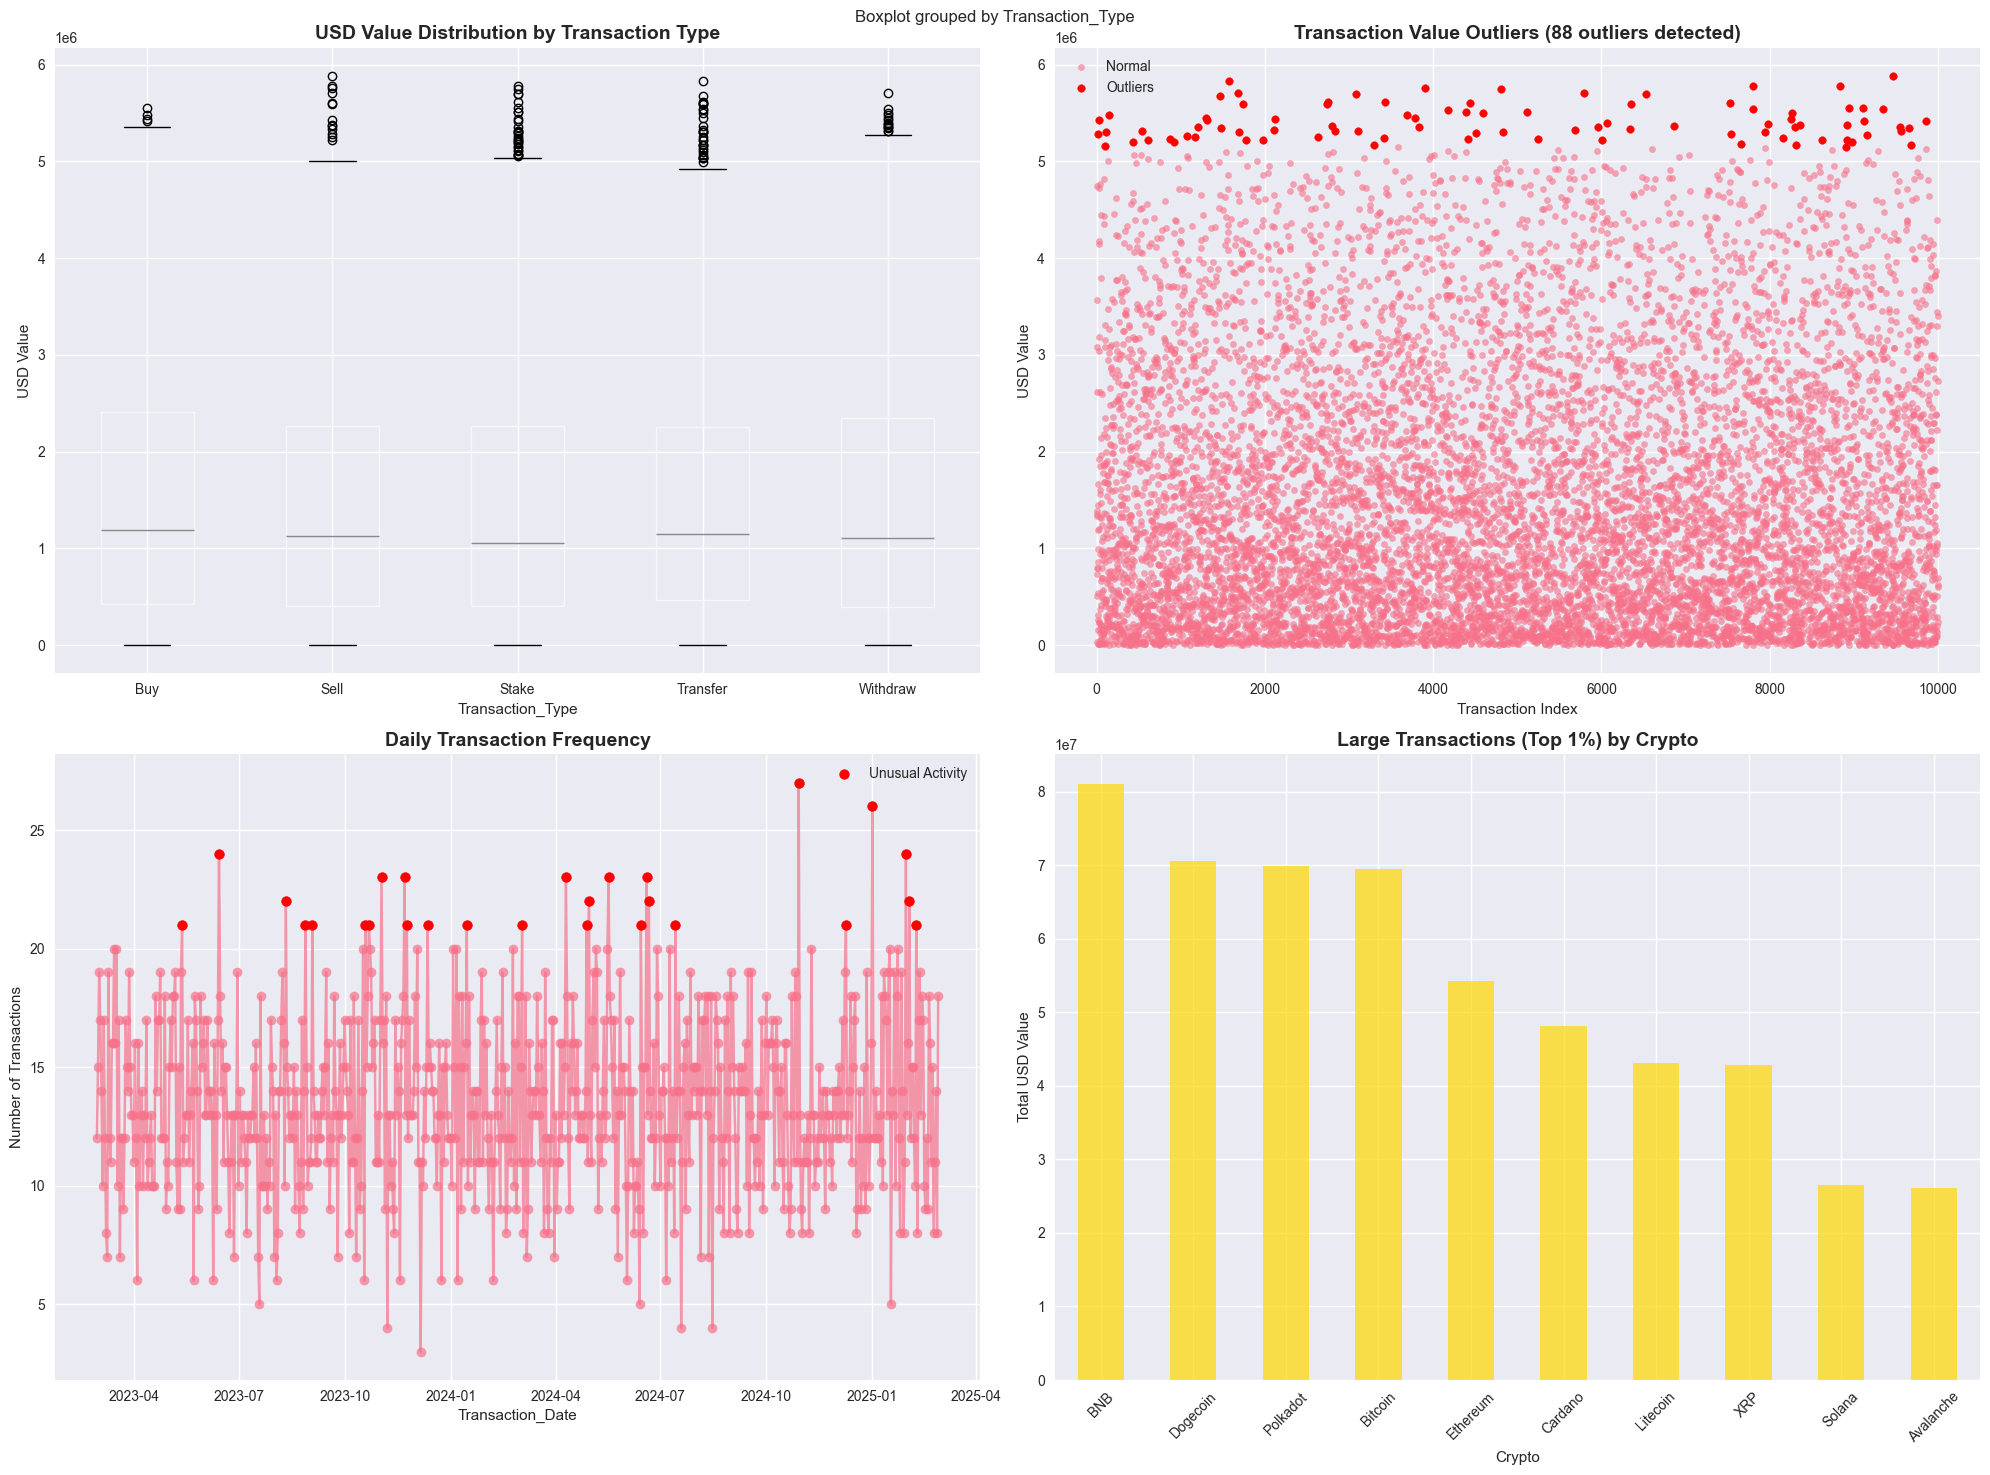

4️⃣ Analyzing Correlations...


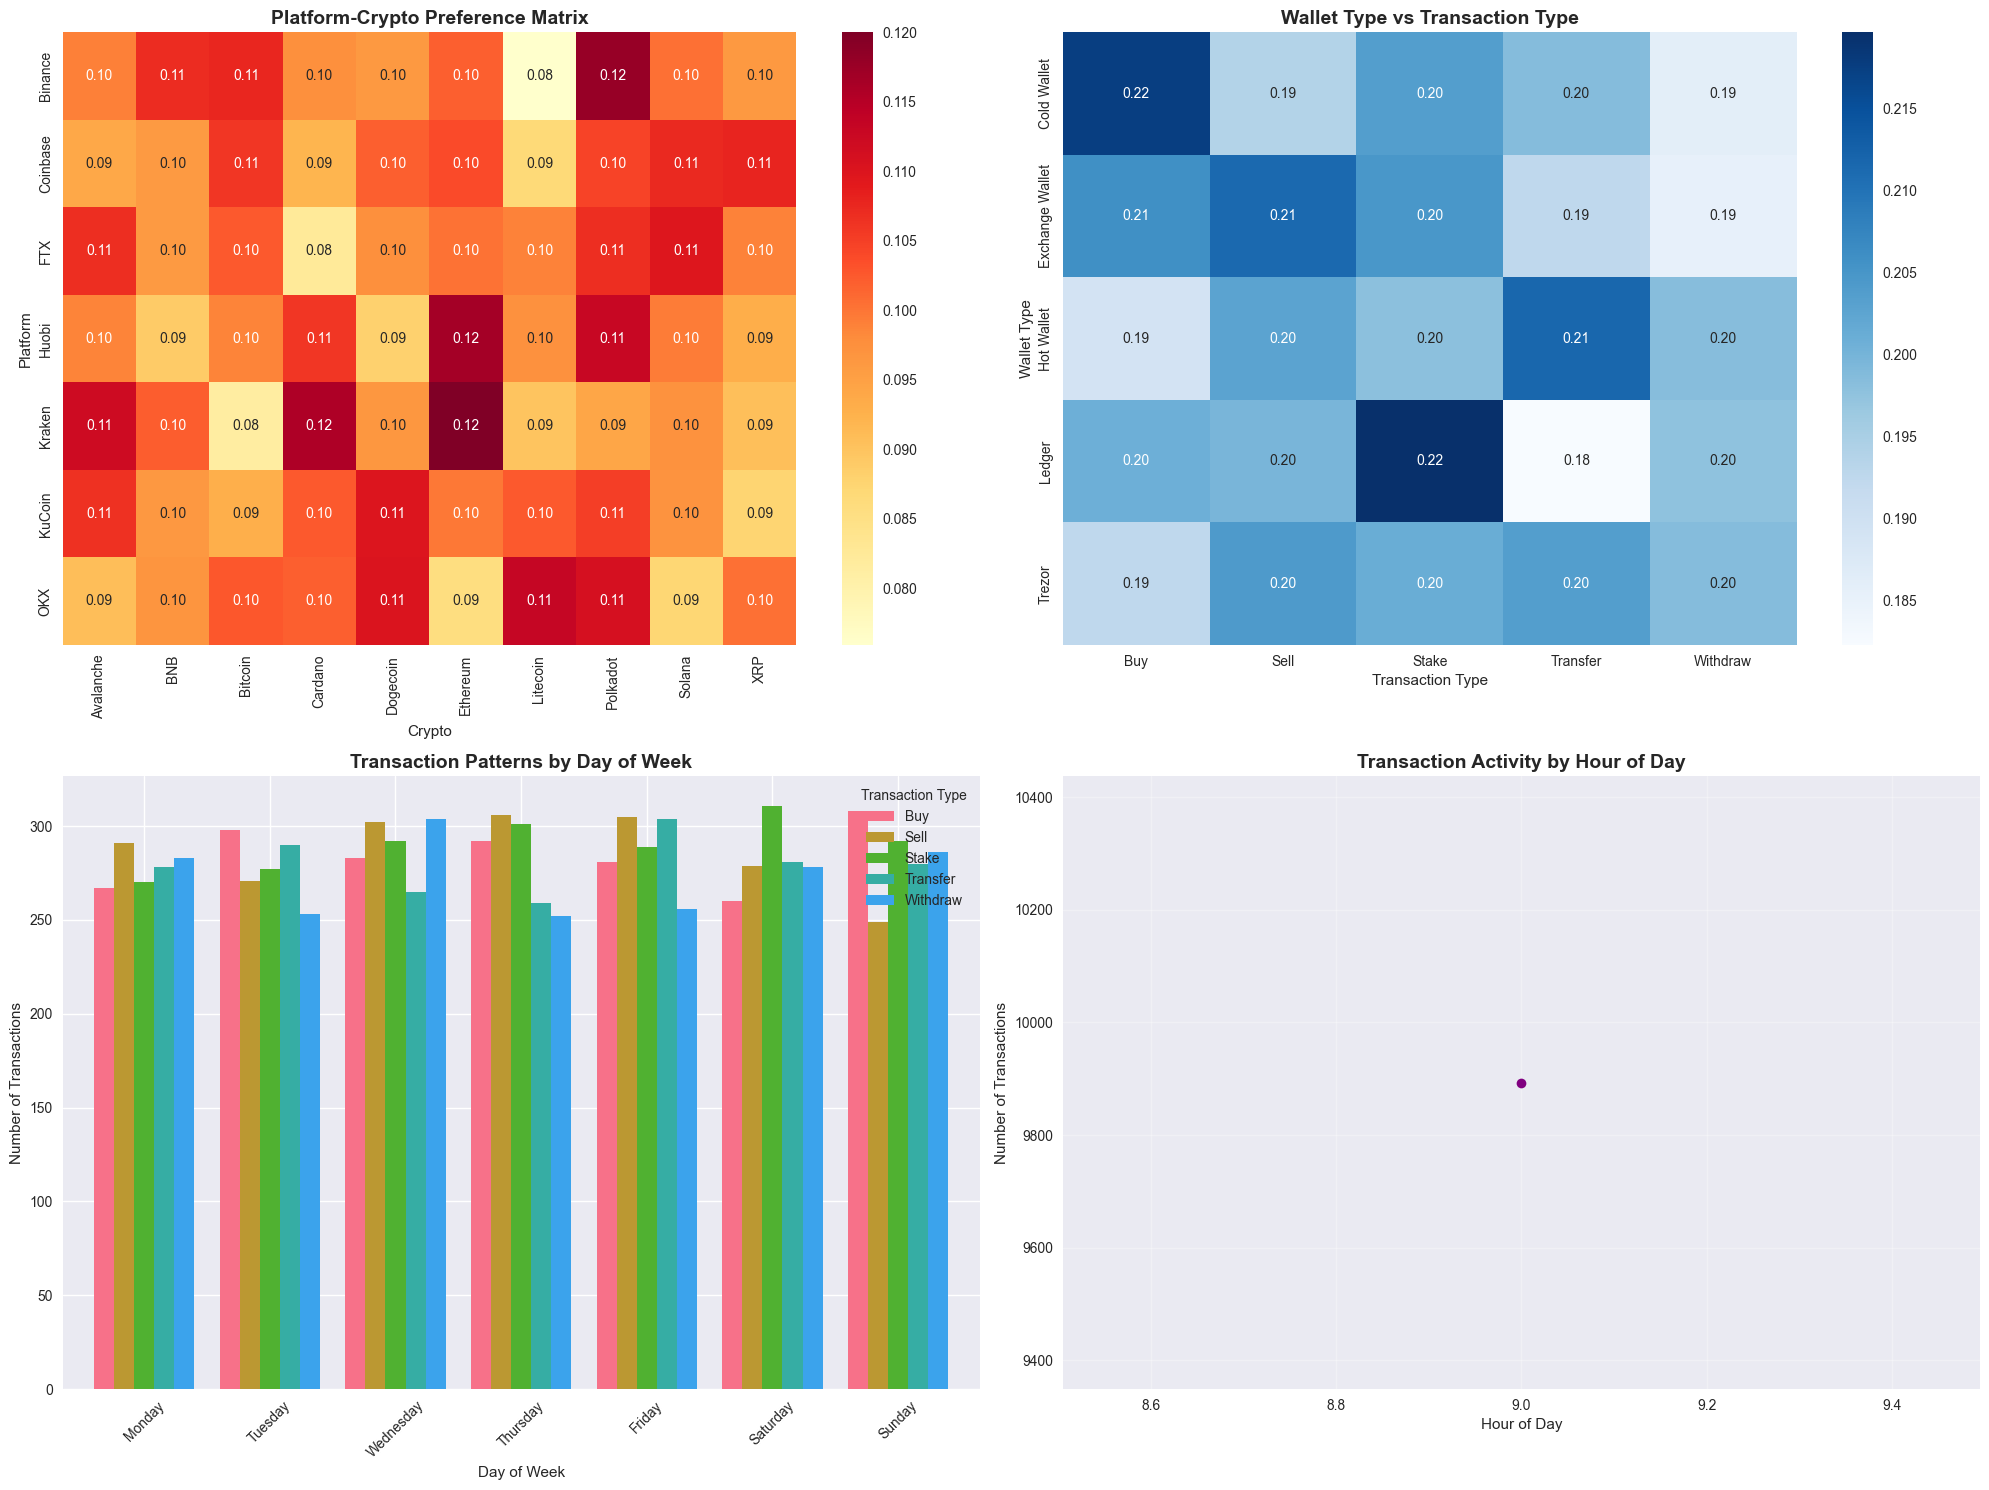

5️⃣ Computing Advanced Metrics...


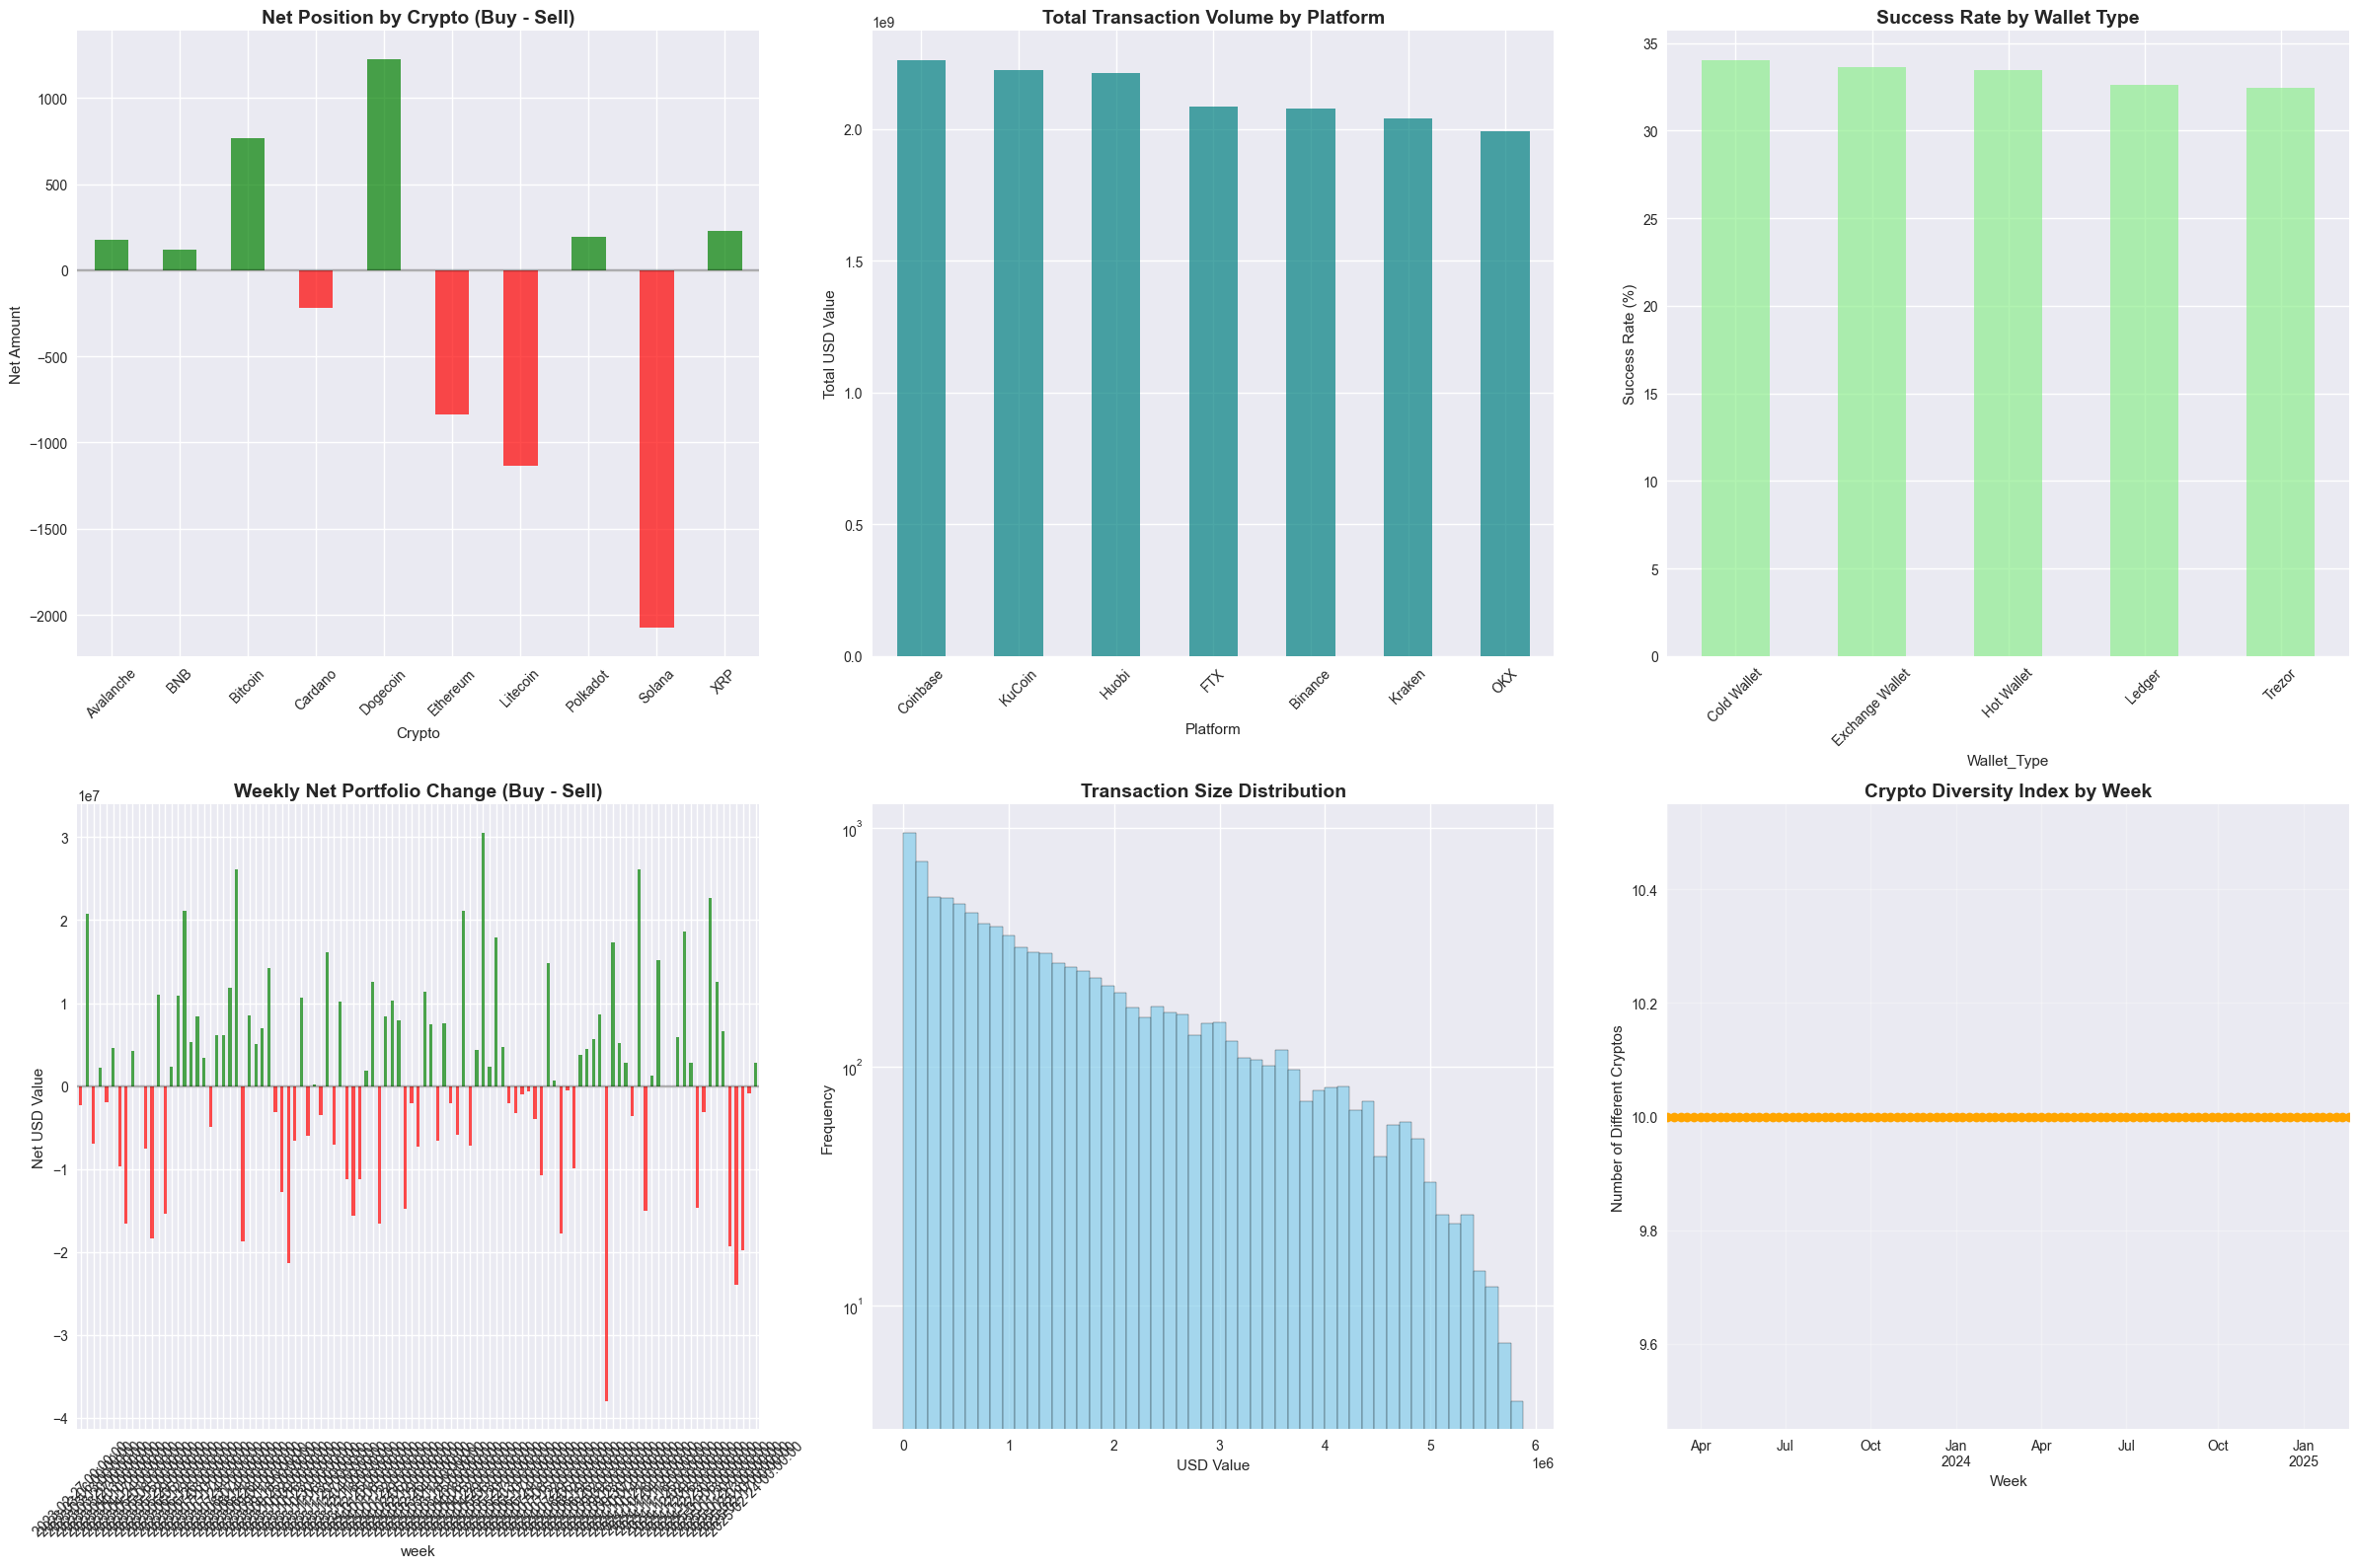

6️⃣ Generating Summary...
COMPREHENSIVE CRYPTO TRANSACTIONS ANALYSIS SUMMARY

📊 BASIC STATISTICS:
Total Transactions: 9,893
Total USD Value: $14,891,240,156.23
Average Transaction Size: $1,505,229.98
Transaction_Date Range: 2023-02-28 to 2025-02-27

✅ SUCCESS METRICS:
Overall Success Rate: 33.2%
Failed Transactions: 3317
Pending Transactions: 3288

🏆 TOP PERFORMERS:
Most Active Platform: Coinbase (1501 transactions)
Most Traded Crypto: Polkadot (1063 transactions)
Most Used Wallet: Hot Wallet (2046 transactions)

⚠️  RISK METRICS:
High-Value Transactions (>99th percentile): 99
Largest Transaction: $5,881,193.05
Standard Deviation of Transaction Size: $1,323,693.33

✅ Analysis Complete! All visualizations have been generated.


In [16]:
results = run_complete_analysis(df)

# To run individual analyses:
# analyze_trends(df)
# calculate_kpis(df)
# detect_outliers(df)
# analyze_correlations(df)
# advanced_metrics(df)


### Attempt 2 - For general metrics

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# Assuming your aggregated data is in 'agg_monthly_t' as shown in the context
# If you need to recreate it, uncomment the following lines:
"""
agg_monthly_t = (
    df.groupby(['month', 'Platform', 'Transaction_Type', 'Crypto', 'Wallet_Type', 'Status'])
    .agg(
        Transaction_Count=('Transaction_ID', 'count'),
        Total_Value=('Total_Value', 'sum'),
        Avg_Value=('Total_Value', 'mean'),
        Avg_Fee_Pct=('Fee_%', 'mean'),
        Total_Fees=('Transaction_Fee', 'sum'),
        Unique_Users=('User_ID', 'nunique'),
    )
    .reset_index()
)

monthly_unique_users = (
    df.groupby('month')['User_ID']
    .nunique()
    .reset_index()
    .rename(columns={'User_ID': 'Total_Monthly_Unique_Users'})
)

agg_monthly_t = agg_monthly_t.merge(monthly_unique_users, on='month', how='left')
"""

# ============================================================================
# 1. OVERALL MARKET TRENDS - Monthly Time Series
# ============================================================================

def create_overall_trends():
    """Create comprehensive monthly trend analysis"""
    
    # Aggregate by month for overall trends
    monthly_summary = agg_monthly_t.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Fees': 'sum',
        'Unique_Users': 'sum',
        'Total_Monthly_Unique_Users': 'first'
    }).reset_index()
    
    # Calculate additional metrics
    monthly_summary['Avg_Transaction_Value'] = monthly_summary['Total_Value'] / monthly_summary['Transaction_Count']
    monthly_summary['Fee_as_Pct_of_Value'] = (monthly_summary['Total_Fees'] / monthly_summary['Total_Value']) * 100
    monthly_summary['Transactions_Per_User'] = monthly_summary['Transaction_Count'] / monthly_summary['Total_Monthly_Unique_Users']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Monthly Cryptocurrency Market Trends Overview', fontsize=16, fontweight='bold')
    
    # Transaction Volume
    axes[0,0].plot(monthly_summary['month'], monthly_summary['Transaction_Count'], 
                   marker='o', linewidth=2, markersize=6)
    axes[0,0].set_title('Monthly Transaction Volume')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].grid(True, alpha=0.3)
    
    # Total Value
    axes[0,1].plot(monthly_summary['month'], monthly_summary['Total_Value']/1e6, 
                   marker='o', linewidth=2, markersize=6, color='green')
    axes[0,1].set_title('Monthly Total Transaction Value')
    axes[0,1].set_ylabel('Value (Millions)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Average Transaction Value
    axes[0,2].plot(monthly_summary['month'], monthly_summary['Avg_Transaction_Value'], 
                   marker='o', linewidth=2, markersize=6, color='orange')
    axes[0,2].set_title('Monthly Average Transaction Value')
    axes[0,2].set_ylabel('Average Value')
    axes[0,2].grid(True, alpha=0.3)
    
    # Active Users
    axes[1,0].plot(monthly_summary['month'], monthly_summary['Total_Monthly_Unique_Users'], 
                   marker='o', linewidth=2, markersize=6, color='purple')
    axes[1,0].set_title('Monthly Active Users')
    axes[1,0].set_ylabel('Number of Users')
    axes[1,0].grid(True, alpha=0.3)
    
    # Fee Analysis
    axes[1,1].plot(monthly_summary['month'], monthly_summary['Fee_as_Pct_of_Value'], 
                   marker='o', linewidth=2, markersize=6, color='red')
    axes[1,1].set_title('Monthly Fee Percentage')
    axes[1,1].set_ylabel('Fee as % of Value')
    axes[1,1].grid(True, alpha=0.3)
    
    # Transactions per User
    axes[1,2].plot(monthly_summary['month'], monthly_summary['Transactions_Per_User'], 
                   marker='o', linewidth=2, markersize=6, color='brown')
    axes[1,2].set_title('Monthly Transactions per User')
    axes[1,2].set_ylabel('Transactions per User')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return monthly_summary

# ============================================================================
# 2. PLATFORM ANALYSIS
# ============================================================================

def analyze_platforms():
    """Analyze platform performance over time"""
    
    platform_monthly = agg_monthly_t.groupby(['month', 'Platform']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    # Market share evolution
    platform_monthly['Market_Share'] = platform_monthly.groupby('month')['Transaction_Count'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    # Create pivot tables for plotting
    platform_volume = platform_monthly.pivot(index='month', columns='Platform', values='Transaction_Count')
    platform_value = platform_monthly.pivot(index='month', columns='Platform', values='Total_Value')
    platform_share = platform_monthly.pivot(index='month', columns='Platform', values='Market_Share')
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Platform Analysis - Monthly Trends', fontsize=16, fontweight='bold')
    
    # Transaction volume by platform
    for platform in platform_volume.columns:
        axes[0,0].plot(platform_volume.index, platform_volume[platform], 
                      marker='o', label=platform, linewidth=2)
    axes[0,0].set_title('Monthly Transaction Volume by Platform')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Transaction value by platform
    for platform in platform_value.columns:
        axes[0,1].plot(platform_value.index, platform_value[platform]/1e6, 
                      marker='o', label=platform, linewidth=2)
    axes[0,1].set_title('Monthly Transaction Value by Platform')
    axes[0,1].set_ylabel('Value (Millions)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Market share evolution
    axes[1,0].stackplot(platform_share.index, 
                       *[platform_share[col] for col in platform_share.columns],
                       labels=platform_share.columns, alpha=0.7)
    axes[1,0].set_title('Platform Market Share Evolution')
    axes[1,0].set_ylabel('Market Share (%)')
    axes[1,0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1,0].grid(True, alpha=0.3)
    
    # Platform comparison - latest month
    latest_month = platform_monthly['month'].max()
    latest_data = platform_monthly[platform_monthly['month'] == latest_month]
    
    axes[1,1].bar(latest_data['Platform'], latest_data['Transaction_Count'])
    axes[1,1].set_title(f'Platform Transaction Volume - {latest_month}')
    axes[1,1].set_ylabel('Number of Transactions')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return platform_monthly

# ============================================================================
# 3. CRYPTOCURRENCY ANALYSIS
# ============================================================================

def analyze_cryptocurrencies():
    """Analyze cryptocurrency trends"""
    
    crypto_monthly = agg_monthly_t.groupby(['month', 'Crypto']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    # Calculate dominance
    crypto_monthly['Volume_Dominance'] = crypto_monthly.groupby('month')['Transaction_Count'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    crypto_monthly['Value_Dominance'] = crypto_monthly.groupby('month')['Total_Value'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    # Top 5 cryptocurrencies by volume
    top_cryptos = crypto_monthly.groupby('Crypto')['Transaction_Count'].sum().nlargest(5).index
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Cryptocurrency Analysis - Monthly Trends', fontsize=16, fontweight='bold')
    
    # Transaction volume for top cryptocurrencies
    for crypto in top_cryptos:
        crypto_data = crypto_monthly[crypto_monthly['Crypto'] == crypto]
        axes[0,0].plot(crypto_data['month'], crypto_data['Transaction_Count'], 
                      marker='o', label=crypto, linewidth=2)
    axes[0,0].set_title('Monthly Transaction Volume - Top 5 Cryptocurrencies')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Value trends for top cryptocurrencies
    for crypto in top_cryptos:
        crypto_data = crypto_monthly[crypto_monthly['Crypto'] == crypto]
        axes[0,1].plot(crypto_data['month'], crypto_data['Total_Value']/1e6, 
                      marker='o', label=crypto, linewidth=2)
    axes[0,1].set_title('Monthly Transaction Value - Top 5 Cryptocurrencies')
    axes[0,1].set_ylabel('Value (Millions)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Dominance evolution (volume)
    crypto_pivot = crypto_monthly.pivot(index='month', columns='Crypto', values='Volume_Dominance')
    top_crypto_pivot = crypto_pivot[top_cryptos]
    
    axes[1,0].stackplot(top_crypto_pivot.index, 
                       *[top_crypto_pivot[col] for col in top_crypto_pivot.columns],
                       labels=top_crypto_pivot.columns, alpha=0.7)
    axes[1,0].set_title('Cryptocurrency Volume Dominance Evolution - Top 5')
    axes[1,0].set_ylabel('Volume Dominance (%)')
    axes[1,0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1,0].grid(True, alpha=0.3)
    
    # Latest month comparison
    latest_month = crypto_monthly['month'].max()
    latest_crypto = crypto_monthly[crypto_monthly['month'] == latest_month].nlargest(10, 'Transaction_Count')
    
    axes[1,1].barh(latest_crypto['Crypto'], latest_crypto['Transaction_Count'])
    axes[1,1].set_title(f'Cryptocurrency Transaction Volume - {latest_month}')
    axes[1,1].set_xlabel('Number of Transactions')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return crypto_monthly

# ============================================================================
# 4. TRANSACTION TYPE ANALYSIS
# ============================================================================

def analyze_transaction_types():
    """Analyze transaction types and their trends"""
    
    tx_type_monthly = agg_monthly_t.groupby(['month', 'Transaction_Type']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    # Calculate percentages
    tx_type_monthly['Volume_Pct'] = tx_type_monthly.groupby('month')['Transaction_Count'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    tx_type_pivot = tx_type_monthly.pivot(index='month', columns='Transaction_Type', values='Transaction_Count')
    tx_value_pivot = tx_type_monthly.pivot(index='month', columns='Transaction_Type', values='Total_Value')
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Transaction Type Analysis - Monthly Trends', fontsize=16, fontweight='bold')
    
    # Transaction volume by type
    for tx_type in tx_type_pivot.columns:
        axes[0,0].plot(tx_type_pivot.index, tx_type_pivot[tx_type], 
                      marker='o', label=tx_type, linewidth=2)
    axes[0,0].set_title('Monthly Transaction Volume by Type')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Transaction value by type
    for tx_type in tx_value_pivot.columns:
        axes[0,1].plot(tx_value_pivot.index, tx_value_pivot[tx_type]/1e6, 
                      marker='o', label=tx_type, linewidth=2)
    axes[0,1].set_title('Monthly Transaction Value by Type')
    axes[0,1].set_ylabel('Value (Millions)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Stacked area chart for transaction composition
    axes[1,0].stackplot(tx_type_pivot.index, 
                       *[tx_type_pivot[col] for col in tx_type_pivot.columns],
                       labels=tx_type_pivot.columns, alpha=0.7)
    axes[1,0].set_title('Transaction Type Composition Over Time')
    axes[1,0].set_ylabel('Number of Transactions')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Average transaction value by type
    tx_type_avg = tx_type_monthly.copy()
    tx_type_avg['Avg_Value'] = tx_type_avg['Total_Value'] / tx_type_avg['Transaction_Count']
    
    for tx_type in tx_type_avg['Transaction_Type'].unique():
        type_data = tx_type_avg[tx_type_avg['Transaction_Type'] == tx_type]
        axes[1,1].plot(type_data['month'], type_data['Avg_Value'], 
                      marker='o', label=tx_type, linewidth=2)
    axes[1,1].set_title('Average Transaction Value by Type')
    axes[1,1].set_ylabel('Average Value')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return tx_type_monthly

# ============================================================================
# 5. WALLET TYPE ANALYSIS
# ============================================================================

def analyze_wallet_types():
    """Analyze wallet type preferences and trends"""
    
    wallet_monthly = agg_monthly_t.groupby(['month', 'Wallet_Type']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    wallet_pivot = wallet_monthly.pivot(index='month', columns='Wallet_Type', values='Transaction_Count')
    wallet_value_pivot = wallet_monthly.pivot(index='month', columns='Wallet_Type', values='Total_Value')
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Wallet Type Analysis - Monthly Trends', fontsize=16, fontweight='bold')
    
    # Transaction volume by wallet type
    for wallet in wallet_pivot.columns:
        axes[0,0].plot(wallet_pivot.index, wallet_pivot[wallet], 
                      marker='o', label=wallet, linewidth=2)
    axes[0,0].set_title('Monthly Transaction Volume by Wallet Type')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Transaction value by wallet type
    for wallet in wallet_value_pivot.columns:
        axes[0,1].plot(wallet_value_pivot.index, wallet_value_pivot[wallet]/1e6, 
                      marker='o', label=wallet, linewidth=2)
    axes[0,1].set_title('Monthly Transaction Value by Wallet Type')
    axes[0,1].set_ylabel('Value (Millions)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Wallet type market share
    wallet_pct = wallet_monthly.copy()
    wallet_pct['Market_Share'] = wallet_pct.groupby('month')['Transaction_Count'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    wallet_pct_pivot = wallet_pct.pivot(index='month', columns='Wallet_Type', values='Market_Share')
    
    axes[1,0].stackplot(wallet_pct_pivot.index, 
                       *[wallet_pct_pivot[col] for col in wallet_pct_pivot.columns],
                       labels=wallet_pct_pivot.columns, alpha=0.7)
    axes[1,0].set_title('Wallet Type Market Share Evolution')
    axes[1,0].set_ylabel('Market Share (%)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Security preference trends (Cold vs Hot wallets)
    security_monthly = wallet_monthly.copy()
    security_monthly['Security_Type'] = security_monthly['Wallet_Type'].map({
        'Cold Wallet': 'Cold Storage',
        'Hot Wallet': 'Hot Storage',
        'Ledger': 'Hardware',
        'Trezor': 'Hardware',
        'Exchange Wallet': 'Exchange'
    })
    
    security_agg = security_monthly.groupby(['month', 'Security_Type']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    security_pivot = security_agg.pivot(index='month', columns='Security_Type', values='Transaction_Count')
    
    for security in security_pivot.columns:
        axes[1,1].plot(security_pivot.index, security_pivot[security], 
                      marker='o', label=security, linewidth=2)
    axes[1,1].set_title('Security Preference Trends')
    axes[1,1].set_ylabel('Number of Transactions')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return wallet_monthly

# ============================================================================
# 6. TRANSACTION STATUS ANALYSIS
# ============================================================================

def analyze_transaction_status():
    """Analyze transaction success rates and status trends"""
    
    status_monthly = agg_monthly_t.groupby(['month', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    # Calculate success rates
    status_monthly['Success_Rate'] = status_monthly.groupby('month')['Transaction_Count'].transform(
        lambda x: (x / x.sum()) * 100
    )
    
    status_pivot = status_monthly.pivot(index='month', columns='Status', values='Transaction_Count')
    success_pivot = status_monthly.pivot(index='month', columns='Status', values='Success_Rate')
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Transaction Status Analysis - Monthly Trends', fontsize=16, fontweight='bold')
    
    # Transaction count by status
    for status in status_pivot.columns:
        axes[0,0].plot(status_pivot.index, status_pivot[status], 
                      marker='o', label=status, linewidth=2)
    axes[0,0].set_title('Monthly Transaction Count by Status')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Success rate trends
    if 'Completed' in success_pivot.columns:
        axes[0,1].plot(success_pivot.index, success_pivot['Completed'], 
                      marker='o', label='Success Rate', linewidth=2, color='green')
    if 'Failed' in success_pivot.columns:
        axes[0,1].plot(success_pivot.index, success_pivot['Failed'], 
                      marker='o', label='Failure Rate', linewidth=2, color='red')
    axes[0,1].set_title('Monthly Success/Failure Rates')
    axes[0,1].set_ylabel('Percentage (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Stacked area chart
    axes[1,0].stackplot(status_pivot.index, 
                       *[status_pivot[col] for col in status_pivot.columns],
                       labels=status_pivot.columns, alpha=0.7)
    axes[1,0].set_title('Transaction Status Composition')
    axes[1,0].set_ylabel('Number of Transactions')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Platform-wise success rates (latest month)
    platform_status = agg_monthly_t.groupby(['Platform', 'Status']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    platform_status['Total_by_Platform'] = platform_status.groupby('Platform')['Transaction_Count'].transform('sum')
    platform_status['Success_Rate'] = (platform_status['Transaction_Count'] / platform_status['Total_by_Platform']) * 100
    
    completed_rates = platform_status[platform_status['Status'] == 'Completed']
    axes[1,1].bar(completed_rates['Platform'], completed_rates['Success_Rate'])
    axes[1,1].set_title('Platform Success Rates (Overall)')
    axes[1,1].set_ylabel('Success Rate (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return status_monthly

# ============================================================================
# 7. ADVANCED ANALYTICS
# ============================================================================

def advanced_analytics():
    """Perform advanced analytics and create comprehensive insights"""
    
    # Cross-dimensional analysis
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Advanced Analytics - Cross-Dimensional Insights', fontsize=16, fontweight='bold')
    
    # 1. Platform-Crypto heatmap (latest month)
    latest_month = agg_monthly_t['month'].max()
    latest_data = agg_monthly_t[agg_monthly_t['month'] == latest_month]
    
    platform_crypto = latest_data.groupby(['Platform', 'Crypto']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    platform_crypto_pivot = platform_crypto.pivot(index='Platform', columns='Crypto', values='Transaction_Count')
    platform_crypto_pivot = platform_crypto_pivot.fillna(0)
    
    sns.heatmap(platform_crypto_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title(f'Platform-Crypto Transaction Heatmap - {latest_month}')
    
    # 2. Transaction Type vs Wallet Type
    tx_wallet = latest_data.groupby(['Transaction_Type', 'Wallet_Type']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    tx_wallet_pivot = tx_wallet.pivot(index='Transaction_Type', columns='Wallet_Type', values='Transaction_Count')
    tx_wallet_pivot = tx_wallet_pivot.fillna(0)
    
    sns.heatmap(tx_wallet_pivot, annot=True, fmt='.0f', cmap='Blues', ax=axes[0,1])
    axes[0,1].set_title(f'Transaction Type vs Wallet Type - {latest_month}')
    
    # 3. Value vs Volume correlation by crypto
    crypto_metrics = agg_monthly_t.groupby(['month', 'Crypto']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    crypto_metrics['Avg_Value'] = crypto_metrics['Total_Value'] / crypto_metrics['Transaction_Count']
    
    for crypto in crypto_metrics['Crypto'].unique()[:5]:  # Top 5 for clarity
        crypto_data = crypto_metrics[crypto_metrics['Crypto'] == crypto]
        axes[1,0].scatter(crypto_data['Transaction_Count'], crypto_data['Avg_Value'], 
                         label=crypto, alpha=0.7, s=50)
    
    axes[1,0].set_title('Volume vs Average Value by Cryptocurrency')
    axes[1,0].set_xlabel('Transaction Count')
    axes[1,0].set_ylabel('Average Transaction Value')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. User engagement trends
    user_metrics = agg_monthly_t.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Monthly_Unique_Users': 'first'
    }).reset_index()
    
    user_metrics['Transactions_Per_User'] = user_metrics['Transaction_Count'] / user_metrics['Total_Monthly_Unique_Users']
    
    ax2 = axes[1,1].twinx()
    
    line1 = axes[1,1].plot(user_metrics['month'], user_metrics['Total_Monthly_Unique_Users'], 
                          'b-', marker='o', label='Active Users')
    line2 = ax2.plot(user_metrics['month'], user_metrics['Transactions_Per_User'], 
                     'r-', marker='s', label='Transactions per User')
    
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Active Users', color='b')
    ax2.set_ylabel('Transactions per User', color='r')
    axes[1,1].set_title('User Engagement Metrics')
    axes[1,1].grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    axes[1,1].legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 8. SUMMARY STATISTICS AND INSIGHTS
# ============================================================================

def generate_insights():
    """Generate key insights and summary statistics"""
    
    print("="*80)
    print("CRYPTOCURRENCY TRANSACTION ANALYSIS - KEY INSIGHTS")
    print("="*80)
    
    # Overall statistics
    total_transactions = agg_monthly_t['Transaction_Count'].sum()
    total_value = agg_monthly_t['Total_Value'].sum()
    total_fees = agg_monthly_t['Total_Fees'].sum()
    
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"Total Transactions: {total_transactions:,}")
    print(f"Total Value: ${total_value:,.2f}")
    print(f"Total Fees: ${total_fees:,.2f}")
    print(f"Average Transaction Value: ${total_value/total_transactions:,.2f}")
    print(f"Average Fee Rate: {(total_fees/total_value)*100:.3f}%")
    
    # Monthly growth analysis
    monthly_summary = agg_monthly_t.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Monthly_Unique_Users': 'first'
    }).reset_index().sort_values('month')
    
    if len(monthly_summary) > 1:
        latest_month = monthly_summary.iloc[-1]
        previous_month = monthly_summary.iloc[-2]
        
        tx_growth = ((latest_month['Transaction_Count'] - previous_month['Transaction_Count']) / 
                    previous_month['Transaction_Count']) * 100
        value_growth = ((latest_month['Total_Value'] - previous_month['Total_Value']) / 
                       previous_month['Total_Value']) * 100
        user_growth = ((latest_month['Total_Monthly_Unique_Users'] - previous_month['Total_Monthly_Unique_Users']) / 
                      previous_month['Total_Monthly_Unique_Users']) * 100
        
        print(f"\n📈 MONTH-OVER-MONTH GROWTH:")
        print(f"Transaction Volume: {tx_growth:+.1f}%")
        print(f"Transaction Value: {value_growth:+.1f}%")
        print(f"Active Users: {user_growth:+.1f}%")
    
    # Top performers
    print(f"\n🏆 TOP PERFORMERS:")
    
    # Top platforms
    top_platforms = agg_monthly_t.groupby('Platform').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index().sort_values('Transaction_Count', ascending=False)
    
    print("Top 3 Platforms by Volume:")
    for i, row in top_platforms.head(3).iterrows():
        print(f"  {row['Platform']}: {row['Transaction_Count']:,} transactions (${row['Total_Value']:,.0f})")
    
    # Top cryptocurrencies
    top_cryptos = agg_monthly_t.groupby('Crypto').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index().sort_values('Transaction_Count', ascending=False)
    
    print("\nTop 3 Cryptocurrencies by Volume:")
    for i, row in top_cryptos.head(3).iterrows():
        print(f"  {row['Crypto']}: {row['Transaction_Count']:,} transactions (${row['Total_Value']:,.0f})")
    
    # Transaction type distribution
    tx_types = agg_monthly_t.groupby('Transaction_Type').agg({
        'Transaction_Count': 'sum'
    }).reset_index().sort_values('Transaction_Count', ascending=False)
    
    print("\nTransaction Type Distribution:")
    total_tx = tx_types['Transaction_Count'].sum()
    for i, row in tx_types.iterrows():
        pct = (row['Transaction_Count'] / total_tx) * 100
        print(f"  {row['Transaction_Type']}: {row['Transaction_Count']:,} ({pct:.1f}%)")
    
    # Wallet type preferences
    wallet_types = agg_monthly_t.groupby('Wallet_Type').agg({
        'Transaction_Count': 'sum'
    }).reset_index().sort_values('Transaction_Count', ascending=False)
    
    print("\nWallet Type Preferences:")
    for i, row in wallet_types.iterrows():
        pct = (row['Transaction_Count'] / total_tx) * 100
        print(f"  {row['Wallet_Type']}: {row['Transaction_Count']:,} ({pct:.1f}%)")
    
    # Success rate analysis
    status_summary = agg_monthly_t.groupby('Status').agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    print("\n✅ TRANSACTION SUCCESS RATES:")
    total_status = status_summary['Transaction_Count'].sum()
    for i, row in status_summary.iterrows():
        pct = (row['Transaction_Count'] / total_status) * 100
        print(f"  {row['Status']}: {pct:.1f}%")
    
    # Risk and security insights
    print(f"\n🔐 SECURITY INSIGHTS:")
    
    # Hardware wallet usage
    hardware_wallets = agg_monthly_t[agg_monthly_t['Wallet_Type'].isin(['Ledger', 'Trezor'])]
    hardware_tx = hardware_wallets['Transaction_Count'].sum()
    hardware_pct = (hardware_tx / total_transactions) * 100
    print(f"Hardware Wallet Usage: {hardware_pct:.1f}% of all transactions")
    
    # Cold storage usage
    cold_storage = agg_monthly_t[agg_monthly_t['Wallet_Type'] == 'Cold Wallet']
    cold_tx = cold_storage['Transaction_Count'].sum()
    cold_pct = (cold_tx / total_transactions) * 100
    print(f"Cold Storage Usage: {cold_pct:.1f}% of all transactions")
    
    # High-value transaction analysis
    high_value_threshold = agg_monthly_t['Total_Value'].quantile(0.95)
    high_value_data = agg_monthly_t[agg_monthly_t['Total_Value'] >= high_value_threshold]
    
    if len(high_value_data) > 0:
        print(f"\n💰 HIGH-VALUE TRANSACTIONS (Top 5%):")
        print(f"Threshold: ${high_value_threshold:,.2f}")
        print(f"Count: {len(high_value_data)} transaction groups")
        
        hv_platforms = high_value_data.groupby('Platform')['Transaction_Count'].sum().sort_values(ascending=False)
        print(f"Most used platform for high-value: {hv_platforms.index[0]}")
        
        hv_cryptos = high_value_data.groupby('Crypto')['Transaction_Count'].sum().sort_values(ascending=False)
        print(f"Most traded crypto in high-value: {hv_cryptos.index[0]}")
    
    print("\n" + "="*80)

# ============================================================================
# 9. MAIN EXECUTION FUNCTION
# ============================================================================

def run_complete_analysis():
    """Run the complete analysis pipeline"""
    
    print("Starting Comprehensive Cryptocurrency Transaction Analysis...")
    print("="*80)
    
    try:
        # 1. Overall trends analysis
        print("\n1. Analyzing Overall Market Trends...")
        monthly_summary = create_overall_trends()
        
        # 2. Platform analysis
        print("\n2. Analyzing Platform Performance...")
        platform_data = analyze_platforms()
        
        # 3. Cryptocurrency analysis
        print("\n3. Analyzing Cryptocurrency Trends...")
        crypto_data = analyze_cryptocurrencies()
        
        # 4. Transaction type analysis
        print("\n4. Analyzing Transaction Types...")
        tx_type_data = analyze_transaction_types()
        
        # 5. Wallet type analysis
        print("\n5. Analyzing Wallet Types...")
        wallet_data = analyze_wallet_types()
        
        # 6. Transaction status analysis
        print("\n6. Analyzing Transaction Status...")
        status_data = analyze_transaction_status()
        
        # 7. Advanced analytics
        print("\n7. Performing Advanced Analytics...")
        advanced_analytics()
        
        # 8. Generate insights
        print("\n8. Generating Key Insights...")
        generate_insights()
        
        print("\n✅ Analysis Complete! All visualizations have been generated.")
        
        # Return all data for further analysis if needed
        return {
            'monthly_summary': monthly_summary,
            'platform_data': platform_data,
            'crypto_data': crypto_data,
            'tx_type_data': tx_type_data,
            'wallet_data': wallet_data,
            'status_data': status_data
        }
        
    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        print("Please check your data and try again.")
        return None

# ============================================================================
# 10. ADDITIONAL UTILITY FUNCTIONS
# ============================================================================

def create_executive_summary():
    """Create an executive summary dashboard"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle('Executive Summary Dashboard', fontsize=18, fontweight='bold')
    
    # Key metrics over time
    monthly_summary = agg_monthly_t.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Monthly_Unique_Users': 'first',
        'Total_Fees': 'sum'
    }).reset_index()
    
    # 1. Revenue trend (fees)
    axes[0,0].plot(monthly_summary['month'], monthly_summary['Total_Fees'], 
                   marker='o', linewidth=3, markersize=8, color='green')
    axes[0,0].set_title('Monthly Fee Revenue', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Total Fees ($)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].ticklabel_format(style='plain', axis='y')
    
    # 2. User growth
    axes[0,1].plot(monthly_summary['month'], monthly_summary['Total_Monthly_Unique_Users'], 
                   marker='o', linewidth=3, markersize=8, color='blue')
    axes[0,1].set_title('Monthly Active Users', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Number of Users')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Transaction volume
    axes[0,2].plot(monthly_summary['month'], monthly_summary['Transaction_Count'], 
                   marker='o', linewidth=3, markersize=8, color='orange')
    axes[0,2].set_title('Monthly Transaction Volume', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Number of Transactions')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Platform market share (pie chart)
    platform_share = agg_monthly_t.groupby('Platform')['Transaction_Count'].sum().sort_values(ascending=False)
    axes[1,0].pie(platform_share.values, labels=platform_share.index, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Platform Market Share', fontsize=14, fontweight='bold')
    
    # 5. Crypto popularity (bar chart)
    crypto_popularity = agg_monthly_t.groupby('Crypto')['Transaction_Count'].sum().sort_values(ascending=False).head(8)
    axes[1,1].bar(crypto_popularity.index, crypto_popularity.values)
    axes[1,1].set_title('Top Cryptocurrencies by Volume', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Number of Transactions')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Success rate trend
    success_rate_monthly = agg_monthly_t[agg_monthly_t['Status'] == 'Completed'].groupby('month')['Transaction_Count'].sum()
    total_monthly = agg_monthly_t.groupby('month')['Transaction_Count'].sum()
    success_rate = (success_rate_monthly / total_monthly * 100).fillna(0)
    
    axes[1,2].plot(success_rate.index, success_rate.values, 
                   marker='o', linewidth=3, markersize=8, color='red')
    axes[1,2].set_title('Monthly Success Rate', fontsize=14, fontweight='bold')
    axes[1,2].set_ylabel('Success Rate (%)')
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

def export_summary_data():
    """Export summary data for further analysis"""
    
    # Create comprehensive summary tables
    summary_data = {}
    
    # Monthly summary
    summary_data['monthly_summary'] = agg_monthly_t.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Fees': 'sum',
        'Total_Monthly_Unique_Users': 'first'
    }).reset_index()
    
    # Platform summary
    summary_data['platform_summary'] = agg_monthly_t.groupby('Platform').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Fees': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    # Crypto summary
    summary_data['crypto_summary'] = agg_monthly_t.groupby('Crypto').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum',
        'Total_Fees': 'sum',
        'Unique_Users': 'sum'
    }).reset_index()
    
    return summary_data

Starting Comprehensive Cryptocurrency Transaction Analysis...

1. Analyzing Overall Market Trends...


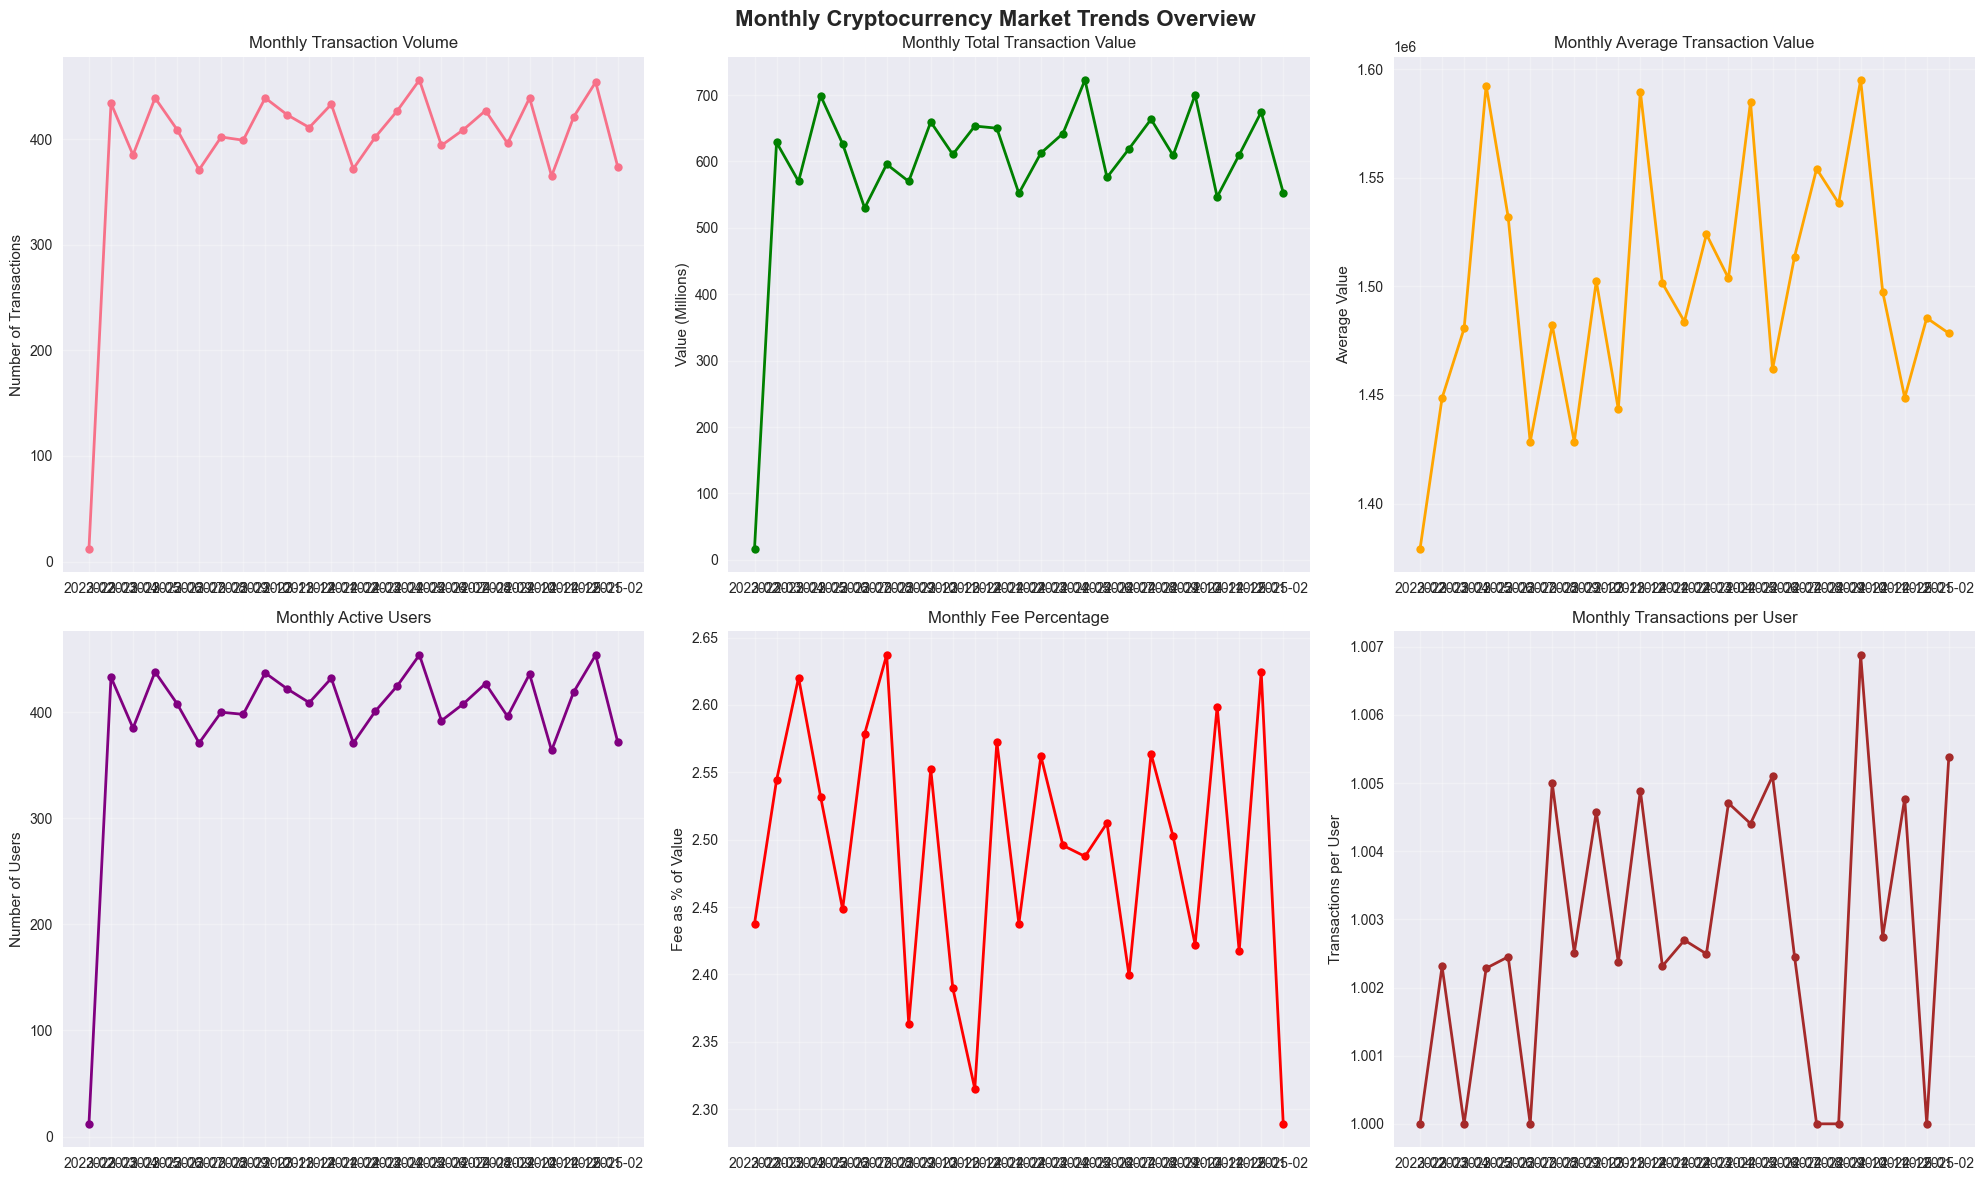


2. Analyzing Platform Performance...


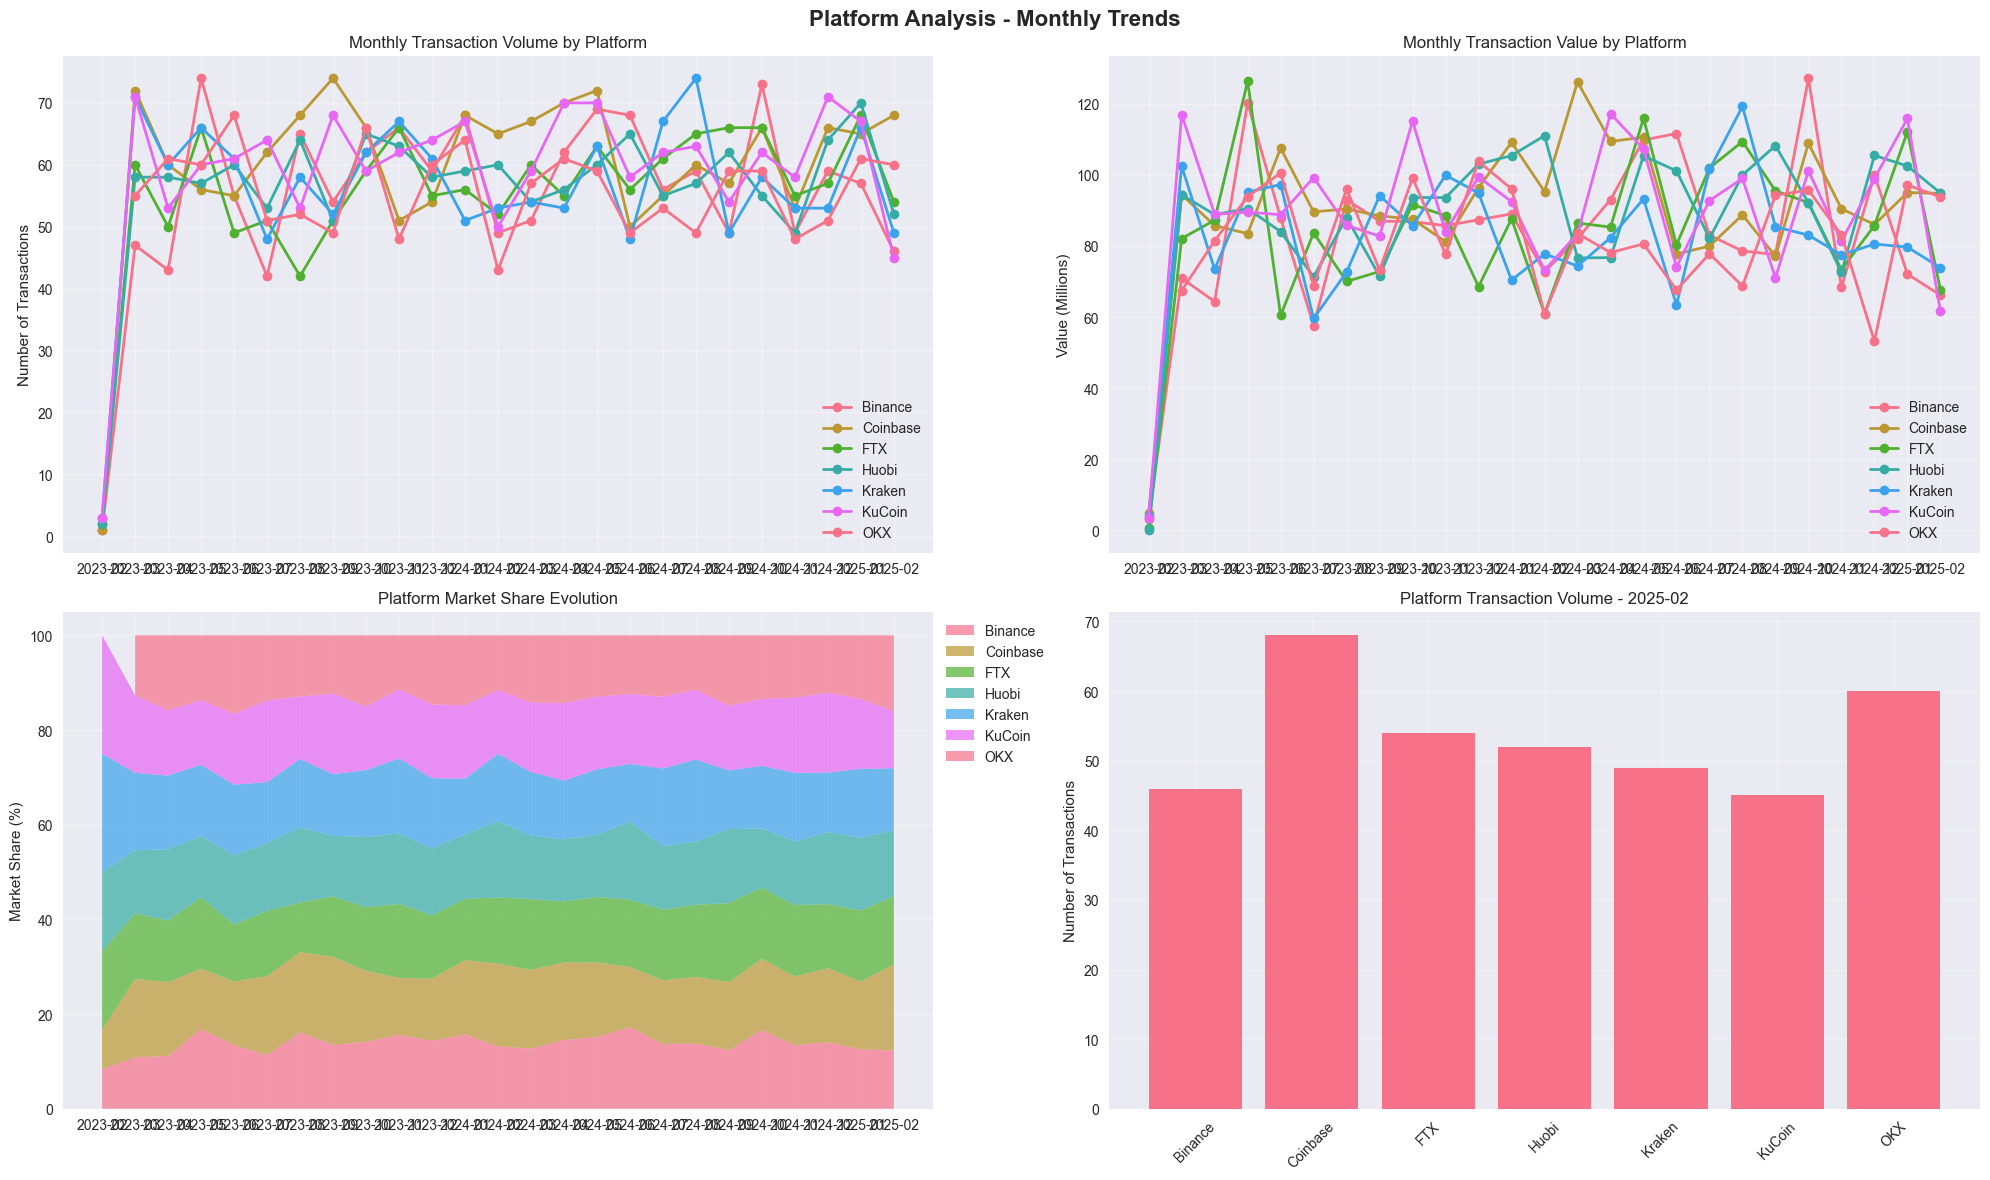


3. Analyzing Cryptocurrency Trends...


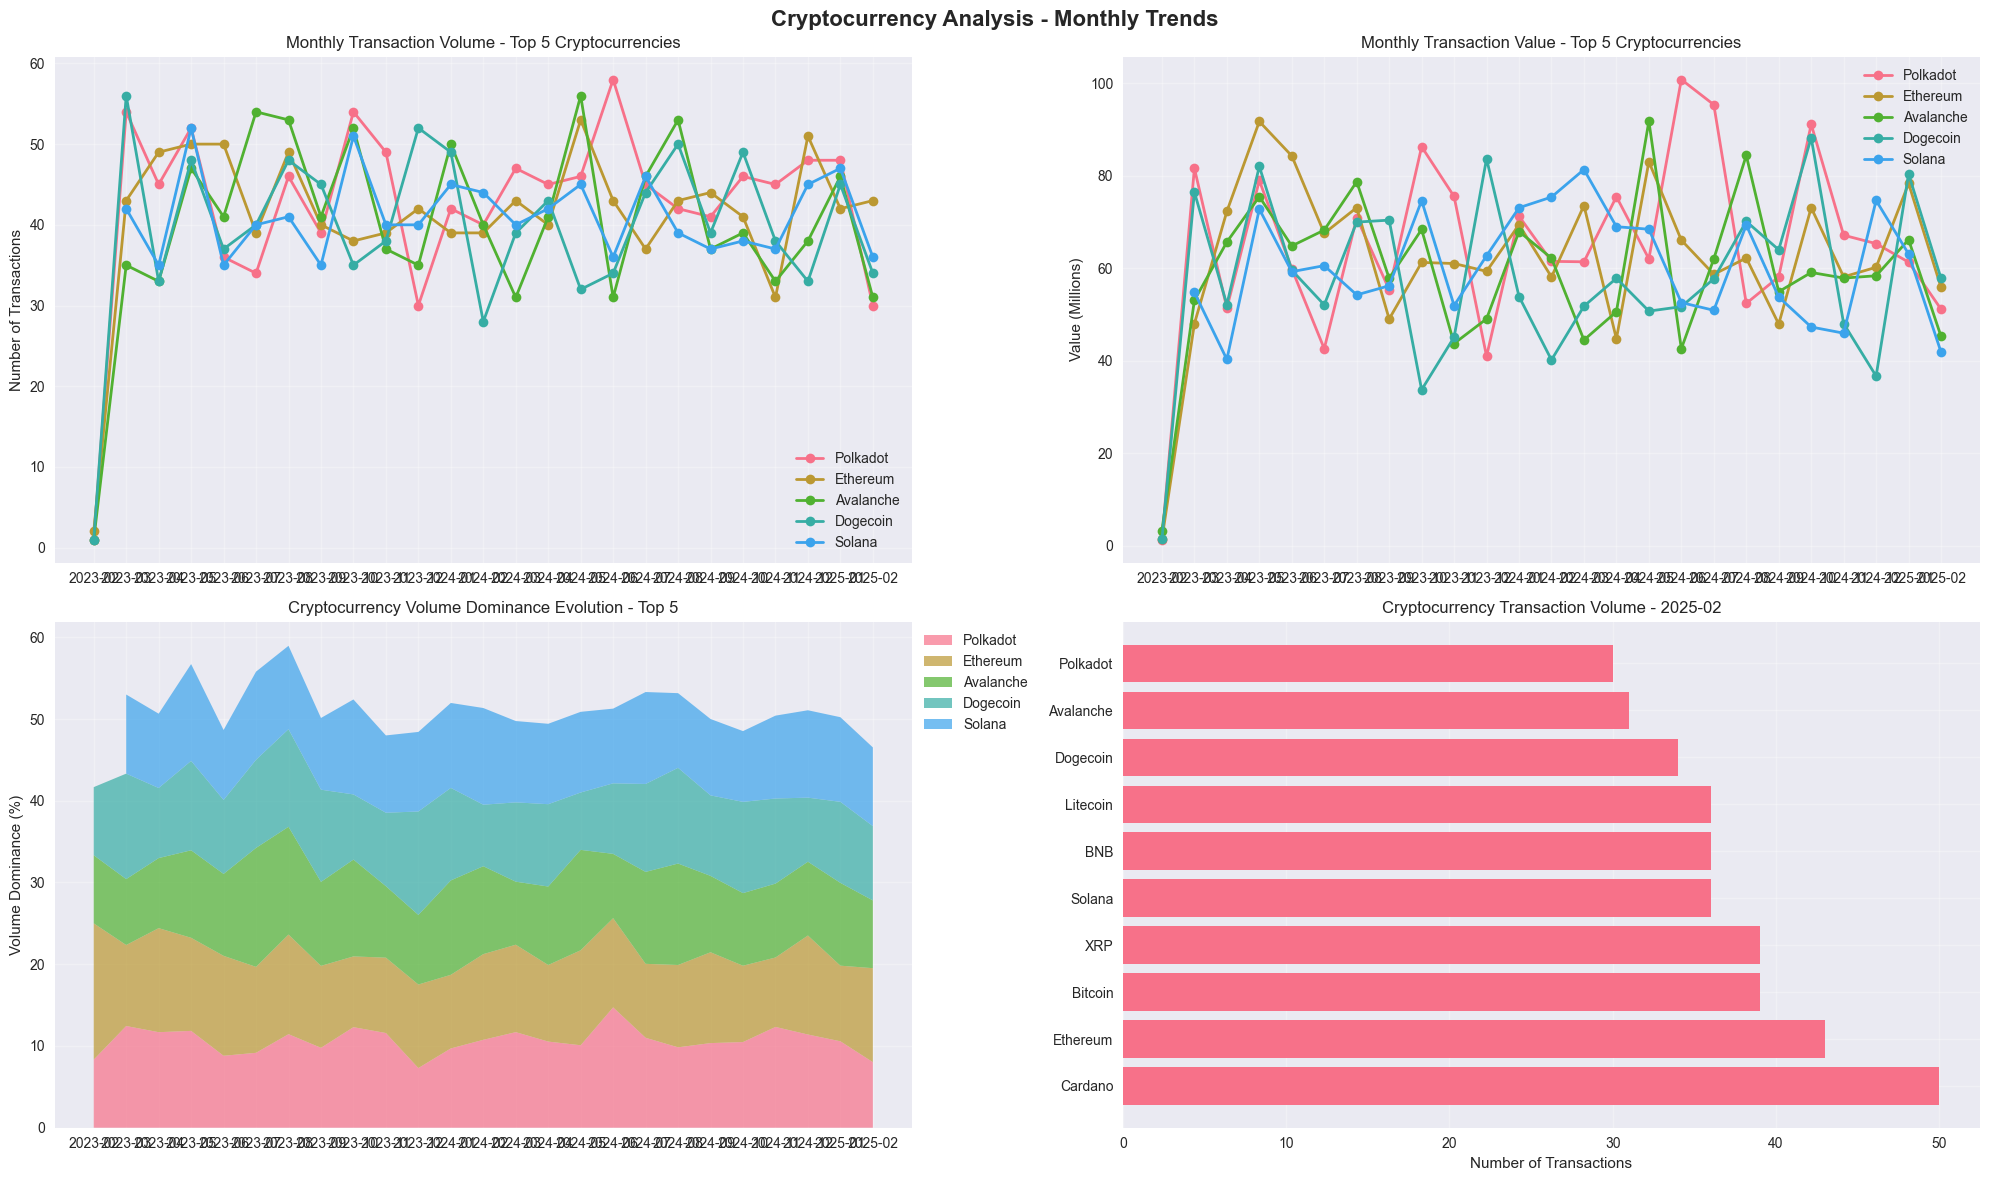


4. Analyzing Transaction Types...


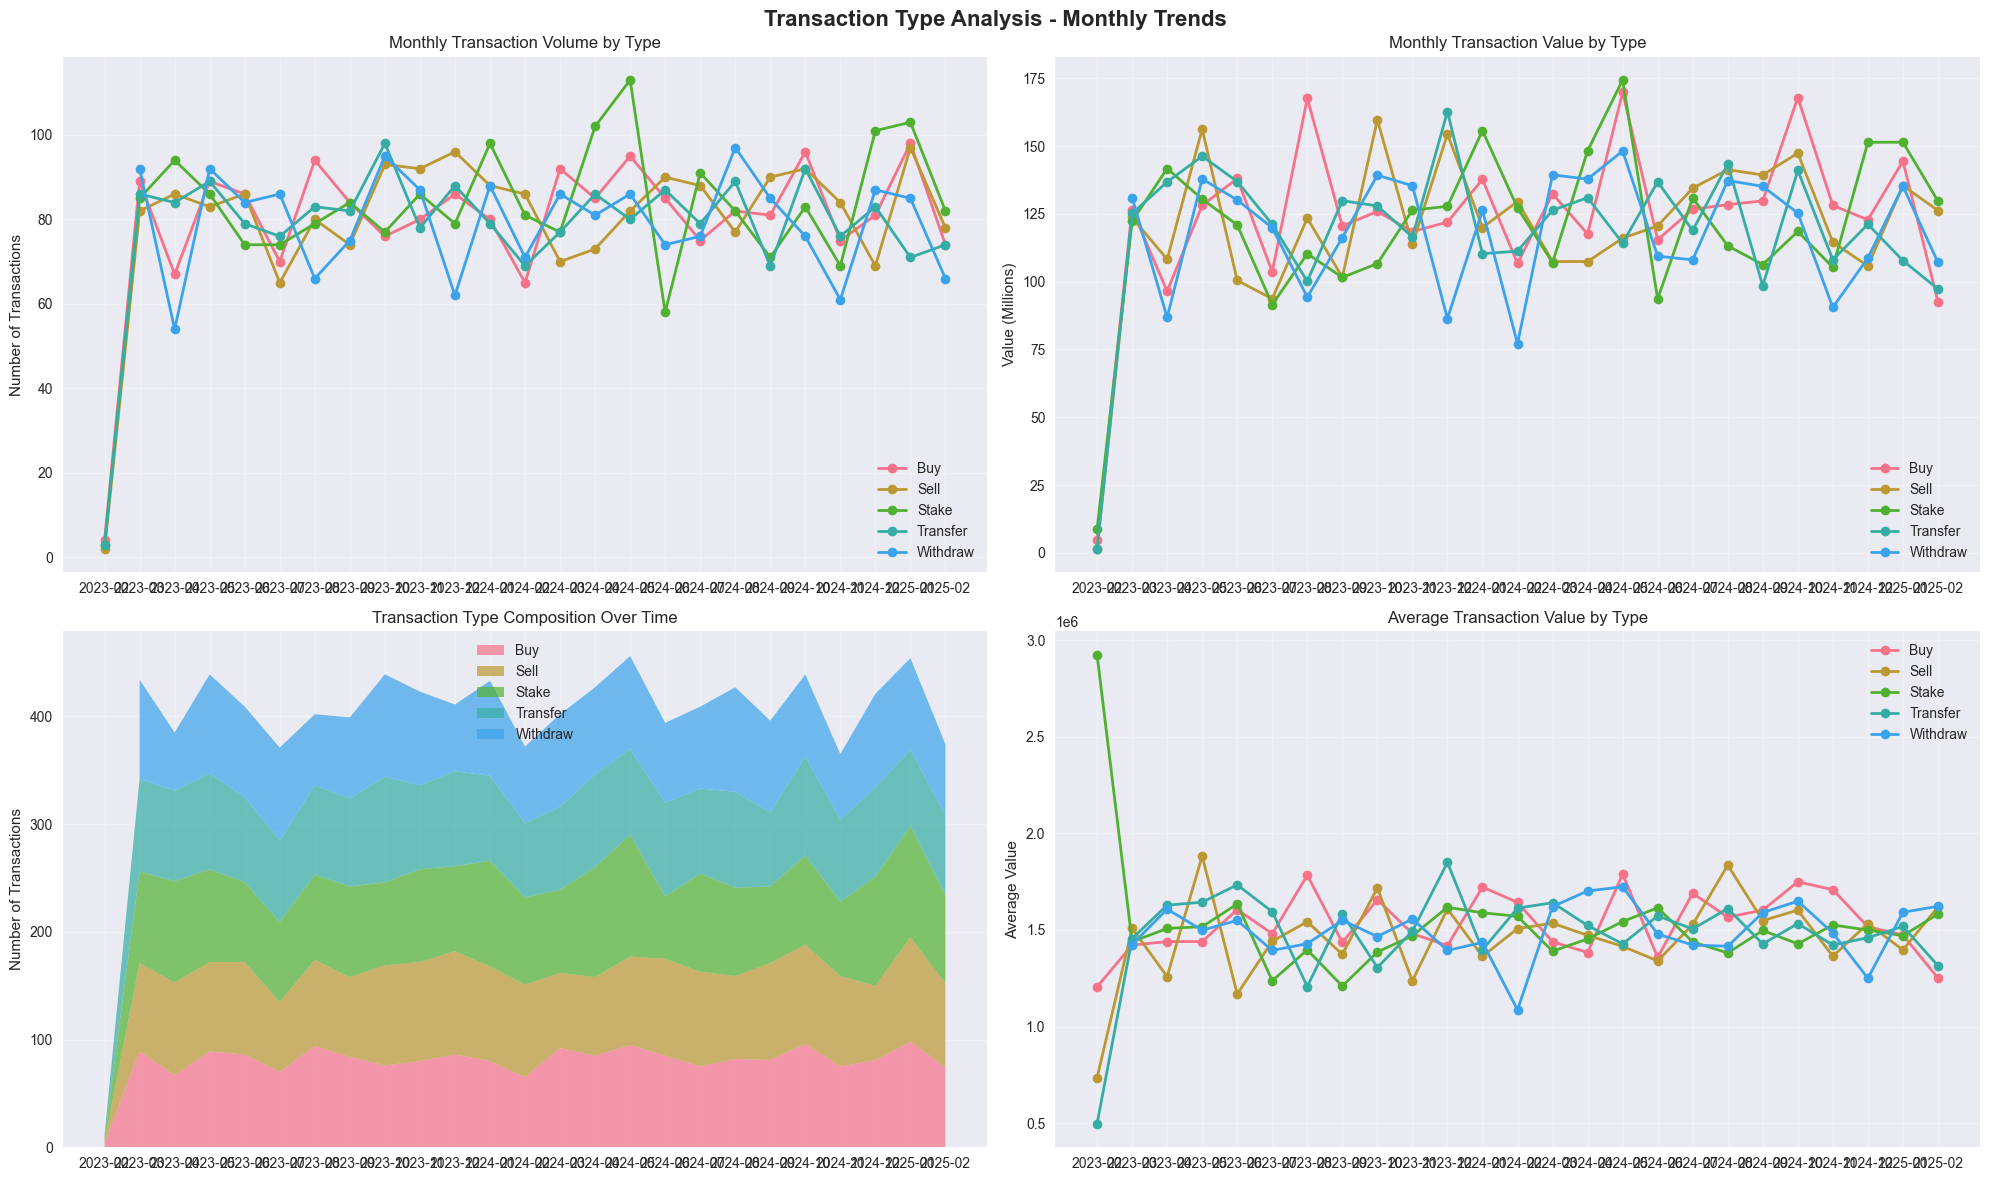


5. Analyzing Wallet Types...


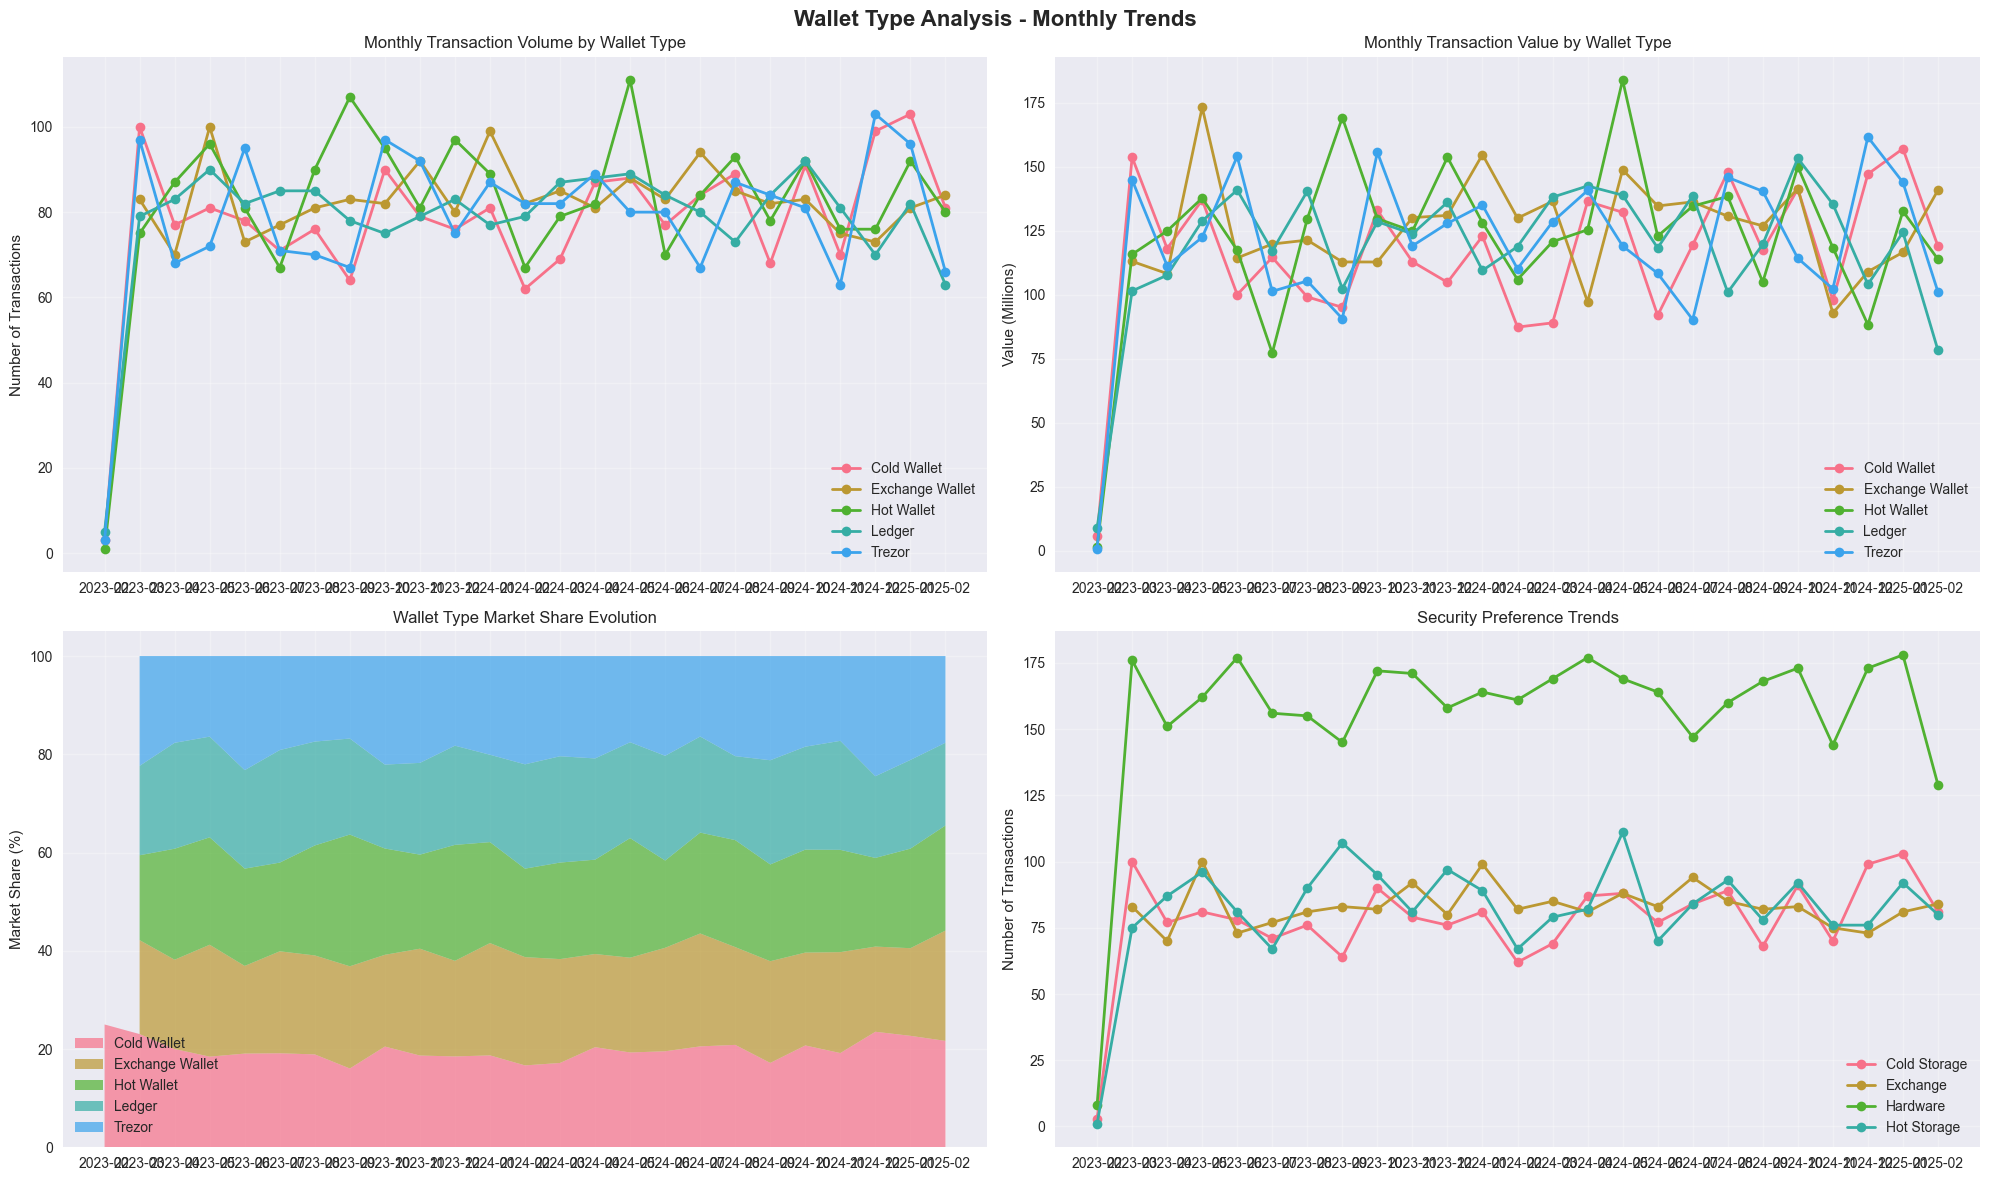


6. Analyzing Transaction Status...


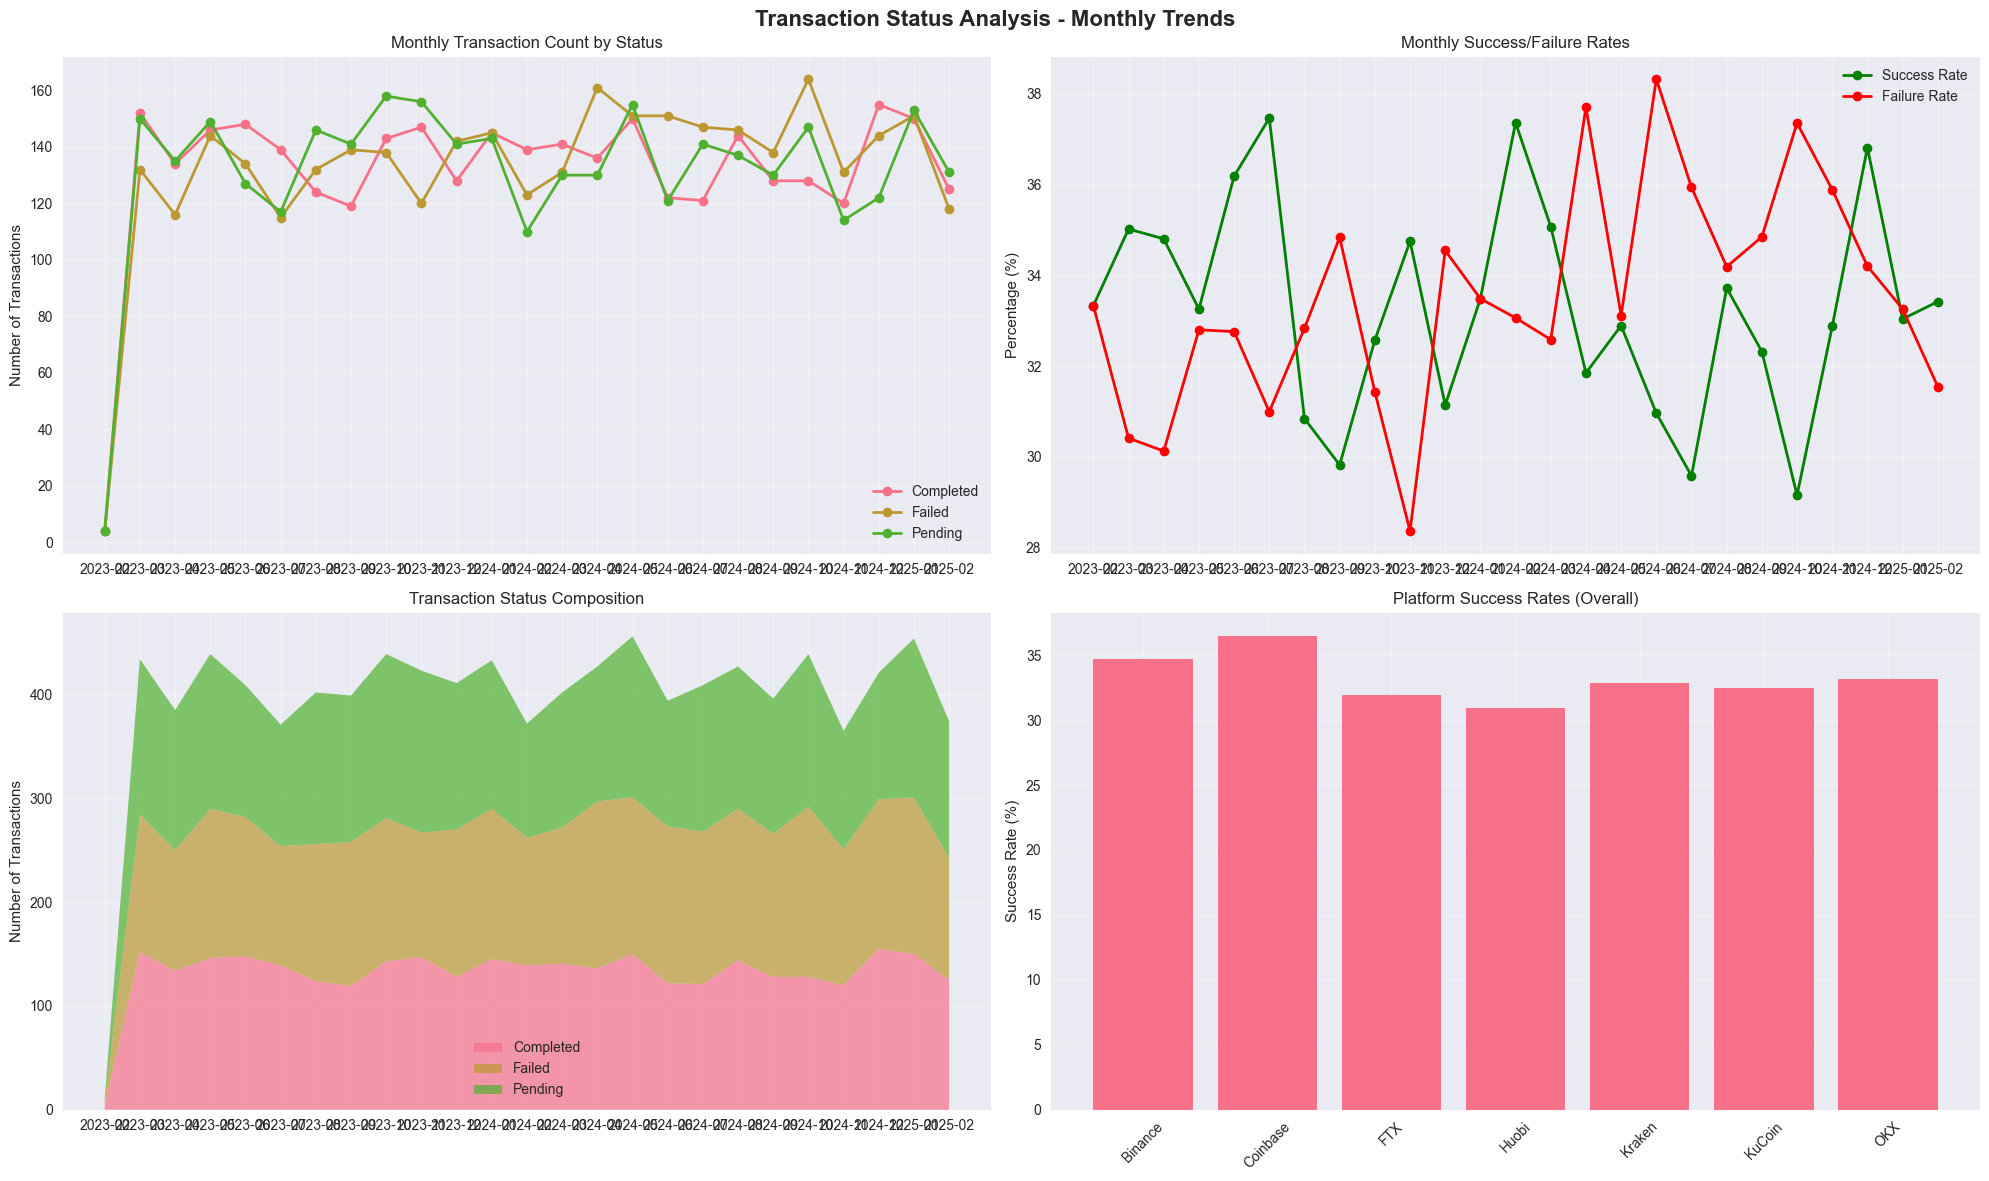


7. Performing Advanced Analytics...


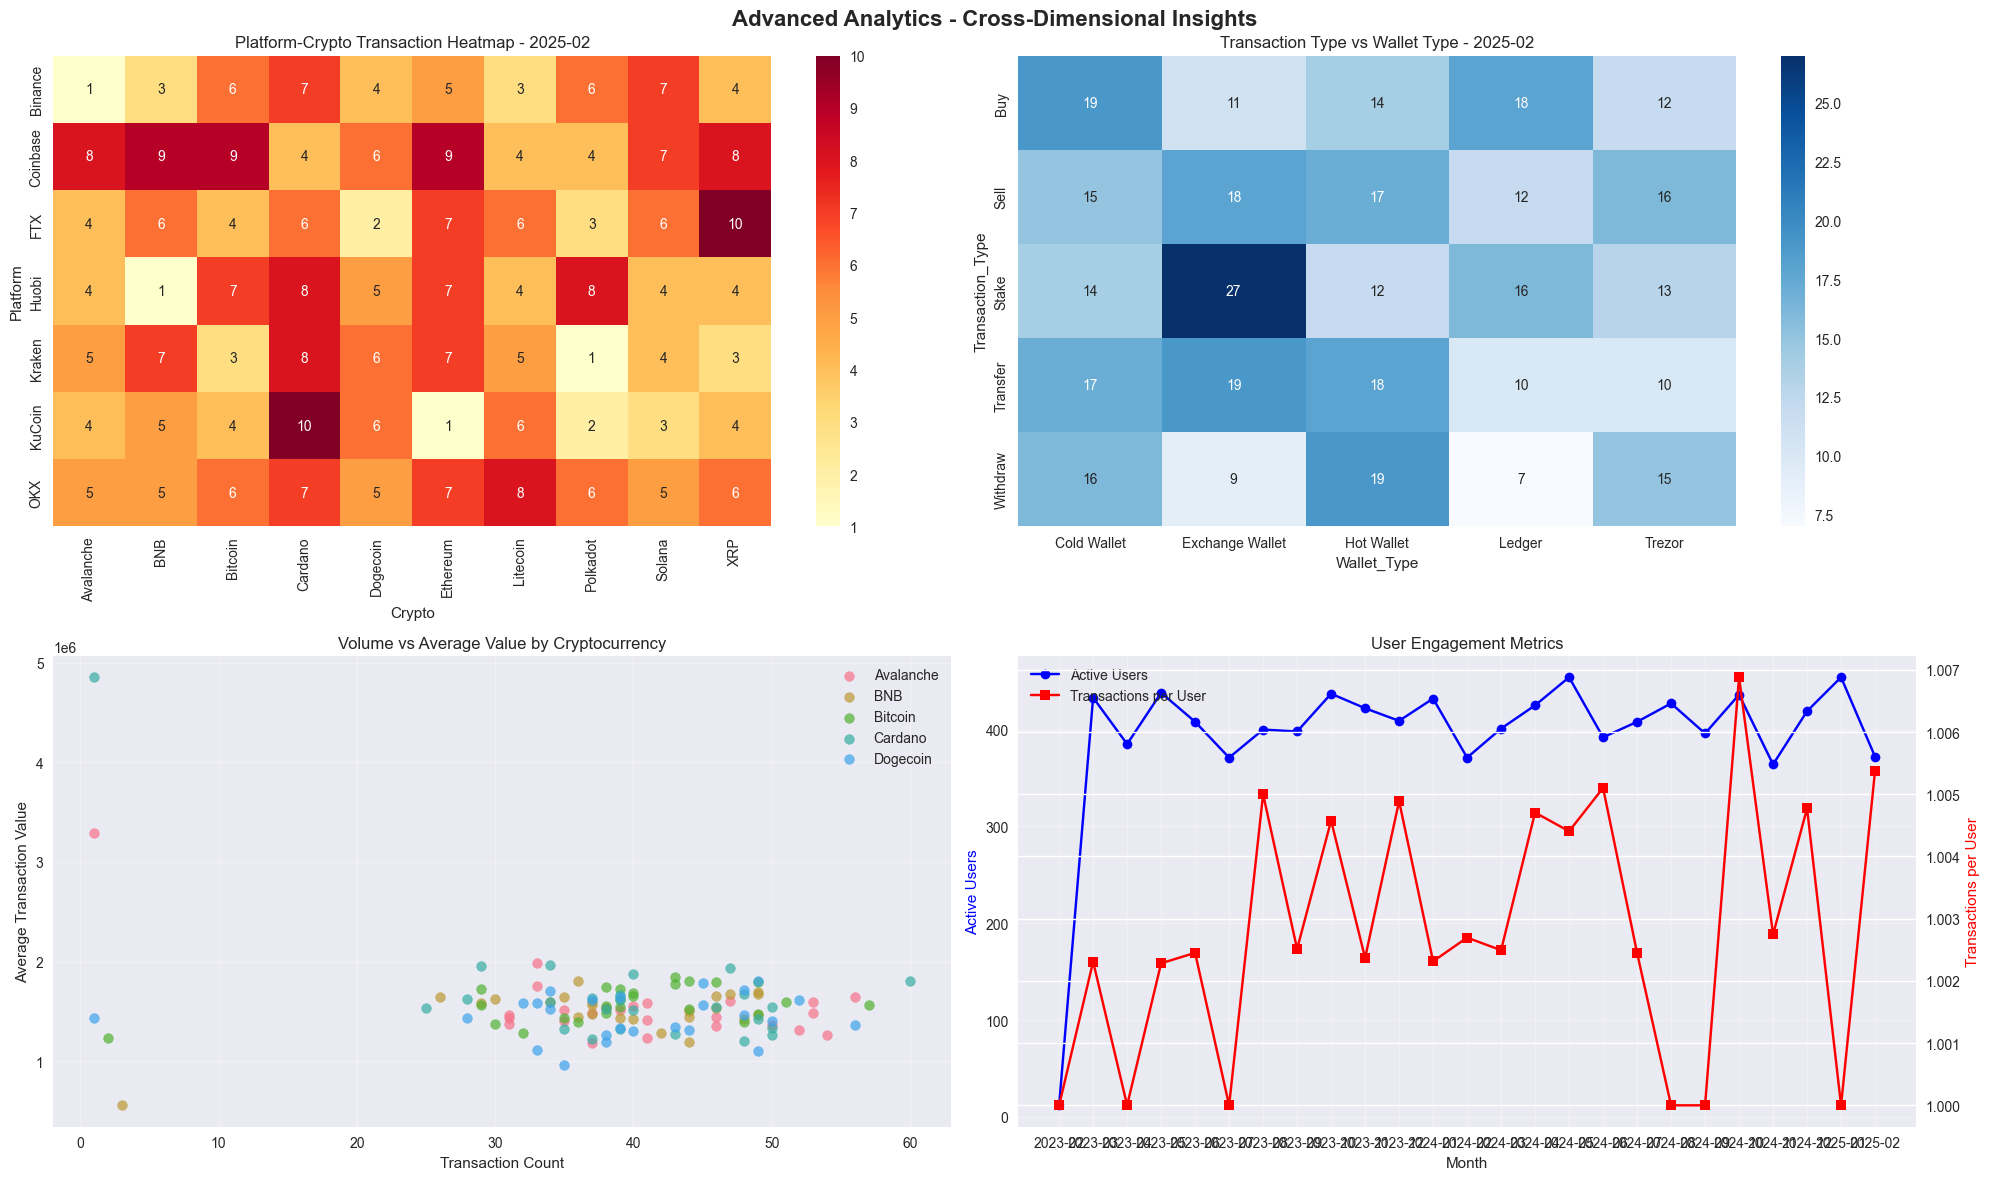


8. Generating Key Insights...
CRYPTOCURRENCY TRANSACTION ANALYSIS - KEY INSIGHTS

📊 OVERALL STATISTICS:
Total Transactions: 9,893
Total Value: $14,891,240,156.23
Total Fees: $371,499,146.42
Average Transaction Value: $1,505,229.98
Average Fee Rate: 2.495%

📈 MONTH-OVER-MONTH GROWTH:
Transaction Volume: -17.6%
Transaction Value: -18.0%
Active Users: -18.1%

🏆 TOP PERFORMERS:
Top 3 Platforms by Volume:
  Coinbase: 1,501 transactions ($2,258,903,648)
  KuCoin: 1,474 transactions ($2,223,331,096)
  Huobi: 1,407 transactions ($2,212,990,025)

Top 3 Cryptocurrencies by Volume:
  Polkadot: 1,063 transactions ($1,619,313,851)
  Ethereum: 1,030 transactions ($1,558,535,030)
  Avalanche: 1,001 transactions ($1,476,100,077)

Transaction Type Distribution:
  Stake: 2,032 (20.5%)
  Sell: 2,003 (20.2%)
  Buy: 1,989 (20.1%)
  Transfer: 1,957 (19.8%)
  Withdraw: 1,912 (19.3%)

Wallet Type Preferences:
  Hot Wallet: 2,046 (20.7%)
  Exchange Wallet: 1,996 (20.2%)
  Trezor: 1,954 (19.8%)
  Ledger: 1,953

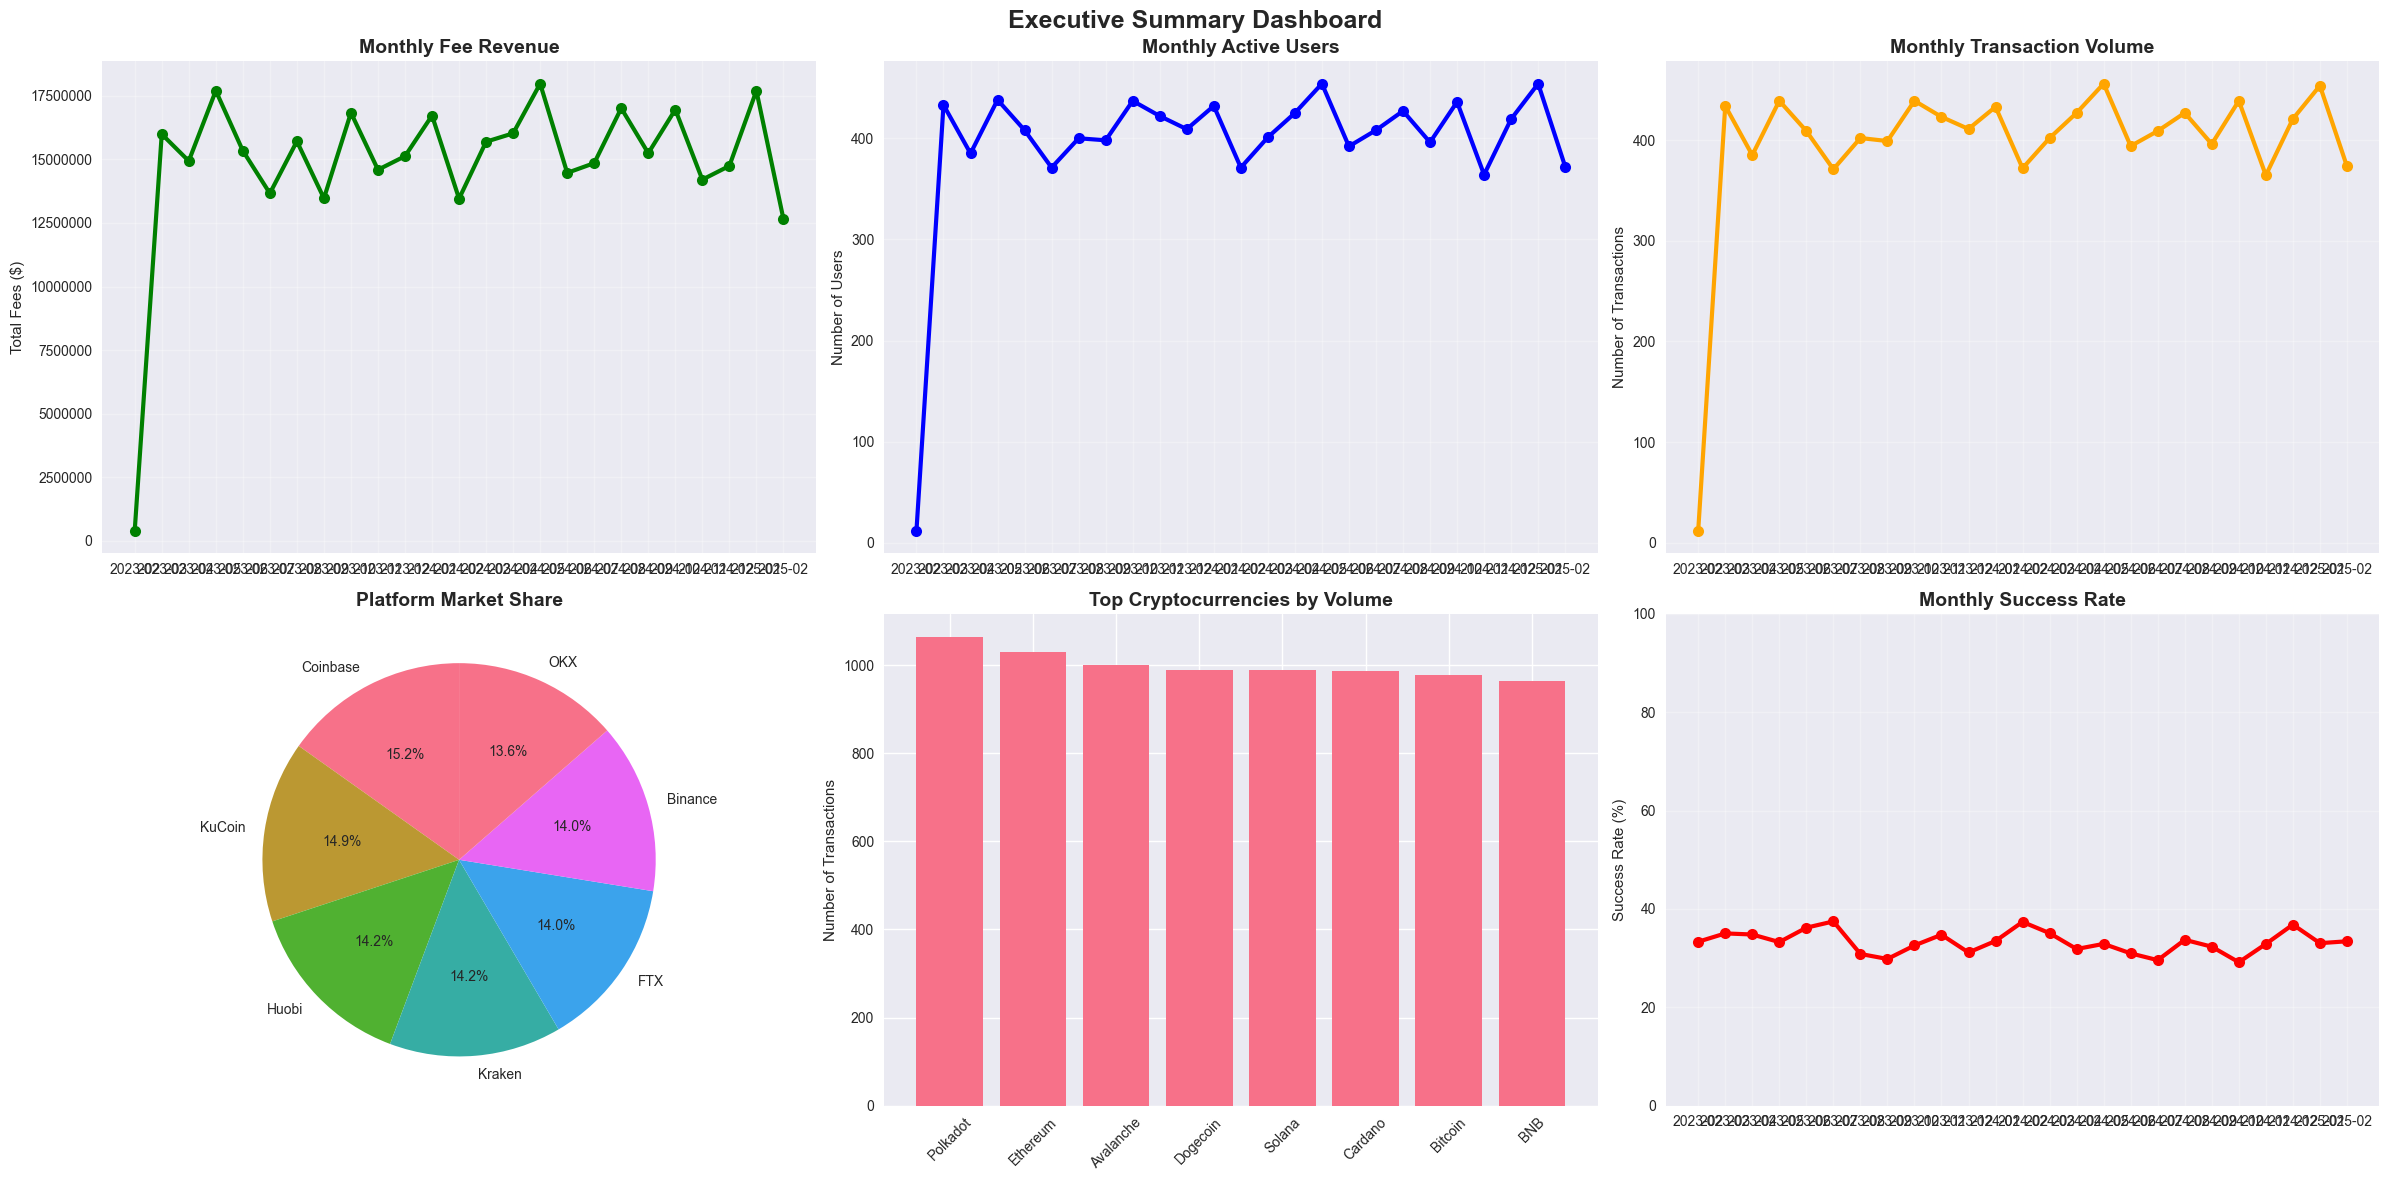


📊 Summary data exported and ready for further analysis.

🎉 Complete analysis finished! Check all the visualizations above.


In [18]:
results = run_complete_analysis()

# Create executive summary
print("\n" + "="*80)
print("CREATING EXECUTIVE SUMMARY DASHBOARD")
print("="*80)
create_executive_summary()

# Export summary data
summary_data = export_summary_data()
print("\n📊 Summary data exported and ready for further analysis.")

print("\n🎉 Complete analysis finished! Check all the visualizations above.")
print("="*80)

### Attempt 3 - Focus on Completed Transactions (success metric)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. OVERALL SUCCESS RATE ANALYSIS - TIME SERIES
# ============================================================================

def analyze_overall_success_rate():
    """Analyze overall success rate trends over time"""
    
    # Calculate monthly success rates
    monthly_status = agg_monthly_t.groupby(['month', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    # Calculate total monthly transactions
    monthly_totals = monthly_status.groupby('month').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    monthly_totals.columns = ['month', 'Total_Transactions', 'Total_Value_All']
    
    # Get completed transactions
    completed_monthly = monthly_status[monthly_status['Status'] == 'Completed'].copy()
    completed_monthly = completed_monthly.merge(monthly_totals, on='month', how='right')
    completed_monthly['Transaction_Count'] = completed_monthly['Transaction_Count'].fillna(0)
    completed_monthly['Total_Value'] = completed_monthly['Total_Value'].fillna(0)
    
    # Calculate success rates
    completed_monthly['Success_Rate'] = (completed_monthly['Transaction_Count'] / 
                                       completed_monthly['Total_Transactions']) * 100
    completed_monthly['Value_Success_Rate'] = (completed_monthly['Total_Value'] / 
                                             completed_monthly['Total_Value_All']) * 100
    
    # Calculate failed transactions
    failed_monthly = monthly_status[monthly_status['Status'] == 'Failed'].copy()
    failed_monthly = failed_monthly.merge(monthly_totals, on='month', how='right')
    failed_monthly['Transaction_Count'] = failed_monthly['Transaction_Count'].fillna(0)
    failed_monthly['Total_Value'] = failed_monthly['Total_Value'].fillna(0)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Overall Success Rate Analysis - Time Series', fontsize=16, fontweight='bold')
    
    # 1. Success Rate Trend
    axes[0,0].plot(completed_monthly['month'], completed_monthly['Success_Rate'], 
                   marker='o', linewidth=3, markersize=8, color='green', label='Success Rate')
    axes[0,0].axhline(y=completed_monthly['Success_Rate'].mean(), color='red', 
                      linestyle='--', alpha=0.7, label=f'Average ({completed_monthly["Success_Rate"].mean():.1f}%)')
    axes[0,0].set_title('Monthly Transaction Success Rate', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].set_ylim(0, 100)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()
    
    # 2. Value Success Rate
    axes[0,1].plot(completed_monthly['month'], completed_monthly['Value_Success_Rate'], 
                   marker='s', linewidth=3, markersize=8, color='blue', label='Value Success Rate')
    axes[0,1].axhline(y=completed_monthly['Value_Success_Rate'].mean(), color='red', 
                      linestyle='--', alpha=0.7, label=f'Average ({completed_monthly["Value_Success_Rate"].mean():.1f}%)')
    axes[0,1].set_title('Monthly Value Success Rate', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Value Success Rate (%)')
    axes[0,1].set_ylim(0, 100)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
    # 3. Failed Transactions Trend
    axes[1,0].plot(failed_monthly['month'], failed_monthly['Transaction_Count'], 
                   marker='o', linewidth=3, markersize=8, color='red', label='Failed Transactions')
    axes[1,0].set_title('Monthly Failed Transactions', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Number of Failed Transactions')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend()
    
    # 4. Lost Value Due to Failures
    axes[1,1].plot(failed_monthly['month'], failed_monthly['Total_Value']/1e6, 
                   marker='s', linewidth=3, markersize=8, color='darkred', label='Lost Value')
    axes[1,1].set_title('Monthly Lost Value Due to Failures', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Lost Value (Millions $)')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    print("="*80)
    print("OVERALL SUCCESS RATE ANALYSIS")
    print("="*80)
    print(f"Average Success Rate: {completed_monthly['Success_Rate'].mean():.2f}%")
    print(f"Average Value Success Rate: {completed_monthly['Value_Success_Rate'].mean():.2f}%")
    print(f"Best Month Success Rate: {completed_monthly['Success_Rate'].max():.2f}%")
    print(f"Worst Month Success Rate: {completed_monthly['Success_Rate'].min():.2f}%")
    print(f"Total Failed Transactions: {failed_monthly['Transaction_Count'].sum():,}")
    print(f"Total Lost Value: ${failed_monthly['Total_Value'].sum():,.2f}")
    print("="*80)
    
    return completed_monthly, failed_monthly

# ============================================================================
# 2. PLATFORM SUCCESS RATE ANALYSIS
# ============================================================================

def analyze_platform_success_rates():
    """Analyze success rates by platform and identify improvement opportunities"""
    
    # Calculate platform success rates
    platform_status = agg_monthly_t.groupby(['Platform', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    # Calculate total per platform
    platform_totals = platform_status.groupby('Platform').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    platform_totals.columns = ['Platform', 'Total_Transactions', 'Total_Value_All']
    
    # Get completed transactions per platform
    platform_completed = platform_status[platform_status['Status'] == 'Completed'].copy()
    platform_completed = platform_completed.merge(platform_totals, on='Platform', how='right')
    platform_completed['Transaction_Count'] = platform_completed['Transaction_Count'].fillna(0)
    platform_completed['Total_Value'] = platform_completed['Total_Value'].fillna(0)
    
    # Calculate success rates
    platform_completed['Success_Rate'] = (platform_completed['Transaction_Count'] / 
                                         platform_completed['Total_Transactions']) * 100
    platform_completed['Value_Success_Rate'] = (platform_completed['Total_Value'] / 
                                               platform_completed['Total_Value_All']) * 100
    
    # Get failed transactions per platform
    platform_failed = platform_status[platform_status['Status'] == 'Failed'].copy()
    platform_failed = platform_failed.merge(platform_totals, on='Platform', how='right')
    platform_failed['Transaction_Count'] = platform_failed['Transaction_Count'].fillna(0)
    platform_failed['Total_Value'] = platform_failed['Total_Value'].fillna(0)
    
    # Monthly platform success rates
    platform_monthly_status = agg_monthly_t.groupby(['month', 'Platform', 'Status']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    platform_monthly_totals = platform_monthly_status.groupby(['month', 'Platform']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    platform_monthly_totals.columns = ['month', 'Platform', 'Total_Transactions']
    
    platform_monthly_completed = platform_monthly_status[platform_monthly_status['Status'] == 'Completed'].copy()
    platform_monthly_completed = platform_monthly_completed.merge(platform_monthly_totals, on=['month', 'Platform'], how='right')
    platform_monthly_completed['Transaction_Count'] = platform_monthly_completed['Transaction_Count'].fillna(0)
    platform_monthly_completed['Success_Rate'] = (platform_monthly_completed['Transaction_Count'] / 
                                                 platform_monthly_completed['Total_Transactions']) * 100
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Platform Success Rate Analysis', fontsize=16, fontweight='bold')
    
    # 1. Platform Success Rates (Bar Chart)
    platform_completed_sorted = platform_completed.sort_values('Success_Rate', ascending=True)
    colors = ['red' if x < 90 else 'orange' if x < 95 else 'green' for x in platform_completed_sorted['Success_Rate']]
    
    axes[0,0].barh(platform_completed_sorted['Platform'], platform_completed_sorted['Success_Rate'], color=colors)
    axes[0,0].set_title('Platform Success Rates', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Success Rate (%)')
    axes[0,0].axvline(x=90, color='red', linestyle='--', alpha=0.7, label='90% Threshold')
    axes[0,0].axvline(x=95, color='orange', linestyle='--', alpha=0.7, label='95% Threshold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Platform Success Rate Trends Over Time
    for platform in platform_monthly_completed['Platform'].unique():
        platform_data = platform_monthly_completed[platform_monthly_completed['Platform'] == platform]
        axes[0,1].plot(platform_data['month'], platform_data['Success_Rate'], 
                      marker='o', label=platform, linewidth=2)
    
    axes[0,1].set_title('Platform Success Rate Trends', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Success Rate (%)')
    axes[0,1].set_ylim(0, 100)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Failed Transactions by Platform
    platform_failed_sorted = platform_failed.sort_values('Transaction_Count', ascending=True)
    axes[1,0].barh(platform_failed_sorted['Platform'], platform_failed_sorted['Transaction_Count'], color='red', alpha=0.7)
    axes[1,0].set_title('Failed Transactions by Platform', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Number of Failed Transactions')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Lost Value by Platform
    axes[1,1].barh(platform_failed_sorted['Platform'], platform_failed_sorted['Total_Value']/1e6, color='darkred', alpha=0.7)
    axes[1,1].set_title('Lost Value by Platform', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Lost Value (Millions $)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return platform_completed, platform_failed

# ============================================================================
# 3. WALLET TYPE SUCCESS RATE ANALYSIS
# ============================================================================

def analyze_wallet_success_rates():
    """Analyze success rates by wallet type"""
    
    # Calculate wallet success rates
    wallet_status = agg_monthly_t.groupby(['Wallet_Type', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    # Calculate total per wallet type
    wallet_totals = wallet_status.groupby('Wallet_Type').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    wallet_totals.columns = ['Wallet_Type', 'Total_Transactions', 'Total_Value_All']
    
    # Get completed transactions per wallet type
    wallet_completed = wallet_status[wallet_status['Status'] == 'Completed'].copy()
    wallet_completed = wallet_completed.merge(wallet_totals, on='Wallet_Type', how='right')
    wallet_completed['Transaction_Count'] = wallet_completed['Transaction_Count'].fillna(0)
    wallet_completed['Total_Value'] = wallet_completed['Total_Value'].fillna(0)
    
    # Calculate success rates
    wallet_completed['Success_Rate'] = (wallet_completed['Transaction_Count'] / 
                                       wallet_completed['Total_Transactions']) * 100
    wallet_completed['Value_Success_Rate'] = (wallet_completed['Total_Value'] / 
                                             wallet_completed['Total_Value_All']) * 100
    
    # Get failed transactions per wallet type
    wallet_failed = wallet_status[wallet_status['Status'] == 'Failed'].copy()
    wallet_failed = wallet_failed.merge(wallet_totals, on='Wallet_Type', how='right')
    wallet_failed['Transaction_Count'] = wallet_failed['Transaction_Count'].fillna(0)
    wallet_failed['Total_Value'] = wallet_failed['Total_Value'].fillna(0)
    
    # Monthly wallet success rates
    wallet_monthly_status = agg_monthly_t.groupby(['month', 'Wallet_Type', 'Status']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    
    wallet_monthly_totals = wallet_monthly_status.groupby(['month', 'Wallet_Type']).agg({
        'Transaction_Count': 'sum'
    }).reset_index()
    wallet_monthly_totals.columns = ['month', 'Wallet_Type', 'Total_Transactions']
    
    wallet_monthly_completed = wallet_monthly_status[wallet_monthly_status['Status'] == 'Completed'].copy()
    wallet_monthly_completed = wallet_monthly_completed.merge(wallet_monthly_totals, on=['month', 'Wallet_Type'], how='right')
    wallet_monthly_completed['Transaction_Count'] = wallet_monthly_completed['Transaction_Count'].fillna(0)
    wallet_monthly_completed['Success_Rate'] = (wallet_monthly_completed['Transaction_Count'] / 
                                               wallet_monthly_completed['Total_Transactions']) * 100
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Wallet Type Success Rate Analysis', fontsize=16, fontweight='bold')
    
    # 1. Wallet Success Rates
    wallet_completed_sorted = wallet_completed.sort_values('Success_Rate', ascending=True)
    colors = ['red' if x < 90 else 'orange' if x < 95 else 'green' for x in wallet_completed_sorted['Success_Rate']]
    
    axes[0,0].barh(wallet_completed_sorted['Wallet_Type'], wallet_completed_sorted['Success_Rate'], color=colors)
    axes[0,0].set_title('Wallet Type Success Rates', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Success Rate (%)')
    axes[0,0].axvline(x=90, color='red', linestyle='--', alpha=0.7, label='90% Threshold')
    axes[0,0].axvline(x=95, color='orange', linestyle='--', alpha=0.7, label='95% Threshold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Wallet Success Rate Trends Over Time
    for wallet in wallet_monthly_completed['Wallet_Type'].unique():
        wallet_data = wallet_monthly_completed[wallet_monthly_completed['Wallet_Type'] == wallet]
        axes[0,1].plot(wallet_data['month'], wallet_data['Success_Rate'], 
                      marker='o', label=wallet, linewidth=2)
    
    axes[0,1].set_title('Wallet Type Success Rate Trends', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Success Rate (%)')
    axes[0,1].set_ylim(0, 100)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Transaction Volume vs Success Rate
    axes[1,0].scatter(wallet_completed['Success_Rate'], wallet_completed['Total_Transactions'], 
                      s=200, alpha=0.7, c=wallet_completed['Success_Rate'], cmap='RdYlGn')
    
    for i, row in wallet_completed.iterrows():
        axes[1,0].annotate(row['Wallet_Type'], (row['Success_Rate'], row['Total_Transactions']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    axes[1,0].set_title('Transaction Volume vs Success Rate', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Success Rate (%)')
    axes[1,0].set_ylabel('Total Transactions')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Failed Transactions by Wallet Type
    wallet_failed_sorted = wallet_failed.sort_values('Transaction_Count', ascending=True)
    axes[1,1].barh(wallet_failed_sorted['Wallet_Type'], wallet_failed_sorted['Transaction_Count'], color='red', alpha=0.7)
    axes[1,1].set_title('Failed Transactions by Wallet Type', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Number of Failed Transactions')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return wallet_completed, wallet_failed

# ============================================================================
# 4. OPPORTUNITY ANALYSIS - VOLUME INCREASE POTENTIAL
# ============================================================================

def calculate_volume_opportunities():
    """Calculate potential volume increase from improving success rates"""
    
    print("="*80)
    print("VOLUME INCREASE OPPORTUNITY ANALYSIS")
    print("="*80)
    
    # Platform opportunities
    platform_status = agg_monthly_t.groupby(['Platform', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    platform_totals = platform_status.groupby('Platform').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    platform_totals.columns = ['Platform', 'Total_Transactions', 'Total_Value_All']
    
    platform_completed = platform_status[platform_status['Status'] == 'Completed'].copy()
    platform_completed = platform_completed.merge(platform_totals, on='Platform', how='right')
    platform_completed['Transaction_Count'] = platform_completed['Transaction_Count'].fillna(0)
    platform_completed['Success_Rate'] = (platform_completed['Transaction_Count'] / 
                                         platform_completed['Total_Transactions']) * 100
    
    platform_failed = platform_status[platform_status['Status'] == 'Failed'].copy()
    platform_failed = platform_failed.merge(platform_totals, on='Platform', how='right')
    platform_failed['Transaction_Count'] = platform_failed['Transaction_Count'].fillna(0)
    platform_failed['Total_Value'] = platform_failed['Total_Value'].fillna(0)
    
    # Calculate opportunities
    print("\n🏢 PLATFORM OPPORTUNITIES:")
    print("-" * 50)
    
    total_opportunity_volume = 0
    total_opportunity_value = 0
    
    benchmark_success_rate = 95  # Target success rate
    
    for _, row in platform_completed.iterrows():
        platform = row['Platform']
        current_success_rate = row['Success_Rate']
        total_transactions = row['Total_Transactions']
        
        if current_success_rate < benchmark_success_rate:
            # Find failed transactions for this platform
            failed_row = platform_failed[platform_failed['Platform'] == platform]
            if not failed_row.empty:
                failed_transactions = failed_row.iloc[0]['Transaction_Count']
                failed_value = failed_row.iloc[0]['Total_Value']
                
                # Calculate potential improvement
                improvement_rate = benchmark_success_rate - current_success_rate
                potential_recovered_transactions = (failed_transactions * improvement_rate) / (100 - current_success_rate)
                potential_recovered_value = (failed_value * improvement_rate) / (100 - current_success_rate)
                
                total_opportunity_volume += potential_recovered_transactions
                total_opportunity_value += potential_recovered_value
                
                print(f"{platform}:")
                print(f"  Current Success Rate: {current_success_rate:.1f}%")
                print(f"  Failed Transactions: {failed_transactions:,}")
                print(f"  Potential Additional Volume: {potential_recovered_transactions:,.0f} transactions")
                print(f"  Potential Additional Value: ${potential_recovered_value:,.0f}")
                print(f"  Volume Increase: {(potential_recovered_transactions/total_transactions)*100:.1f}%")
                print()
    
    # Wallet opportunities
    wallet_status = agg_monthly_t.groupby(['Wallet_Type', 'Status']).agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    
    wallet_totals = wallet_status.groupby('Wallet_Type').agg({
        'Transaction_Count': 'sum',
        'Total_Value': 'sum'
    }).reset_index()
    wallet_totals.columns = ['Wallet_Type', 'Total_Transactions', 'Total_Value_All']
    
    wallet_completed = wallet_status[wallet_status['Status'] == 'Completed'].copy()
    wallet_completed = wallet_completed.merge(wallet_totals, on='Wallet_Type', how='right')
    wallet_completed['Transaction_Count'] = wallet_completed['Transaction_Count'].fillna(0)
    wallet_completed['Success_Rate'] = (wallet_completed['Transaction_Count'] / 
                                       wallet_completed['Total_Transactions']) * 100
    
    wallet_failed = wallet_status[wallet_status['Status'] == 'Failed'].copy()
    wallet_failed = wallet_failed.merge(wallet_totals, on='Wallet_Type', how='right')
    wallet_failed['Transaction_Count'] = wallet_failed['Transaction_Count'].fillna(0)
    wallet_failed['Total_Value'] = wallet_failed['Total_Value'].fillna(0)
    
    print("\n💼 WALLET TYPE OPPORTUNITIES:")
    print("-" * 50)
    
    wallet_opportunity_volume = 0
    wallet_opportunity_value = 0
    
    for _, row in wallet_completed.iterrows():
        wallet = row['Wallet_Type']
        current_success_rate = row['Success_Rate']
        total_transactions = row['Total_Transactions']
        
        if current_success_rate < benchmark_success_rate:
            # Find failed transactions for this wallet
            failed_row = wallet_failed[wallet_failed['Wallet_Type'] == wallet]
            if not failed_row.empty:
                failed_transactions = failed_row.iloc[0]['Transaction_Count']
                failed_value = failed_row.iloc[0]['Total_Value']
                
                # Calculate potential improvement
                improvement_rate = benchmark_success_rate - current_success_rate
                potential_recovered_transactions = (failed_transactions * improvement_rate) / (100 - current_success_rate)
                potential_recovered_value = (failed_value * improvement_rate) / (100 - current_success_rate)
                
                wallet_opportunity_volume += potential_recovered_transactions
                wallet_opportunity_value += potential_recovered_value
                
                print(f"{wallet}:")
                print(f"  Current Success Rate: {current_success_rate:.1f}%")
                print(f"  Failed Transactions: {failed_transactions:,}")
                print(f"  Potential Additional Volume: {potential_recovered_transactions:,.0f} transactions")
                print(f"  Potential Additional Value: ${potential_recovered_value:,.0f}")
                print(f"  Volume Increase: {(potential_recovered_transactions/total_transactions)*100:.1f}%")
                print()
    
    # Summary
    print("\n📊 TOTAL OPPORTUNITY SUMMARY:")
    print("-" * 50)
    print(f"Platform Improvements to 95% Success Rate:")
    print(f"  Additional Volume: {total_opportunity_volume:,.0f} transactions")
    print(f"  Additional Value: ${total_opportunity_value:,.0f}")
    print(f"\nWallet Improvements to 95% Success Rate:")
    print(f"  Additional Volume: {wallet_opportunity_volume:,.0f} transactions")
    print(f"  Additional Value: ${wallet_opportunity_value:,.0f}")
    print(f"\nCombined Opportunity:")
    print(f"  Total Additional Volume: {total_opportunity_volume + wallet_opportunity_volume:,.0f} transactions")
    print(f"  Total Additional Value: ${total_opportunity_value + wallet_opportunity_value:,.0f}")
    
    return {
        'platform_volume_opportunity': total_opportunity_volume,
        'platform_value_opportunity': total_opportunity_value,
        'wallet_volume_opportunity': wallet_opportunity_volume,
        'wallet_value_opportunity': wallet_opportunity_value
    }



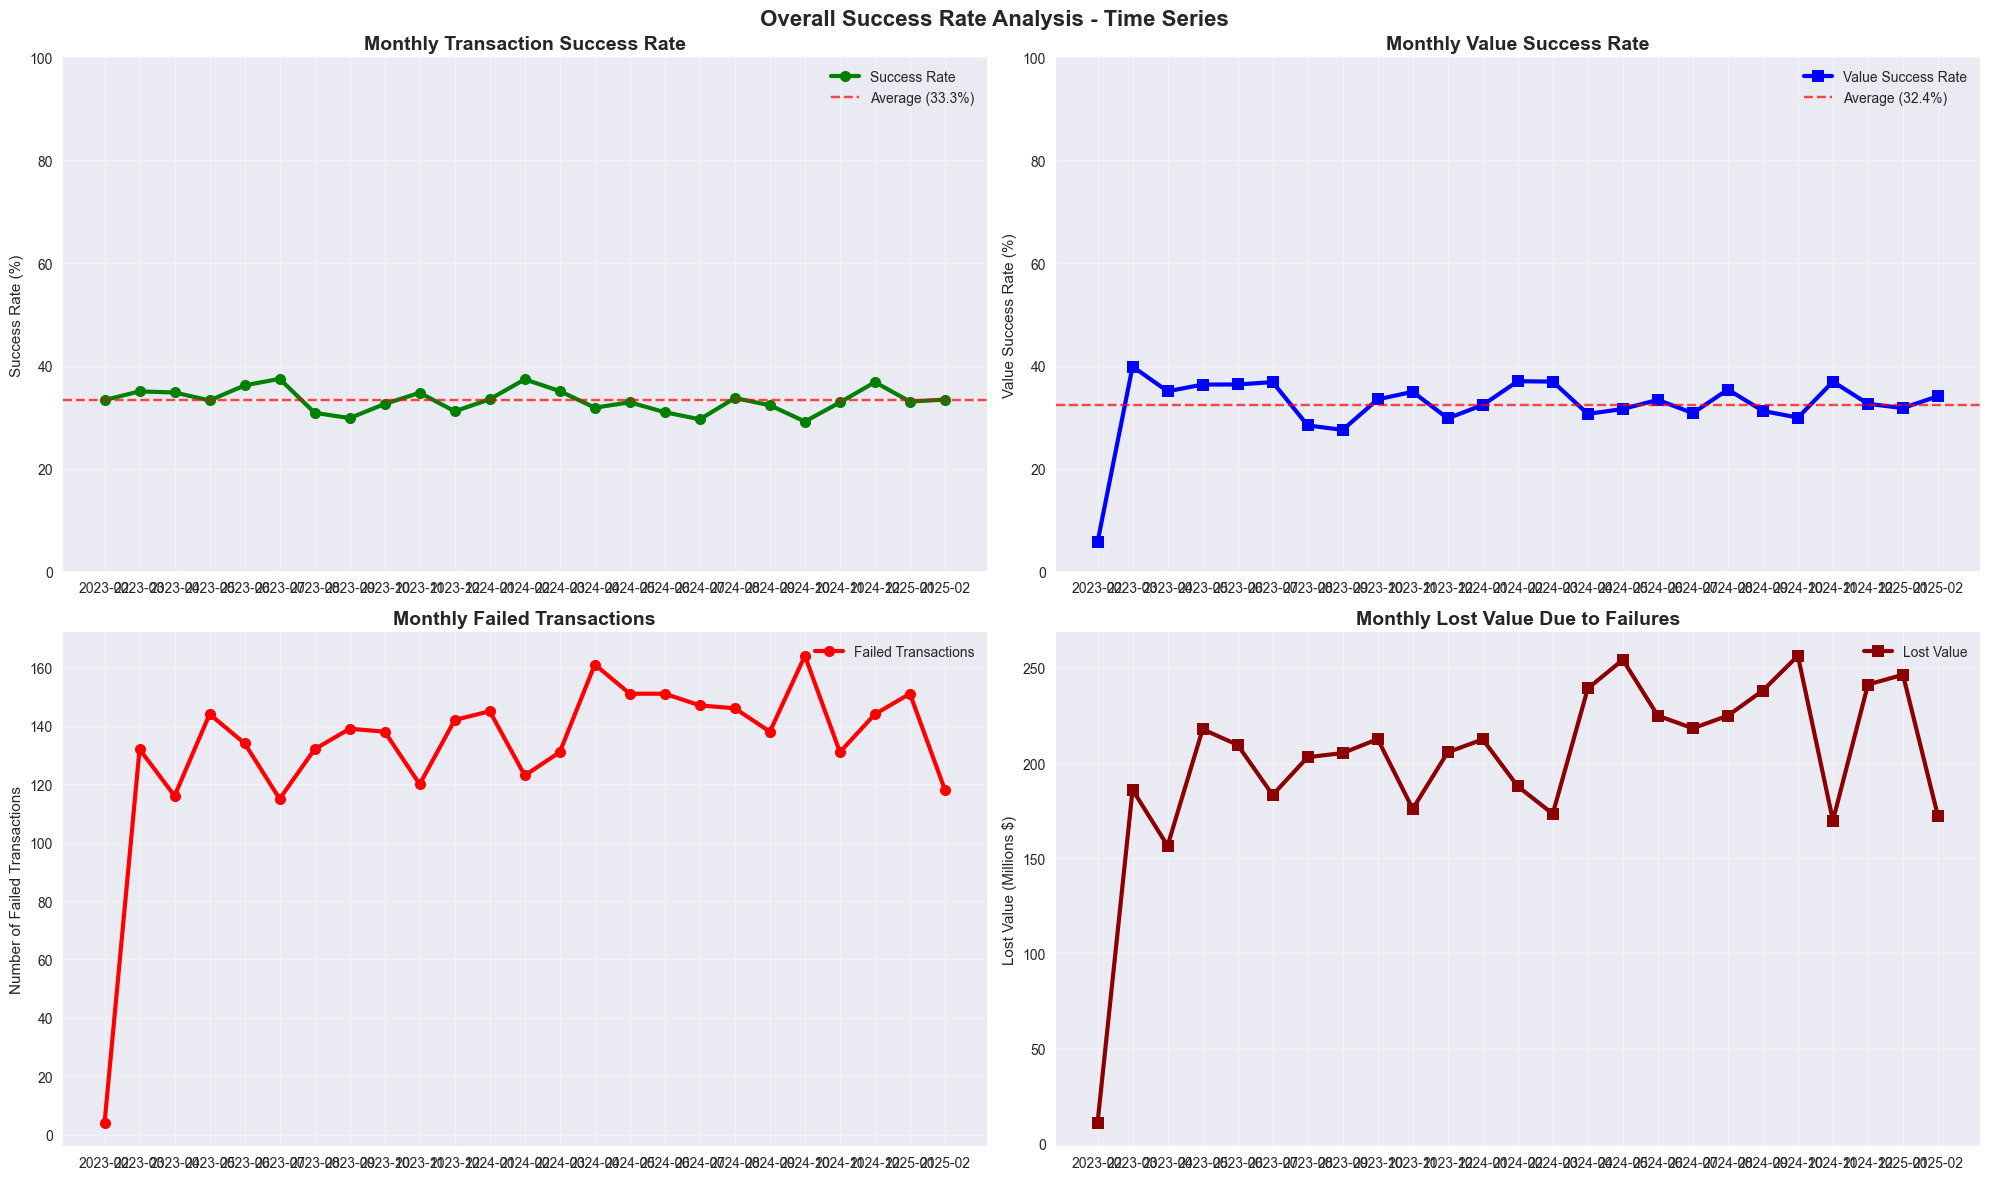

OVERALL SUCCESS RATE ANALYSIS
Average Success Rate: 33.27%
Average Value Success Rate: 32.35%
Best Month Success Rate: 37.47%
Worst Month Success Rate: 29.16%
Total Failed Transactions: 3,317
Total Lost Value: $5,026,668,639.60


(      month     Status  Transaction_Count   Total_Value  Total_Transactions  \
 0   2023-02  Completed                  4  9.422257e+05                  12   
 1   2023-03  Completed                152  2.505568e+08                 434   
 2   2023-04  Completed                134  1.997433e+08                 385   
 3   2023-05  Completed                146  2.540653e+08                 439   
 4   2023-06  Completed                148  2.278374e+08                 409   
 5   2023-07  Completed                139  1.951674e+08                 371   
 6   2023-08  Completed                124  1.691870e+08                 402   
 7   2023-09  Completed                119  1.569162e+08                 399   
 8   2023-10  Completed                143  2.207275e+08                 439   
 9   2023-11  Completed                147  2.133101e+08                 423   
 10  2023-12  Completed                128  1.945232e+08                 411   
 11  2024-01  Completed                1

In [20]:
analyze_overall_success_rate()

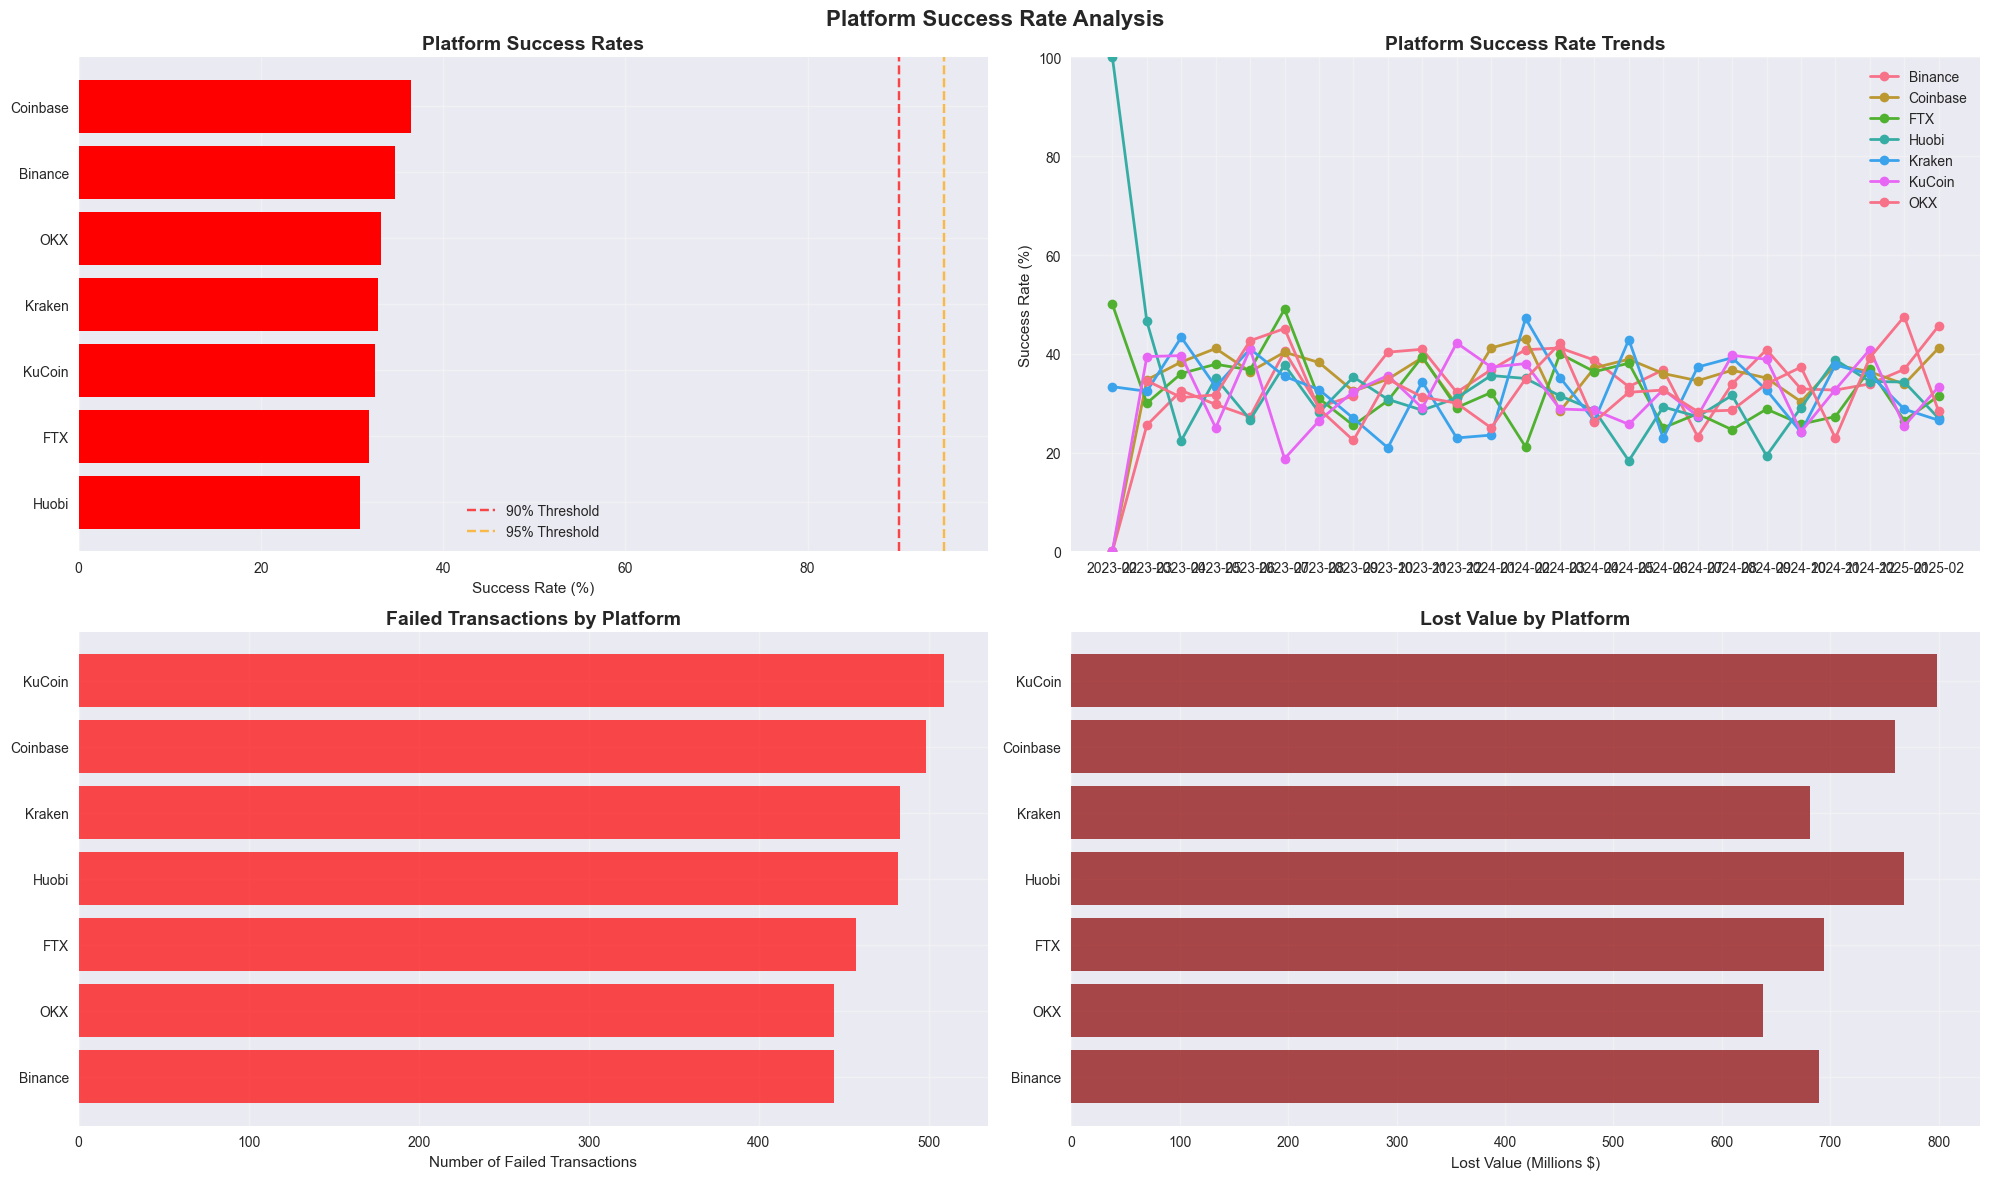

(   Platform     Status  Transaction_Count   Total_Value  Total_Transactions  \
 0   Binance  Completed                480  7.195887e+08                1383   
 1  Coinbase  Completed                547  8.147401e+08                1501   
 2       FTX  Completed                442  6.841912e+08                1385   
 3     Huobi  Completed                435  6.849057e+08                1407   
 4    Kraken  Completed                460  6.938204e+08                1400   
 5    KuCoin  Completed                479  6.842042e+08                1474   
 6       OKX  Completed                445  6.881015e+08                1343   
 
    Total_Value_All  Success_Rate  Value_Success_Rate  
 0     2.075563e+09     34.707158           34.669560  
 1     2.258904e+09     36.442372           36.067946  
 2     2.086443e+09     31.913357           32.792230  
 3     2.212990e+09     30.916844           30.949335  
 4     2.041569e+09     32.857143           33.984666  
 5     2.223331e+09   

In [21]:
analyze_platform_success_rates()

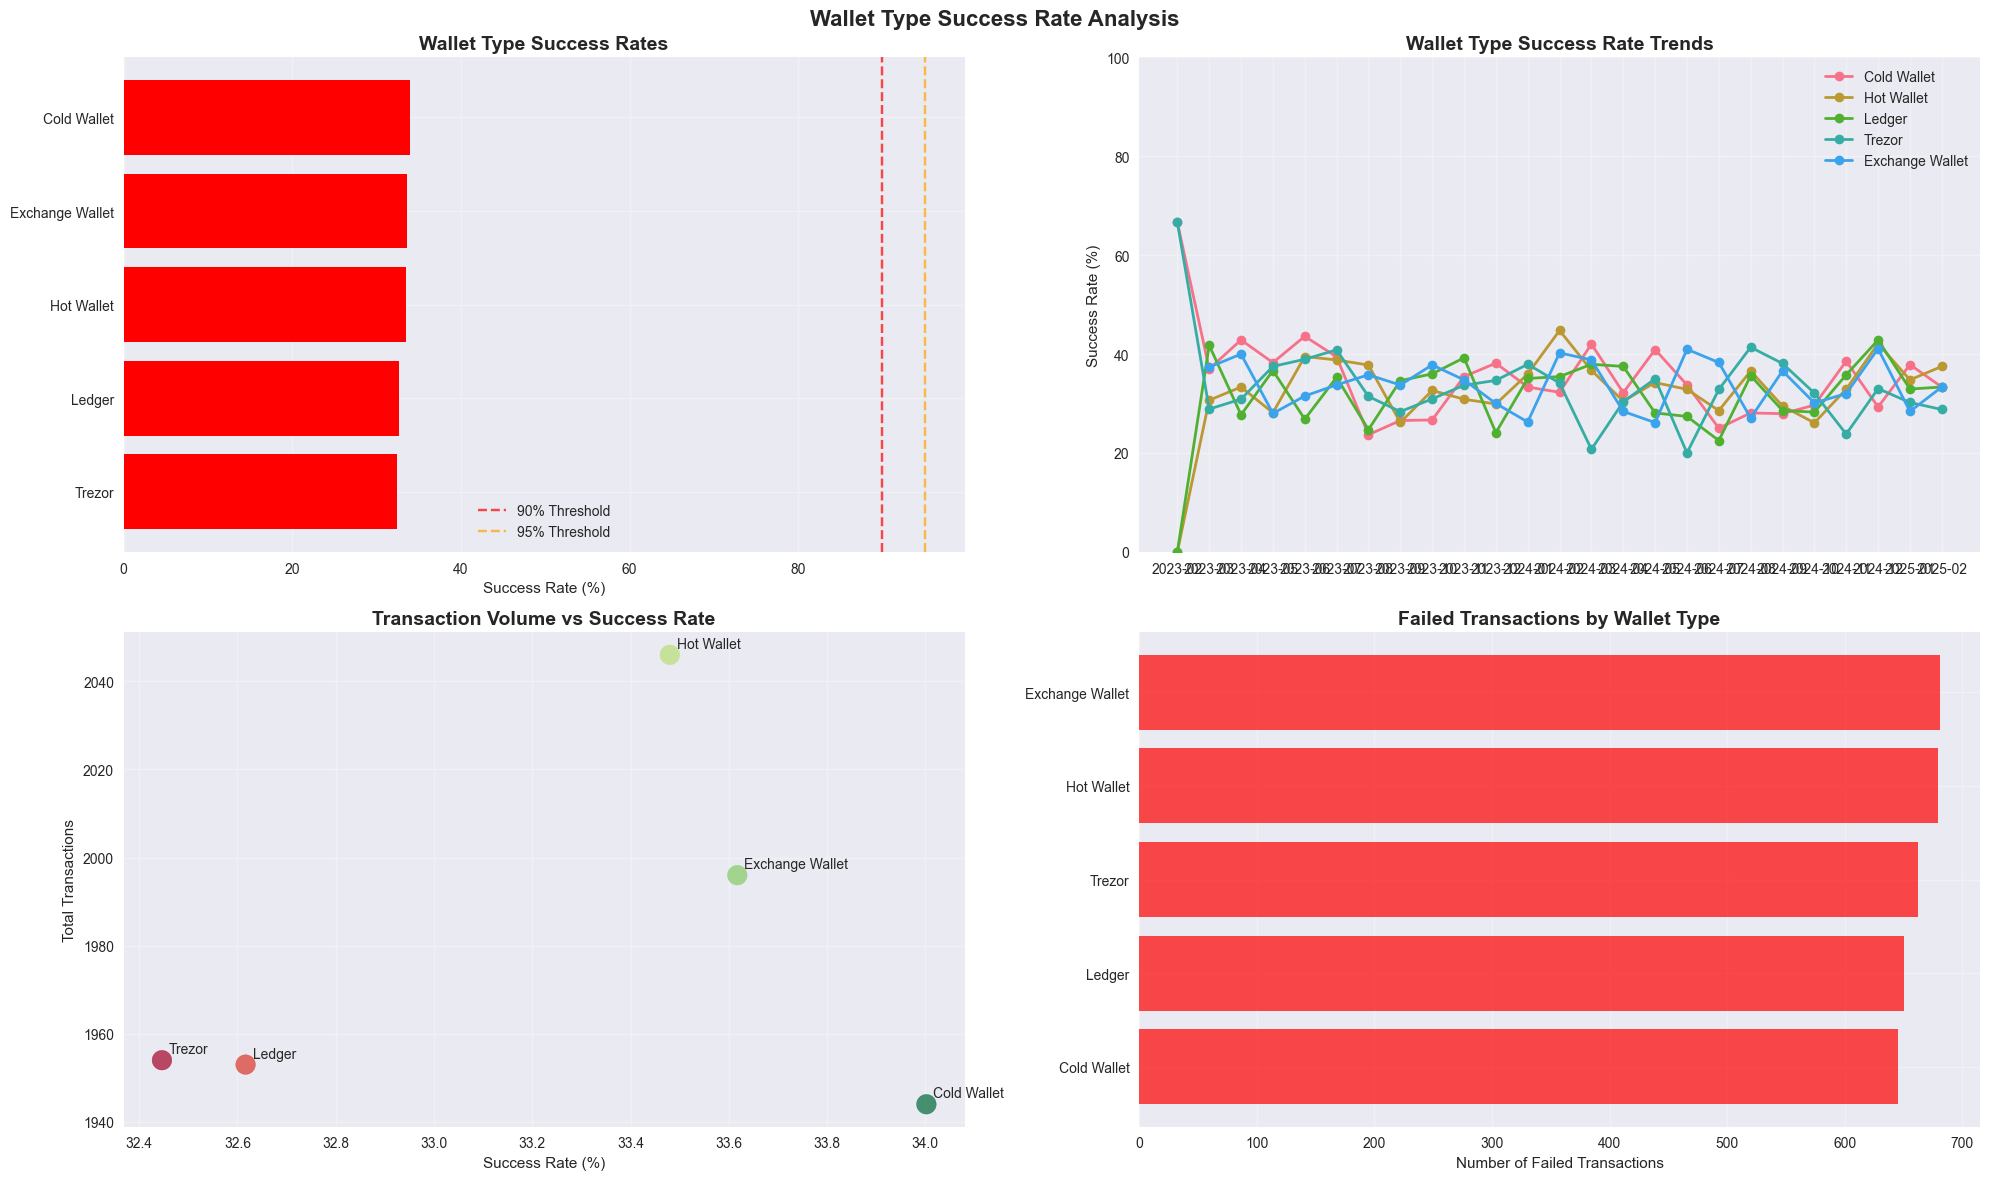

(       Wallet_Type     Status  Transaction_Count   Total_Value  \
 0      Cold Wallet  Completed                661  1.017028e+09   
 1  Exchange Wallet  Completed                671  1.005890e+09   
 2       Hot Wallet  Completed                685  1.021610e+09   
 3           Ledger  Completed                637  9.557717e+08   
 4           Trezor  Completed                634  9.692521e+08   
 
    Total_Transactions  Total_Value_All  Success_Rate  Value_Success_Rate  
 0                1944     2.880150e+09     34.002058           35.311643  
 1                1996     3.032326e+09     33.617234           33.172212  
 2                2046     3.048838e+09     33.479961           33.508179  
 3                1953     2.956033e+09     32.616487           32.332913  
 4                1954     2.973893e+09     32.446264           32.592036  ,
        Wallet_Type  Status  Transaction_Count   Total_Value  \
 0      Cold Wallet  Failed                645  9.792215e+08   
 1  Exchang

In [22]:
analyze_wallet_success_rates()

In [23]:
calculate_volume_opportunities()

VOLUME INCREASE OPPORTUNITY ANALYSIS

🏢 PLATFORM OPPORTUNITIES:
--------------------------------------------------
Binance:
  Current Success Rate: 34.7%
  Failed Transactions: 444
  Potential Additional Volume: 410 transactions
  Potential Additional Value: $636,806,806
  Volume Increase: 29.6%

Coinbase:
  Current Success Rate: 36.4%
  Failed Transactions: 498
  Potential Additional Volume: 459 transactions
  Potential Additional Value: $699,535,840
  Volume Increase: 30.6%

FTX:
  Current Success Rate: 31.9%
  Failed Transactions: 457
  Potential Additional Volume: 423 transactions
  Potential Additional Value: $642,793,004
  Volume Increase: 30.6%

Huobi:
  Current Success Rate: 30.9%
  Failed Transactions: 482
  Potential Additional Volume: 447 transactions
  Potential Additional Value: $711,951,674
  Volume Increase: 31.8%

Kraken:
  Current Success Rate: 32.9%
  Failed Transactions: 483
  Potential Additional Volume: 447 transactions
  Potential Additional Value: $630,258,276
  

{'platform_volume_opportunity': np.float64(3068.5056096827843),
 'platform_value_opportunity': np.float64(4650139355.262541),
 'wallet_volume_opportunity': np.float64(3068.574740953647),
 'wallet_value_opportunity': np.float64(4650198484.468188)}

TRANSACTION SUCCESS RATE ANALYSIS & OPPORTUNITY IDENTIFICATION

1. CALCULATING SUCCESS RATES BY DIMENSIONS
--------------------------------------------------
✓ Success rates calculated for Platforms and Wallets

2. CREATING VISUALIZATIONS
--------------------------------------------------


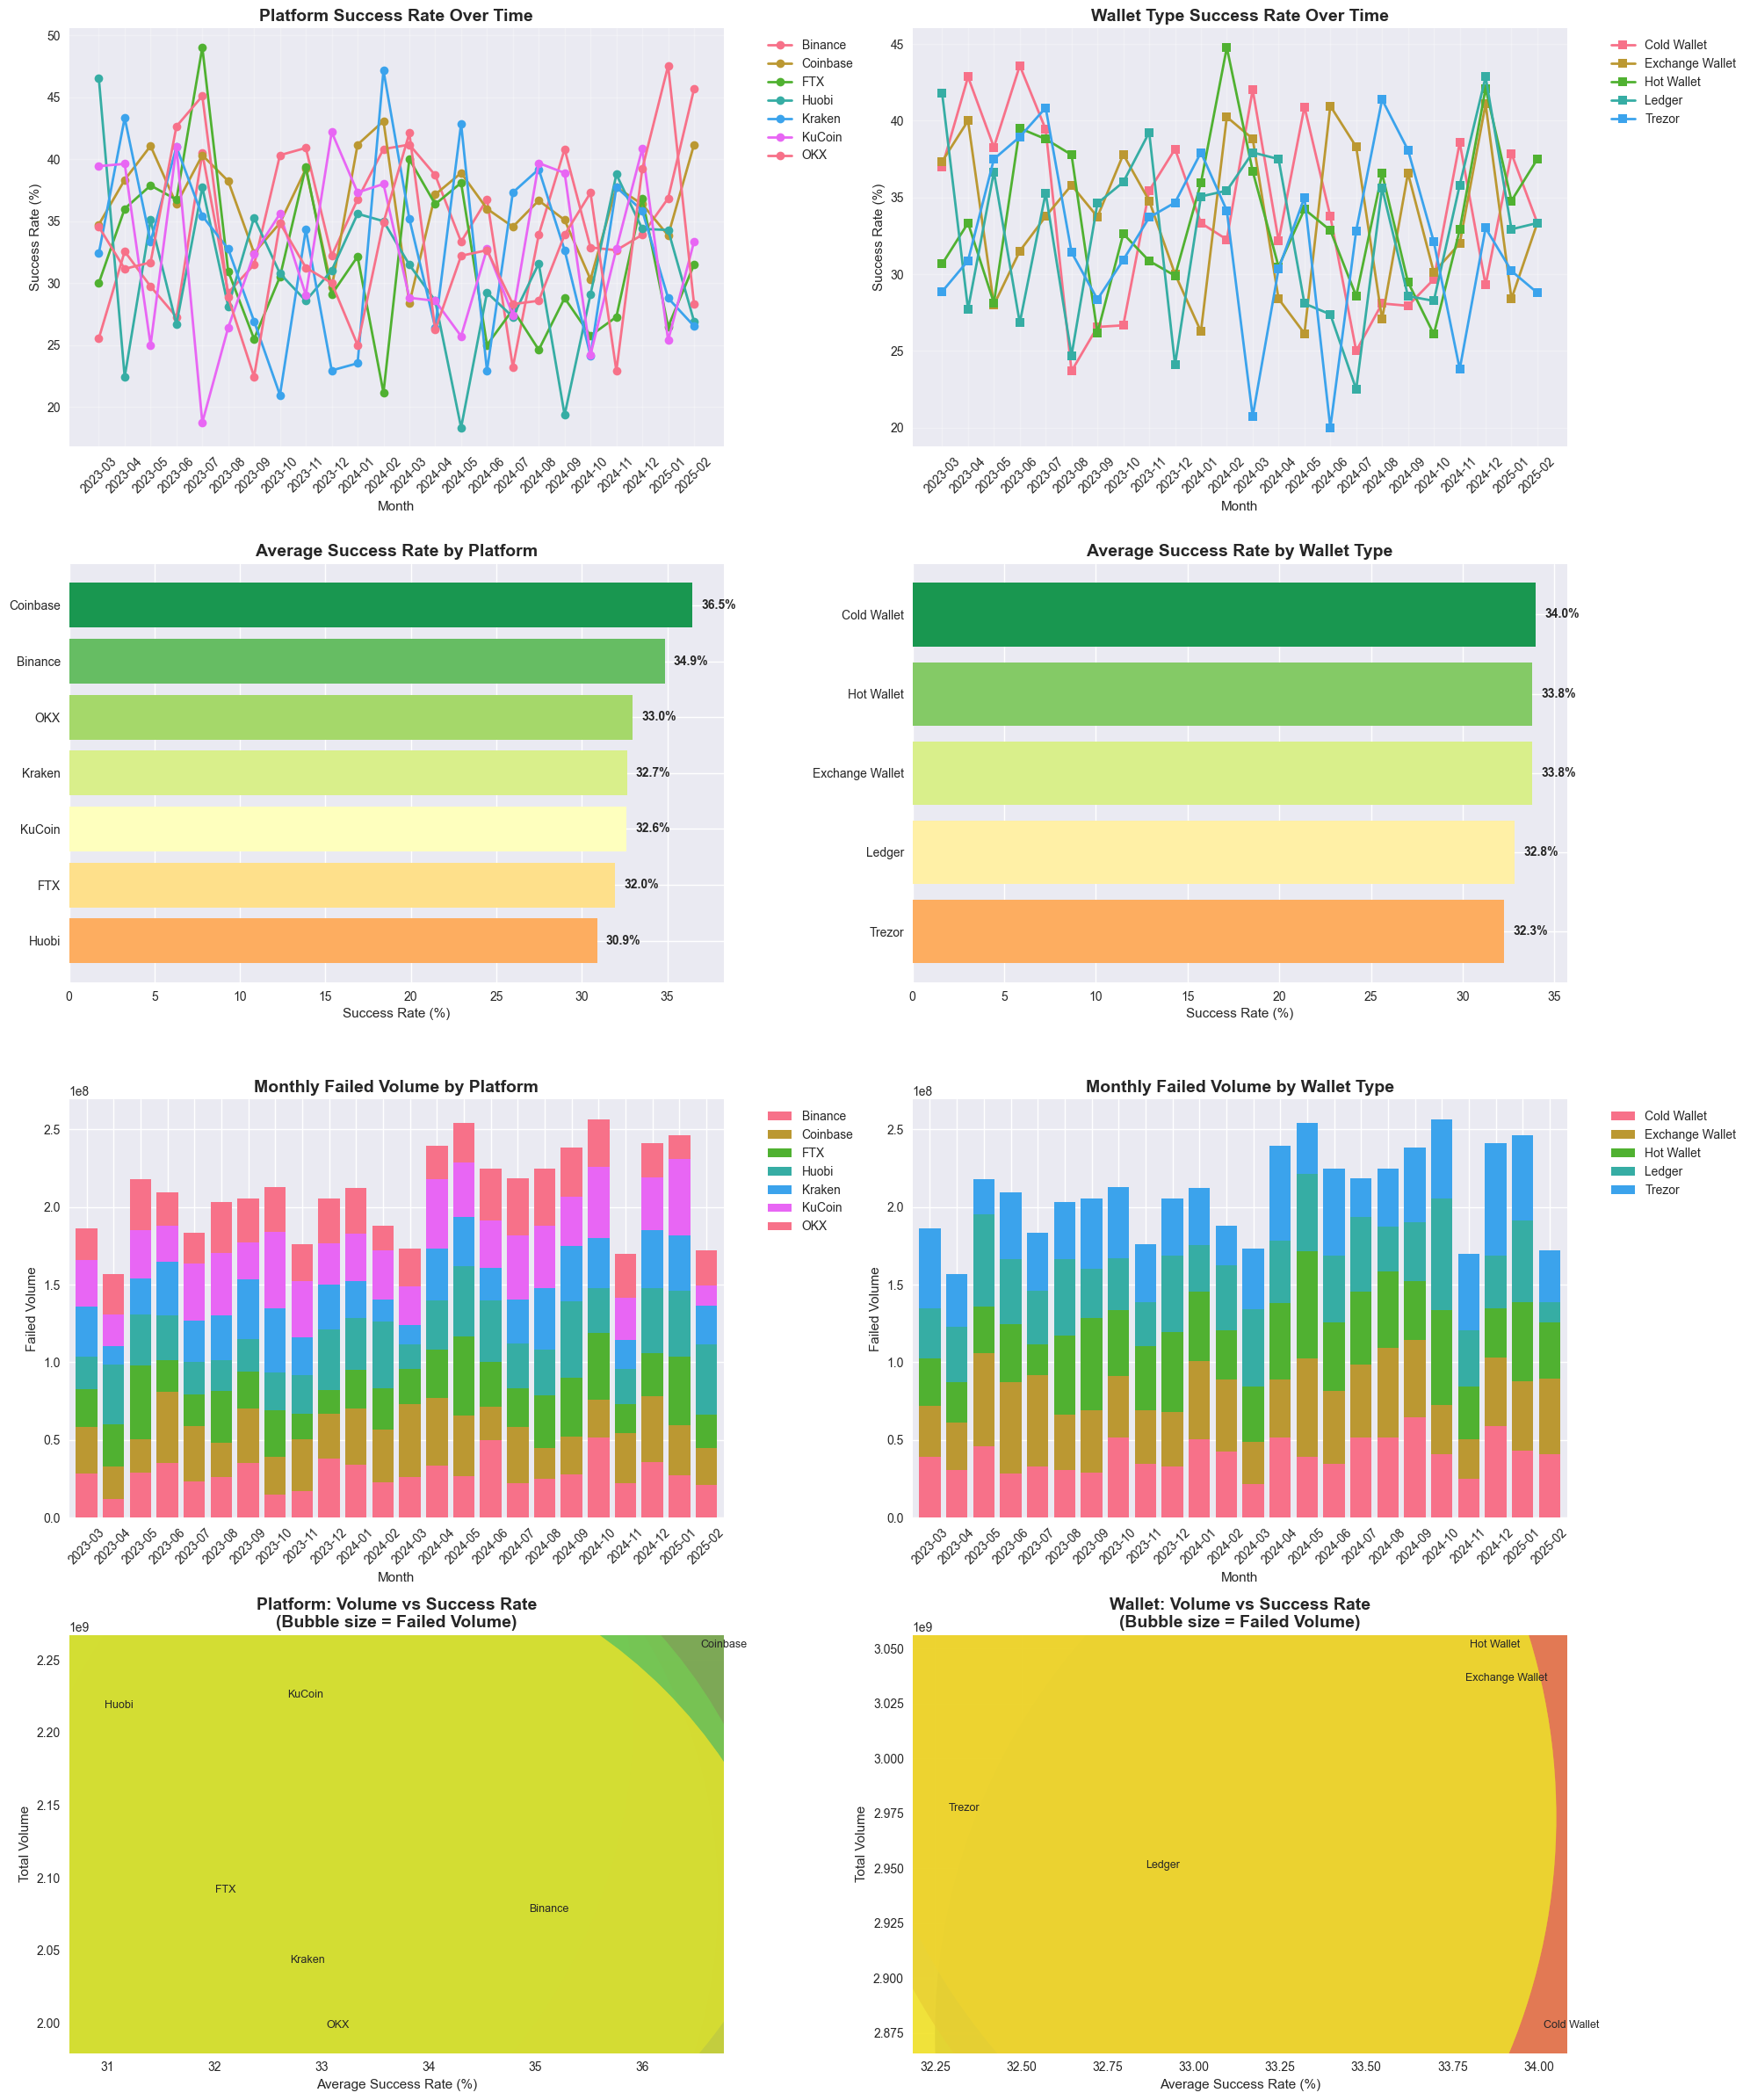

✓ All visualizations created

3. OPPORTUNITY ANALYSIS
--------------------------------------------------

3.1 PLATFORM OPPORTUNITY ANALYSIS
------------------------------
PLATFORM OPPORTUNITY RANKING:
KuCoin       | Success Rate: 32.6% | Failed Volume: $796,654,336 | Additional Volume (1%): $11,824,473 | Opportunity Score: 7,966,543
Huobi        | Success Rate: 30.9% | Failed Volume: $767,500,724 | Additional Volume (1%): $11,110,565 | Opportunity Score: 7,675,007
Coinbase     | Success Rate: 36.5% | Failed Volume: $754,410,959 | Additional Volume (1%): $11,876,926 | Opportunity Score: 7,544,110
FTX          | Success Rate: 32.0% | Failed Volume: $693,738,258 | Additional Volume (1%): $10,195,294 | Opportunity Score: 6,937,383
Binance      | Success Rate: 34.9% | Failed Volume: $686,320,918 | Additional Volume (1%): $10,539,410 | Opportunity Score: 6,863,209
Kraken       | Success Rate: 32.7% | Failed Volume: $679,512,451 | Additional Volume (1%): $10,089,648 | Opportunity Score: 6,795

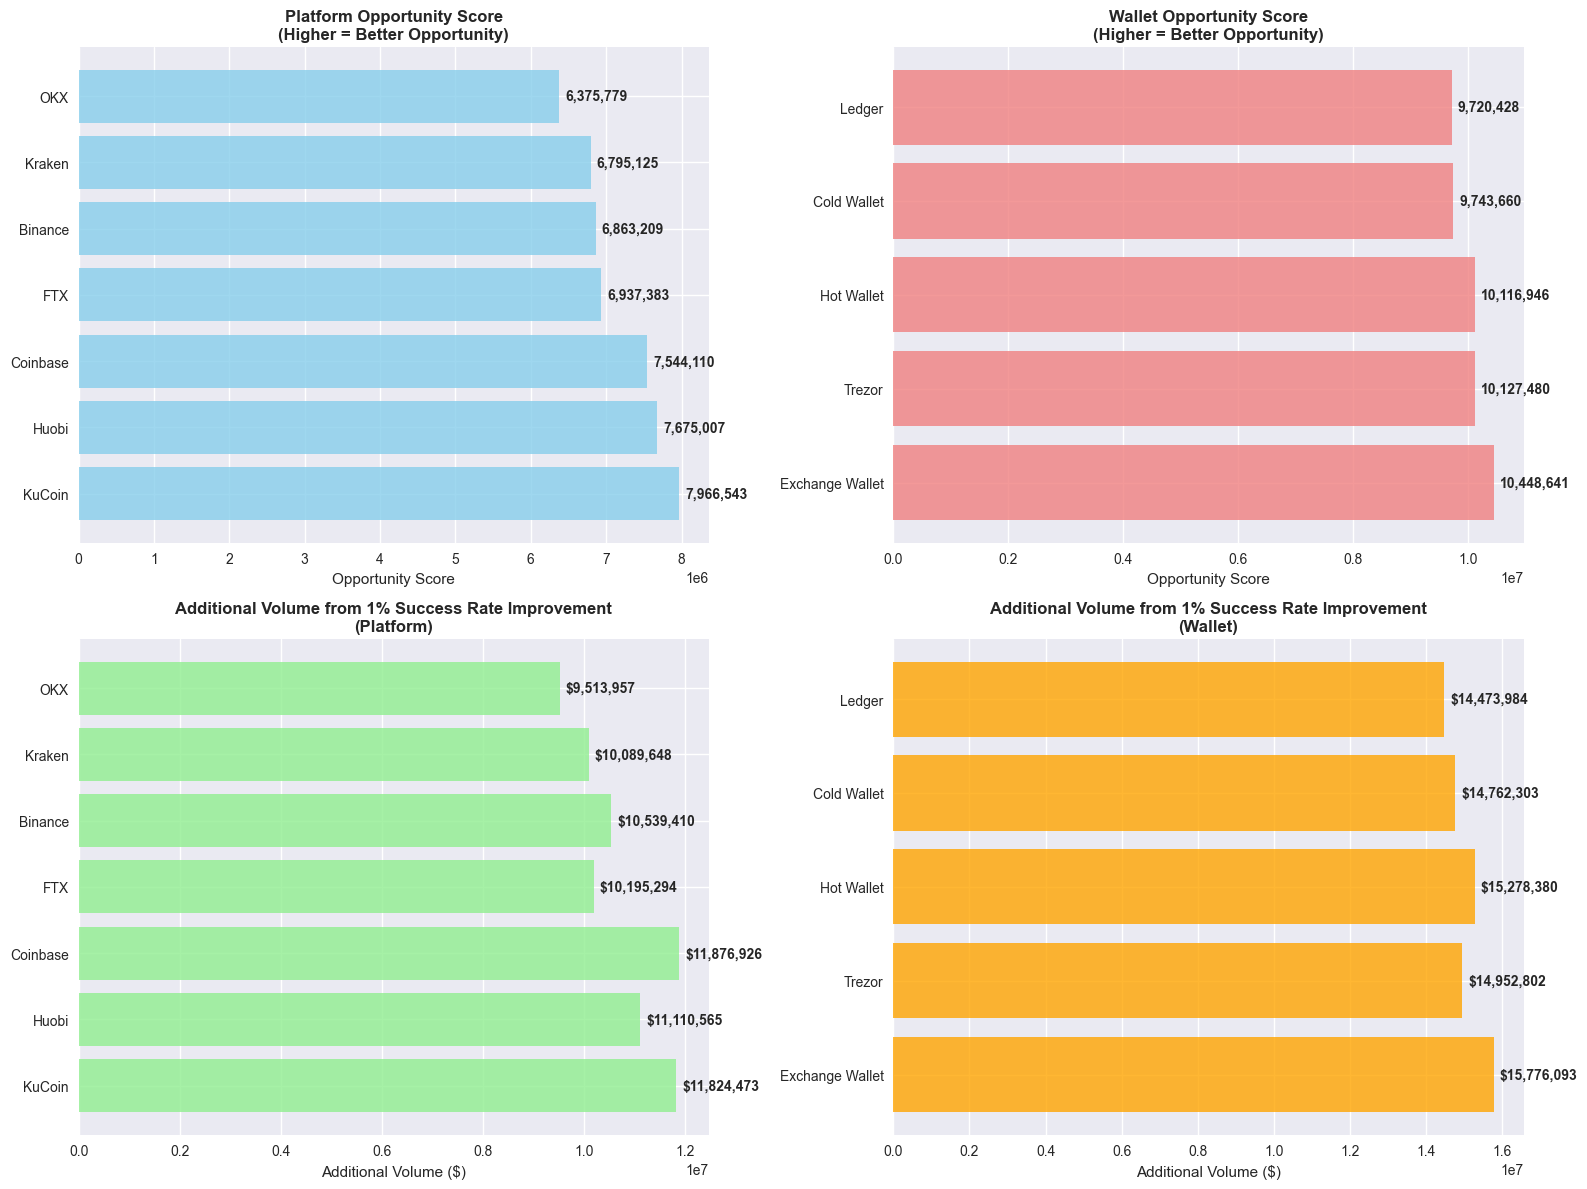


5. EXECUTIVE SUMMARY & RECOMMENDATIONS

🎯 TOP OPPORTUNITY - PLATFORM:
   Platform: KuCoin
   Current Success Rate: 32.6%
   Additional Volume from 1% improvement: $11,824,473
   Opportunity Score: 7,966,543

🎯 TOP OPPORTUNITY - WALLET:
   Wallet Type: Exchange Wallet
   Current Success Rate: 33.8%
   Additional Volume from 1% improvement: $15,776,093
   Opportunity Score: 10,448,641

💡 COMBINED OPPORTUNITY:
   Total Platform Opportunity: $75,150,274
   Total Wallet Opportunity: $75,243,561
   Combined Potential: $150,393,835

📊 KEY INSIGHTS:
   • Lowest performing platform: OKX (33.0%)
   • Highest performing platform: KuCoin (32.6%)
   • Lowest performing wallet: Ledger (32.8%)
   • Highest performing wallet: Exchange Wallet (33.8%)

ANALYSIS COMPLETE

📋 Results stored in 'results' dictionary for further analysis


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Assuming agg_monthly_t is already available from the context
# Let's create additional analysis DataFrames

print("=" * 80)
print("TRANSACTION SUCCESS RATE ANALYSIS & OPPORTUNITY IDENTIFICATION")
print("=" * 80)

# 1. Calculate success rates by different dimensions
print("\n1. CALCULATING SUCCESS RATES BY DIMENSIONS")
print("-" * 50)
# Remove the first month (chronologically) from agg_monthly_t
first_month = agg_monthly_t['month'].min()
agg_monthly_t = agg_monthly_t[agg_monthly_t['month'] != first_month]

# Success rate by Platform and Month
platform_success = (
    agg_monthly_t.groupby(['month', 'Platform', 'Status'])
    .agg({'Transaction_Count': 'sum', 'Total_Value': 'sum'})
    .reset_index()
)

# Pivot to get success rates
platform_success_pivot = platform_success.pivot_table(
    index=['month', 'Platform'], 
    columns='Status', 
    values=['Transaction_Count', 'Total_Value'],
    fill_value=0
).reset_index()

# Flatten column names
platform_success_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in platform_success_pivot.columns]

# Calculate success rates
platform_success_pivot['Total_Transactions'] = (
    platform_success_pivot.get('Transaction_Count_Completed', 0) + 
    platform_success_pivot.get('Transaction_Count_Failed', 0) + 
    platform_success_pivot.get('Transaction_Count_Pending', 0)
)

platform_success_pivot['Success_Rate'] = (
    platform_success_pivot.get('Transaction_Count_Completed', 0) / 
    platform_success_pivot['Total_Transactions']
) * 100

platform_success_pivot['Total_Volume'] = (
    platform_success_pivot.get('Total_Value_Completed', 0) + 
    platform_success_pivot.get('Total_Value_Failed', 0) + 
    platform_success_pivot.get('Total_Value_Pending', 0)
)

platform_success_pivot['Failed_Volume'] = platform_success_pivot.get('Total_Value_Failed', 0)

# Success rate by Wallet Type and Month
wallet_success = (
    agg_monthly_t.groupby(['month', 'Wallet_Type', 'Status'])
    .agg({'Transaction_Count': 'sum', 'Total_Value': 'sum'})
    .reset_index()
)

wallet_success_pivot = wallet_success.pivot_table(
    index=['month', 'Wallet_Type'], 
    columns='Status', 
    values=['Transaction_Count', 'Total_Value'],
    fill_value=0
).reset_index()

wallet_success_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in wallet_success_pivot.columns]

wallet_success_pivot['Total_Transactions'] = (
    wallet_success_pivot.get('Transaction_Count_Completed', 0) + 
    wallet_success_pivot.get('Transaction_Count_Failed', 0) + 
    wallet_success_pivot.get('Transaction_Count_Pending', 0)
)

wallet_success_pivot['Success_Rate'] = (
    wallet_success_pivot.get('Transaction_Count_Completed', 0) / 
    wallet_success_pivot['Total_Transactions']
) * 100

wallet_success_pivot['Total_Volume'] = (
    wallet_success_pivot.get('Total_Value_Completed', 0) + 
    wallet_success_pivot.get('Total_Value_Failed', 0) + 
    wallet_success_pivot.get('Total_Value_Pending', 0)
)

wallet_success_pivot['Failed_Volume'] = wallet_success_pivot.get('Total_Value_Failed', 0)

print("✓ Success rates calculated for Platforms and Wallets")

# 2. Create visualizations
print("\n2. CREATING VISUALIZATIONS")
print("-" * 50)

# Set up the plotting area
fig = plt.figure(figsize=(20, 24))

# 2.1 Platform Success Rate Time Series
ax1 = plt.subplot(4, 2, 1)
platform_ts = platform_success_pivot.groupby(['month', 'Platform'])['Success_Rate'].mean().reset_index()
platform_ts_pivot = platform_ts.pivot(index='month', columns='Platform', values='Success_Rate')

for platform in platform_ts_pivot.columns:
    plt.plot(platform_ts_pivot.index, platform_ts_pivot[platform], marker='o', linewidth=2, label=platform)

plt.title('Platform Success Rate Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Success Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.2 Wallet Success Rate Time Series
ax2 = plt.subplot(4, 2, 2)
wallet_ts = wallet_success_pivot.groupby(['month', 'Wallet_Type'])['Success_Rate'].mean().reset_index()
wallet_ts_pivot = wallet_ts.pivot(index='month', columns='Wallet_Type', values='Success_Rate')

for wallet in wallet_ts_pivot.columns:
    plt.plot(wallet_ts_pivot.index, wallet_ts_pivot[wallet], marker='s', linewidth=2, label=wallet)

plt.title('Wallet Type Success Rate Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Success Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.3 Average Success Rate by Platform
ax3 = plt.subplot(4, 2, 3)
platform_avg = platform_success_pivot.groupby('Platform')['Success_Rate'].mean().sort_values(ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(platform_avg)))
bars = plt.barh(platform_avg.index, platform_avg.values, color=colors)
plt.title('Average Success Rate by Platform', fontsize=14, fontweight='bold')
plt.xlabel('Success Rate (%)')
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{platform_avg.values[i]:.1f}%', va='center', fontweight='bold')

# 2.4 Average Success Rate by Wallet Type
ax4 = plt.subplot(4, 2, 4)
wallet_avg = wallet_success_pivot.groupby('Wallet_Type')['Success_Rate'].mean().sort_values(ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(wallet_avg)))
bars = plt.barh(wallet_avg.index, wallet_avg.values, color=colors)
plt.title('Average Success Rate by Wallet Type', fontsize=14, fontweight='bold')
plt.xlabel('Success Rate (%)')
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{wallet_avg.values[i]:.1f}%', va='center', fontweight='bold')

# 2.5 Monthly Failed Volume by Platform
ax5 = plt.subplot(4, 2, 5)
platform_failed_vol = platform_success_pivot.groupby(['month', 'Platform'])['Failed_Volume'].sum().reset_index()
platform_failed_pivot = platform_failed_vol.pivot(index='month', columns='Platform', values='Failed_Volume')

platform_failed_pivot.plot(kind='bar', stacked=True, ax=ax5, width=0.8)
plt.title('Monthly Failed Volume by Platform', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Failed Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 2.6 Monthly Failed Volume by Wallet Type
ax6 = plt.subplot(4, 2, 6)
wallet_failed_vol = wallet_success_pivot.groupby(['month', 'Wallet_Type'])['Failed_Volume'].sum().reset_index()
wallet_failed_pivot = wallet_failed_vol.pivot(index='month', columns='Wallet_Type', values='Failed_Volume')

wallet_failed_pivot.plot(kind='bar', stacked=True, ax=ax6, width=0.8)
plt.title('Monthly Failed Volume by Wallet Type', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Failed Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 2.7 Transaction Volume vs Success Rate Scatter (Platform)
ax7 = plt.subplot(4, 2, 7)
platform_scatter = platform_success_pivot.groupby('Platform').agg({
    'Success_Rate': 'mean',
    'Total_Volume': 'sum',
    'Failed_Volume': 'sum'
}).reset_index()

plt.scatter(platform_scatter['Success_Rate'], platform_scatter['Total_Volume'], 
           s=platform_scatter['Failed_Volume']/1000, alpha=0.7, c=range(len(platform_scatter)), cmap='viridis')
plt.xlabel('Average Success Rate (%)')
plt.ylabel('Total Volume')
plt.title('Platform: Volume vs Success Rate\n(Bubble size = Failed Volume)', fontsize=14, fontweight='bold')
for i, row in platform_scatter.iterrows():
    plt.annotate(row['Platform'], (row['Success_Rate'], row['Total_Volume']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# 2.8 Transaction Volume vs Success Rate Scatter (Wallet)
ax8 = plt.subplot(4, 2, 8)
wallet_scatter = wallet_success_pivot.groupby('Wallet_Type').agg({
    'Success_Rate': 'mean',
    'Total_Volume': 'sum',
    'Failed_Volume': 'sum'
}).reset_index()

plt.scatter(wallet_scatter['Success_Rate'], wallet_scatter['Total_Volume'], 
           s=wallet_scatter['Failed_Volume']/1000, alpha=0.7, c=range(len(wallet_scatter)), cmap='plasma')
plt.xlabel('Average Success Rate (%)')
plt.ylabel('Total Volume')
plt.title('Wallet: Volume vs Success Rate\n(Bubble size = Failed Volume)', fontsize=14, fontweight='bold')
for i, row in wallet_scatter.iterrows():
    plt.annotate(row['Wallet_Type'], (row['Success_Rate'], row['Total_Volume']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ All visualizations created")

# 3. Opportunity Analysis
print("\n3. OPPORTUNITY ANALYSIS")
print("-" * 50)

# Calculate opportunity for 1% improvement in success rate
print("\n3.1 PLATFORM OPPORTUNITY ANALYSIS")
print("-" * 30)

platform_opportunity = platform_success_pivot.groupby('Platform').agg({
    'Success_Rate': 'mean',
    'Total_Volume': 'sum',
    'Failed_Volume': 'sum',
    'Total_Transactions': 'sum'
}).reset_index()

# Calculate potential volume gain from 1% improvement
platform_opportunity['Current_Success_Rate'] = platform_opportunity['Success_Rate']
platform_opportunity['Improved_Success_Rate'] = platform_opportunity['Success_Rate'] + 1.0
platform_opportunity['Failed_Rate'] = 100 - platform_opportunity['Success_Rate']

# Calculate potential additional volume from 1% improvement
# If we improve success rate by 1%, we convert 1% of current failed transactions to successful
platform_opportunity['Additional_Volume_1pct'] = (
    platform_opportunity['Failed_Volume'] * 0.01 / (platform_opportunity['Failed_Rate'] / 100)
)

platform_opportunity['Opportunity_Score'] = (
    platform_opportunity['Additional_Volume_1pct'] * 
    (100 - platform_opportunity['Success_Rate']) / 100  # Weight by room for improvement
)

platform_opportunity = platform_opportunity.sort_values('Opportunity_Score', ascending=False)

print("PLATFORM OPPORTUNITY RANKING:")
print("=" * 60)
for i, row in platform_opportunity.iterrows():
    print(f"{row['Platform']:<12} | Success Rate: {row['Success_Rate']:.1f}% | "
          f"Failed Volume: ${row['Failed_Volume']:,.0f} | "
          f"Additional Volume (1%): ${row['Additional_Volume_1pct']:,.0f} | "
          f"Opportunity Score: {row['Opportunity_Score']:,.0f}")

print("\n3.2 WALLET OPPORTUNITY ANALYSIS")
print("-" * 30)

wallet_opportunity = wallet_success_pivot.groupby('Wallet_Type').agg({
    'Success_Rate': 'mean',
    'Total_Volume': 'sum',
    'Failed_Volume': 'sum',
    'Total_Transactions': 'sum'
}).reset_index()

wallet_opportunity['Current_Success_Rate'] = wallet_opportunity['Success_Rate']
wallet_opportunity['Improved_Success_Rate'] = wallet_opportunity['Success_Rate'] + 1.0
wallet_opportunity['Failed_Rate'] = 100 - wallet_opportunity['Success_Rate']

wallet_opportunity['Additional_Volume_1pct'] = (
    wallet_opportunity['Failed_Volume'] * 0.01 / (wallet_opportunity['Failed_Rate'] / 100)
)

wallet_opportunity['Opportunity_Score'] = (
    wallet_opportunity['Additional_Volume_1pct'] * 
    (100 - wallet_opportunity['Success_Rate']) / 100
)

wallet_opportunity = wallet_opportunity.sort_values('Opportunity_Score', ascending=False)

print("WALLET OPPORTUNITY RANKING:")
print("=" * 60)
for i, row in wallet_opportunity.iterrows():
    print(f"{row['Wallet_Type']:<15} | Success Rate: {row['Success_Rate']:.1f}% | "
          f"Failed Volume: ${row['Failed_Volume']:,.0f} | "
          f"Additional Volume (1%): ${row['Additional_Volume_1pct']:,.0f} | "
          f"Opportunity Score: {row['Opportunity_Score']:,.0f}")

# 4. Create Opportunity Ranking Visualization
print("\n4. CREATING OPPORTUNITY RANKING VISUALIZATIONS")
print("-" * 50)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Platform Opportunity Score
ax1.barh(platform_opportunity['Platform'], platform_opportunity['Opportunity_Score'], 
         color='skyblue', alpha=0.8)
ax1.set_title('Platform Opportunity Score\n(Higher = Better Opportunity)', fontweight='bold')
ax1.set_xlabel('Opportunity Score')
for i, (platform, score) in enumerate(zip(platform_opportunity['Platform'], platform_opportunity['Opportunity_Score'])):
    ax1.text(score + max(platform_opportunity['Opportunity_Score']) * 0.01, i, f'{score:,.0f}', 
             va='center', fontweight='bold')

# Wallet Opportunity Score
ax2.barh(wallet_opportunity['Wallet_Type'], wallet_opportunity['Opportunity_Score'], 
         color='lightcoral', alpha=0.8)
ax2.set_title('Wallet Opportunity Score\n(Higher = Better Opportunity)', fontweight='bold')
ax2.set_xlabel('Opportunity Score')
for i, (wallet, score) in enumerate(zip(wallet_opportunity['Wallet_Type'], wallet_opportunity['Opportunity_Score'])):
    ax2.text(score + max(wallet_opportunity['Opportunity_Score']) * 0.01, i, f'{score:,.0f}', 
             va='center', fontweight='bold')

# Platform Additional Volume from 1% Improvement
ax3.barh(platform_opportunity['Platform'], platform_opportunity['Additional_Volume_1pct'], 
         color='lightgreen', alpha=0.8)
ax3.set_title('Additional Volume from 1% Success Rate Improvement\n(Platform)', fontweight='bold')
ax3.set_xlabel('Additional Volume ($)')
for i, (platform, vol) in enumerate(zip(platform_opportunity['Platform'], platform_opportunity['Additional_Volume_1pct'])):
    ax3.text(vol + max(platform_opportunity['Additional_Volume_1pct']) * 0.01, i, f'${vol:,.0f}', 
             va='center', fontweight='bold')

# Wallet Additional Volume from 1% Improvement
ax4.barh(wallet_opportunity['Wallet_Type'], wallet_opportunity['Additional_Volume_1pct'], 
         color='orange', alpha=0.8)
ax4.set_title('Additional Volume from 1% Success Rate Improvement\n(Wallet)', fontweight='bold')
ax4.set_xlabel('Additional Volume ($)')
for i, (wallet, vol) in enumerate(zip(wallet_opportunity['Wallet_Type'], wallet_opportunity['Additional_Volume_1pct'])):
    ax4.text(vol + max(wallet_opportunity['Additional_Volume_1pct']) * 0.01, i, f'${vol:,.0f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Summary and Recommendations
print("\n5. EXECUTIVE SUMMARY & RECOMMENDATIONS")
print("=" * 60)

top_platform = platform_opportunity.iloc[0]
top_wallet = wallet_opportunity.iloc[0]

print(f"\n🎯 TOP OPPORTUNITY - PLATFORM:")
print(f"   Platform: {top_platform['Platform']}")
print(f"   Current Success Rate: {top_platform['Success_Rate']:.1f}%")
print(f"   Additional Volume from 1% improvement: ${top_platform['Additional_Volume_1pct']:,.0f}")
print(f"   Opportunity Score: {top_platform['Opportunity_Score']:,.0f}")

print(f"\n🎯 TOP OPPORTUNITY - WALLET:")
print(f"   Wallet Type: {top_wallet['Wallet_Type']}")
print(f"   Current Success Rate: {top_wallet['Success_Rate']:.1f}%")
print(f"   Additional Volume from 1% improvement: ${top_wallet['Additional_Volume_1pct']:,.0f}")
print(f"   Opportunity Score: {top_wallet['Opportunity_Score']:,.0f}")

print(f"\n💡 COMBINED OPPORTUNITY:")
total_platform_opportunity = platform_opportunity['Additional_Volume_1pct'].sum()
total_wallet_opportunity = wallet_opportunity['Additional_Volume_1pct'].sum()
print(f"   Total Platform Opportunity: ${total_platform_opportunity:,.0f}")
print(f"   Total Wallet Opportunity: ${total_wallet_opportunity:,.0f}")
print(f"   Combined Potential: ${total_platform_opportunity + total_wallet_opportunity:,.0f}")

print(f"\n📊 KEY INSIGHTS:")
print(f"   • Lowest performing platform: {platform_opportunity.iloc[-1]['Platform']} ({platform_opportunity.iloc[-1]['Success_Rate']:.1f}%)")
print(f"   • Highest performing platform: {platform_opportunity.iloc[0]['Platform']} ({platform_opportunity.iloc[0]['Success_Rate']:.1f}%)")
print(f"   • Lowest performing wallet: {wallet_opportunity.iloc[-1]['Wallet_Type']} ({wallet_opportunity.iloc[-1]['Success_Rate']:.1f}%)")
print(f"   • Highest performing wallet: {wallet_opportunity.iloc[0]['Wallet_Type']} ({wallet_opportunity.iloc[0]['Success_Rate']:.1f}%)")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

# Store results for further analysis
results = {
    'platform_opportunity': platform_opportunity,
    'wallet_opportunity': wallet_opportunity,
    'platform_success_pivot': platform_success_pivot,
    'wallet_success_pivot': wallet_success_pivot
}

print("\n📋 Results stored in 'results' dictionary for further analysis")